# GNN applications: Genes and Pathway embeddings

There are two datasets available and 2 types of one dataset, that is:
* The graph metapathways **metapathway_kegg_genes/gene_edges.tsv**
* The list of nodes for a pathway **metapathway_kegg_genes/pathways.tsv**
* The expression matrices normalized for:
  * Controls patients **locicero_brca_normalizzato\locicero_brca_data_norm_2.txt**
  * Tumor patients **locicero_brca_tumor\locicero_brca_data_tumor_zscores.txt**

Both of the patients are normalized with a z-score method, there is also another normalization but better results are expected with z-scores.

In [1]:
import os

import stellargraph as sg
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GCN

from stellargraph.mapper import DirectedGraphSAGENodeGenerator
from stellargraph.layer import DirectedGraphSAGE

from tensorflow.keras import layers, optimizers, losses, metrics, Model,Input

import tensorflow as tf

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

import pandas as pd
from sklearn.decomposition import PCA
import numpy as np
import math
from sklearn import preprocessing,model_selection

from collections import defaultdict

from tensorflow.keras.callbacks import EarlyStopping
#from tensorflow.python.ops.numpy_ops import np_config
#np_config.enable_numpy_behavior()

The library used are **stellargraph** for using the GNN methods, and **tensorflow** to train the models and find the best parameters for the objective function defined in the documentation.

In [2]:
def load_my_data():
    #controlsDK = pd.read_csv('controls_counts.tsv', sep='\t', header=0).dropna()
    #z_score normalized data, the other espression matrices are normalized with another method
    controlsDK = pd.read_csv('locicero_brca_normalizzato/locicero_brca_data_norm_2.tsv', sep='\t', header=0).dropna()
    controlsDK.index = controlsDK.index.astype(int)
    controlsDK = controlsDK.sort_index()
    tumorDK = pd.read_csv('locicero_brca_tumor/locicero_brca_data_tumor_zscores.txt', sep='\t', header=0).dropna()
    tumorDK.index = tumorDK.index.astype(int)
    tumorDK = tumorDK.sort_index()
    tmp = pd.read_csv('metapathway_kegg_genes/gene_edges.tsv', sep='\t', header=0)
    # creating adjacency list
    def add_edges(currentDict,N,M):
        N_set = set()
        if str(N) in currentDict:
            N_set = currentDict[str(N)]
        N_set.add(str(M))
        currentDict[str(N)] = N_set
    
    outAdjacencyListMetapathways = defaultdict(set)
    inAdjacencyListMetapathways = defaultdict(set)
    for index, row in tmp.iterrows():
        add_edges(outAdjacencyListMetapathways,row["start"],row["end"])
        add_edges(inAdjacencyListMetapathways,row["end"],row["start"])
        
    # controls with features
    boolGenesWithFeatureSources = tmp["start"].map(lambda value: value in controlsDK.index)
    boolGenesWithFeatureTargets = tmp["end"].map(lambda value: value in controlsDK.index)
    boolGenesWithFeature = boolGenesWithFeatureSources & boolGenesWithFeatureTargets

    # tumors with features
    boolGenesTumorWithFeatureSources = tmp["start"].map(lambda value: value in tumorDK.index)
    boolGenesTumorWithFeatureTargets = tmp["end"].map(lambda value: value in tumorDK.index)
    boolGenesTumorWithFeature = boolGenesTumorWithFeatureSources & boolGenesTumorWithFeatureTargets

    #genesWithNoFeatures = [100653049, 9103, 2831, 100528032, 100132285, 3810, 3806, 3808,390441, 3118, 3126, 3125, 390271, 26595, 81399, 432355, 100996746, 504190, 504191, 140, 504189, 729759, 100532736,107080638, 414062, 102723407, 6019, 3803, 107181291, 102723555, 102723532, 107987545, 102800317, 100505767, 341568, 112268384, 100533105, 106821730, 388372, 105369274, 100271849, 57292, 390432]
    tmpGeneEdges = pd.read_csv('metapathway_kegg_genes/gene_edges.tsv', sep='\t', header=0).rename(columns={'start': 'source', 'end': 'target'}) 
    #geneEdgesWithNoFeatures = pd.concat(
    #    [geneEdgesWithNoFeatures[geneEdgesWithNoFeatures['source'].isin(genesWithNoFeatures)], 
    #     geneEdgesWithNoFeatures[geneEdgesWithNoFeatures['target'].isin(genesWithNoFeatures)]]
    #     )
    #geneEdgesWithNoFeatures = geneEdgesWithNoFeatures.drop_duplicates()
    geneEdgesWithNoFeatures = tmpGeneEdges[~boolGenesWithFeature]
    geneEdgesWithNoFeaturesTumor = tmpGeneEdges[~boolGenesTumorWithFeature]

    # indexes of control genes with features and not
    indexesGenesWithFeatures = controlsDK.index
    indexesGenesWithNoFeatures = pd.concat([ geneEdgesWithNoFeatures[~geneEdgesWithNoFeatures["source"].isin(controlsDK.index)]["source"] , geneEdgesWithNoFeatures[~geneEdgesWithNoFeatures["target"].isin(controlsDK.index)]["target"] ]).drop_duplicates()


    # indexes of tumor genes with features and not
    indexesGenesTumorWithFeatures = tumorDK.index
    indexesGenesTumorWithNoFeatures = pd.concat([ geneEdgesWithNoFeaturesTumor[~geneEdgesWithNoFeaturesTumor["source"].isin(tumorDK.index)]["source"] , geneEdgesWithNoFeaturesTumor[~geneEdgesWithNoFeaturesTumor["target"].isin(tumorDK.index)]["target"] ]).drop_duplicates()

    #filtering genes with no features
    #geneEdges = geneEdges[~geneEdges['source'].isin(genesWithNoFeatures)]
    #geneEdges = geneEdges[~geneEdges['target'].isin(genesWithNoFeatures)]
    geneEdges = tmpGeneEdges[boolGenesWithFeature]
    geneEdgesTumor = tmpGeneEdges[boolGenesTumorWithFeature]
    pathways = pd.read_csv('metapathway_kegg_genes/pathways.tsv', sep='\t', header=0)
    return inAdjacencyListMetapathways,outAdjacencyListMetapathways,controlsDK,tumorDK, geneEdges,geneEdgesTumor,geneEdgesWithNoFeatures,geneEdgesWithNoFeaturesTumor,indexesGenesWithFeatures,indexesGenesWithNoFeatures,indexesGenesTumorWithFeatures,indexesGenesTumorWithNoFeatures, pathways

In [3]:
tf.config.list_physical_devices('GPU')

[]

# TODO
Taking into account genes with no features in the expression matrices(the one dropped because some values were NA), I have divided them for the two datasets of patients, but an hybrid approach could be better if we use the same model, because I have in mind to use two different models for controls and tumor, but a better approach could be to take the full expression matrix(or the union of the expressed genes with features) and complete the genes that have been dropped(that is by controlling the specific values before dropping the NA, or **substituting the NA with some value** (that could be 0, a random value taken from the distribution of the defined gene expression for the row, the expression distribution that is)). 

When sampling the tumor expressions dataset, the dropped rows in the load step should be done only on the selected columns since some of them were dropped, additionally we could totally drop columns and not rows where the values are N.A.

In [4]:
inAdjacencyListMetapathways,outAdjacencyListMetapathways,controlsDK,tumorDK,geneEdges,geneEdgesTumor,geneEdgesWithNoFeatures,geneEdgesWithNoFeaturesTumor,indexGeneEdgesWithFeatures,indexGeneEdgesWithNoFeatures,indexesGenesTumorWithFeatures,indexesGenesTumorWithNoFeatures,pathways = load_my_data()

This variables are the following:
- inAdjacencyListMetapathways is used to remember all the predecessor edges(incoming) for the nodes
- inAdjacencyListMetapathways is used to remember all the antecedent edges(outgoing) for the nodes
- controlsDK is the expression matrix for the controls patients
- tumorDK is the expression matrix for the tumor patients
- geneEdges are the edges in the graph for the controls patients(subgraph with only the genes that are present in controls)
- geneEdgesTumor are the edges in the graph for the tumor patients(subgraph with only the genes that are present in tumors)
- geneEdgesWithNoFeatures are the edges in the graph that have no features for the controls patients(subgraph with only the genes that are not present in controls)
- geneEdgesWithNoFeaturesTumor are the edges in the graph that have no features for the tumor patients(subgraph with only the genes that are not present in tumors)
- indexGeneEdgesWithFeatures row number for genes in controls with features
- indexGeneEdgesWithNoFeatures row number for genes in controls with NA features
- indexesGenesTumorWithFeatures ""
- indexesGenesTumorWithNoFeatures ""
- **pathways** are the list of genes for every pathway 

In [5]:
annotationTumors = pd.read_csv('brca_clinical_stagemod.txt', sep='\t', header=0) #with NA values for subtype
annotationTumors

ID SUBTYPE AJCC_PATHOLOGIC_TUMOR_STAGE
0     TCGA-3C-AAAU    LumA                           X
1     TCGA-3C-AALI    Her2                          II
2     TCGA-3C-AALJ    LumB                          II
3     TCGA-3C-AALK    LumA                           I
4     TCGA-4H-AAAK    LumA                         III
...            ...     ...                         ...
1079  TCGA-WT-AB44    LumA                           I
1080  TCGA-XX-A899    LumA                         III
1081  TCGA-XX-A89A    LumA                          II
1082  TCGA-Z7-A8R5    LumA                         III
1083  TCGA-Z7-A8R6    LumB                           I

[1084 rows x 3 columns]

In [6]:
subtypeAnnotationLists = annotationTumors.groupby('SUBTYPE')['ID'].apply(list)
tumorStageAnnotationLists = annotationTumors.groupby('AJCC_PATHOLOGIC_TUMOR_STAGE')['ID'].apply(list)
subtypeAnnotationLists

SUBTYPE
Basal     [TCGA-A1-A0SK, TCGA-A1-A0SO, TCGA-A1-A0SP, TCG...
Her2      [TCGA-3C-AALI, TCGA-A2-A04W, TCGA-A2-A04X, TCG...
LumA      [TCGA-3C-AAAU, TCGA-3C-AALK, TCGA-4H-AAAK, TCG...
LumB      [TCGA-3C-AALJ, TCGA-5T-A9QA, TCGA-A1-A0SI, TCG...
Normal    [TCGA-A1-A0SB, TCGA-A2-A0CL, TCGA-A2-A0YK, TCG...
Name: ID, dtype: object

In [7]:
tumorStageAnnotationLists

AJCC_PATHOLOGIC_TUMOR_STAGE
I      [TCGA-3C-AALK, TCGA-A1-A0SB, TCGA-A1-A0SE, TCG...
II     [TCGA-3C-AALI, TCGA-3C-AALJ, TCGA-5L-AAT0, TCG...
III    [TCGA-4H-AAAK, TCGA-A1-A0SJ, TCGA-A2-A04P, TCG...
IV     [TCGA-A2-A0CS, TCGA-A2-A0SV, TCGA-A2-A0SW, TCG...
X      [TCGA-3C-AAAU, TCGA-A8-A07E, TCGA-A8-A099, TCG...
Name: ID, dtype: object

## tumor subtypes and stages datasets

In [8]:
tumorDKwithAnnotation = tumorDK.copy()
tumorDK = tumorDK.drop(["Hugo_Symbol","Entrez_Gene_Id"],axis=1)

In [9]:
#subtypes
basalExprMatrix = tumorDK.filter(subtypeAnnotationLists[0])
her2ExprMatrix = tumorDK.filter(subtypeAnnotationLists[1])
lumAExprMatrix = tumorDK.filter(subtypeAnnotationLists[2])
lumBExprMatrix = tumorDK.filter(subtypeAnnotationLists[3])
normalExprMatrix = tumorDK.filter(subtypeAnnotationLists[4])
#stage
stageIExprMatrix = tumorDK.filter(tumorStageAnnotationLists[0])
stageIIExprMatrix = tumorDK.filter(tumorStageAnnotationLists[1])
stageIIIExprMatrix = tumorDK.filter(tumorStageAnnotationLists[2])
stageIVExprMatrix = tumorDK.filter(tumorStageAnnotationLists[3])
stageXExprMatrix = tumorDK.filter(tumorStageAnnotationLists[4])

**sampling columns because there are too many features and GPU memory is not enouth, probably leaving aside this in the future.** 
REDACTED the division is done on subtypes and stages, this part is not useful now.

In [10]:
tumorDKfull = tumorDK.copy()
tumorDK = tumorDK.sample(frac=0.36, axis='columns', random_state=2)

In [11]:
tumorDK.head()

TCGA-A2-A1FX  TCGA-D8-A1XB  TCGA-BH-A0E1  TCGA-AQ-A04J  TCGA-BH-A0E9  \
2        -0.5772        0.0209       -0.7586        2.1600        1.1307   
3         2.6653        0.6561        1.1721        4.9628       -0.0738   
7        -2.1170       -2.1170       -2.1170       -1.2330       -0.4007   
8        -4.3428       -4.3428       -4.3428       -4.3428       -4.3428   
10       -1.9741       -1.9741       -1.9741       -1.0737       -1.9741   

    TCGA-C8-A133  TCGA-B6-A0IG  TCGA-LL-A8F5  TCGA-E2-A14Q  TCGA-AR-A2LQ  ...  \
2        -3.1855        0.5628       -0.3130        0.2152        0.3056  ...   
3        -1.3790        2.4804        0.9024        0.7318       -0.2345  ...   
7        -2.1170       -0.5807       -2.1170       -2.1170       -2.1170  ...   
8        -4.3428       -4.3428       21.3320       -4.3428       -4.3428  ...   
10       -1.9741       -1.9741       -1.9741       -1.9741       -1.9741  ...   

    TCGA-A2-A0YI  TCGA-A2-A4S1  TCGA-A8-A07B  TCGA-AC-A5XS  TCGA-GM-A5PV  \
2         0.8890       -1.4533        2.8468        1.1668        0.6725   
3        -2.9581       -3.1707        3.2360        2.7485        3.1355   
7         0.8095       -2.1170       -2.1170       -2.1170       -2.1170   
8        -4.3428       -4.3428       -4.3428       -4.3428       -4.3428   
10       -1.9741        7.1459       -1.9741        3.6795       -0.8834   

    TCGA-A1-A0SI  TCGA-AC-A2BK  TCGA-OL-A5DA  TCGA-AR-A254  TCGA-B6-A0I9  
2        -0.7789        1.3228        0.5238        1.4049        1.7294  
3        -1.6424        4.9777        2.2812        1.2282        2.0500  
7        -1.2897       -2.1170       -0.1780       -0.6475       -2.1170  
8        -4.3428       -4.3428       -4.3428       -4.3428       -4.3428  
10       -1.1315       -1.9741        0.6688       -1.1408       -1.0705  

[5 rows x 390 columns]

In [7]:
tumorDKwithAnnotation.head()

Hugo_Symbol  Entrez_Gene_Id  TCGA-3C-AAAU-01  TCGA-3C-AALI-01  \
2     UBE2Q2P2       100134869           1.4054           1.8883   
3      HMGB1P1           10357          -2.6318          -1.1750   
7     RNU12-2P           26823          -2.1170           0.2431   
8        SSX9P          280660          -4.3428          -0.2931   
10       EZHIP          340602           1.2983          14.2840   

    TCGA-3C-AALJ-01  TCGA-3C-AALK-01  TCGA-4H-AAAK-01  TCGA-5L-AAT0-01  \
2            0.8671           1.1569           1.5834           1.4882   
3            2.8280           2.4738          -0.2282           1.3096   
7           -2.1170          -1.0068          -0.9801          -2.1170   
8           -4.3428          -4.3428          -4.3428          -4.3428   
10          -1.9741          -1.9741          -0.8161          -1.9741   

    TCGA-5T-A9QA-01  TCGA-A1-A0SB-01  ...  TCGA-UL-AAZ6-01  TCGA-UU-A93S-01  \
2            0.8268           1.5793  ...           1.5769           1.1282   
3            1.0050           1.4029  ...           2.1756           2.1944   
7           -0.7680          -0.9244  ...          -2.1170          -2.1170   
8           -4.3428          -4.3428  ...           1.1306          -4.3428   
10          -1.9741           0.1242  ...          -1.9741           8.4276   

    TCGA-V7-A7HQ-01  TCGA-W8-A86G-01  TCGA-WT-AB41-01  TCGA-WT-AB44-01  \
2           -0.7352           1.5768           0.2812          -0.6605   
3           -5.3776           1.8957          -2.4922          -3.6798   
7           -0.5783          -0.8715          -2.1170           3.0903   
8           -4.3428          -4.3428          -4.3428          -4.3428   
10          -1.9741           0.2060           3.7291          -0.0279   

    TCGA-XX-A899-01  TCGA-XX-A89A-01  TCGA-Z7-A8R5-01  TCGA-Z7-A8R6-01  
2            2.2363           2.6390           0.5014           2.4780  
3            2.2552          -1.5958          -0.1787           3.2450  
7            2.1266          -0.8763          -0.6152          -1.1594  
8           -4.3428          -4.3428          -4.3428          -4.3428  
10           2.3484           7.5525          -1.9741          -0.9987  

[5 rows x 1084 columns]

In [8]:
geneEdgesWithNoFeatures.head()

source  target  weight
0     3640   51289       1
1     3640  122042       1
2     3640  339403       1
30  121275    2788       1
31  121275    2774       1

In [8]:
geneEdgesWithNoFeaturesTumor.head()

source  target  weight
0    3640   51289       1
1    3640  122042       1
2    3640  339403       1
3    3640   59350       1
4  284217    3680       1

In [9]:
geneEdgesWithNoFeatures.count()

source    8963
target    8963
weight    8963
dtype: int64

In [10]:
geneEdgesWithNoFeaturesTumor.count()

source    11646
target    11646
weight    11646
dtype: int64

In [11]:
geneEdges.count()

source    19947
target    19947
weight    19947
dtype: int64

In [12]:
geneEdgesTumor.count()

source    17264
target    17264
weight    17264
dtype: int64

In [13]:
controlsDK.head()

TCGA-E2-A1L7-11A-33R-A144-07  TCGA-BH-A0BC-11A-22R-A089-07  \
1                       2.439591                      1.004656   
2                      11.117521                     10.700190   
9                       2.615676                      2.953189   
10                     -3.253567                     -2.009078   
12                      9.974828                      9.649463   

    TCGA-E9-A1N9-11A-71R-A14D-07  TCGA-BH-A18P-11A-43R-A12D-07  \
1                       1.599506                      1.239184   
2                       9.912663                     10.474133   
9                       1.625789                      2.475094   
10                      2.278639                     -4.987067   
12                      7.164353                      6.765174   

    TCGA-BH-A1FB-11A-33R-A13Q-07  TCGA-E9-A1RB-11A-33R-A157-07  \
1                       2.378383                      0.943205   
2                      10.027498                     10.540336   
9                       3.611098                      4.456799   
10                     -1.441223                     -3.628251   
12                      8.275051                      8.173861   

    TCGA-BH-A1EO-11A-31R-A137-07  TCGA-GI-A2C8-11A-22R-A16F-07  \
1                       1.152047                     -0.639025   
2                      11.246892                     10.206510   
9                       2.610675                      0.141662   
10                     -3.850246                     -5.924427   
12                      4.038497                      2.539097   

    TCGA-E9-A1NA-11A-33R-A144-07  TCGA-BH-A0H9-11A-22R-A466-07  ...  \
1                       1.853060                      2.006845  ...   
2                      10.568919                     11.340917  ...   
9                       4.567000                      1.842379  ...   
10                     -2.509816                     -3.570403  ...   
12                      9.262608                      4.256145  ...   

    TCGA-BH-A0B5-11A-23R-A12P-07  TCGA-BH-A1F8-11B-21R-A13Q-07  \
1                      -0.991596                      1.574434   
2                      10.605164                     10.596202   
9                       2.162604                      2.803166   
10                     -2.648709                     -2.123392   
12                      2.984007                      8.878554   

    TCGA-A7-A0CH-11A-32R-A089-07  TCGA-BH-A1FM-11B-23R-A13Q-07  \
1                       2.381900                      1.606963   
2                      10.600770                     10.643696   
9                       6.262478                      2.162206   
10                      0.647096                     -2.375228   
12                      8.679858                      7.475653   

    TCGA-BH-A18K-11A-13R-A12D-07  TCGA-E9-A1NF-11A-73R-A14D-07  \
1                       1.776588                      0.497882   
2                      10.941248                     10.856412   
9                       2.174944                      1.894063   
10                     -3.034509                     -4.754595   
12                      8.017009                      2.971056   

    TCGA-BH-A18U-11A-23R-A12D-07  TCGA-BH-A208-11A-51R-A157-07  \
1                       1.806789                      1.720538   
2                      10.177214                      9.934674   
9                       4.200827                      1.692294   
10                     -0.293221                     -4.750650   
12                      9.331412                      8.747028   

    TCGA-BH-A1EW-11B-33R-A137-07  TCGA-BH-A204-11A-53R-A157-07  
1                       1.908005                      0.623442  
2                       9.725920                     11.157303  
9                       7.640509                      2.870837  
10                     -1.192199                     -2.146698  
12                      8.771013                      7.260385  

[5 rows x 

In [14]:
tumorDK.head()

TCGA-3C-AAAU-01  TCGA-3C-AALI-01  TCGA-3C-AALJ-01  TCGA-3C-AALK-01  \
2            1.4054           1.8883           0.8671           1.1569   
3           -2.6318          -1.1750           2.8280           2.4738   
7           -2.1170           0.2431          -2.1170          -1.0068   
8           -4.3428          -0.2931          -4.3428          -4.3428   
10           1.2983          14.2840          -1.9741          -1.9741   

    TCGA-4H-AAAK-01  TCGA-5L-AAT0-01  TCGA-5T-A9QA-01  TCGA-A1-A0SB-01  \
2            1.5834           1.4882           0.8268           1.5793   
3           -0.2282           1.3096           1.0050           1.4029   
7           -0.9801          -2.1170          -0.7680          -0.9244   
8           -4.3428          -4.3428          -4.3428          -4.3428   
10          -0.8161          -1.9741          -1.9741           0.1242   

    TCGA-A1-A0SD-01  TCGA-A1-A0SE-01  ...  TCGA-UL-AAZ6-01  TCGA-UU-A93S-01  \
2            1.1918          -0.2327  ...           1.5769           1.1282   
3           -1.9085           2.7901  ...           2.1756           2.1944   
7           -1.2006          -2.1170  ...          -2.1170          -2.1170   
8           -4.3428          -4.3428  ...           1.1306          -4.3428   
10          -0.3155          -1.9741  ...          -1.9741           8.4276   

    TCGA-V7-A7HQ-01  TCGA-W8-A86G-01  TCGA-WT-AB41-01  TCGA-WT-AB44-01  \
2           -0.7352           1.5768           0.2812          -0.6605   
3           -5.3776           1.8957          -2.4922          -3.6798   
7           -0.5783          -0.8715          -2.1170           3.0903   
8           -4.3428          -4.3428          -4.3428          -4.3428   
10          -1.9741           0.2060           3.7291          -0.0279   

    TCGA-XX-A899-01  TCGA-XX-A89A-01  TCGA-Z7-A8R5-01  TCGA-Z7-A8R6-01  
2            2.2363           2.6390           0.5014           2.4780  
3            2.2552          -1.5958          -0.1787           3.2450  
7            2.1266          -0.8763          -0.6152          -1.1594  
8           -4.3428          -4.3428          -4.3428          -4.3428  
10           2.3484           7.5525          -1.9741          -0.9987  

[5 rows x 1082 columns]

<AxesSubplot:ylabel='Density'>

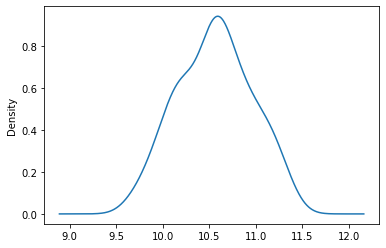

In [15]:
controlsDK.iloc[1].plot.kde()

In [16]:
pathways.head()

pathway_id                                  pathway_name  \
0  path:hsa00190                     Oxidative phosphorylation   
1  path:hsa00072    Synthesis and degradation of ketone bodies   
2  path:hsa01040       Biosynthesis of unsaturated fatty acids   
3  path:hsa04672  Intestinal immune network for IgA production   
4  path:hsa03460                        Fanconi anemia pathway   

                                               nodes  
0  64077;5464;245972;245973;479;513;514;515;516;5...  
1    64064;38;39;3155;56898;54511;622;3158;3157;5019  
2  641371;79966;6319;570;9415;3992;10965;122970;1...  
3  4055;8174;959;8741;3600;23308;102723407;6370;5...  
4  3280;378708;55120;672;84126;675;2189;83990;229...

# Preliminary definitions

In [11]:
@tf.function
def difference_of_edge_genes_embeddingGCN(edges,y_pred):
    #gene1 = tf.gather(y_pred,edges[0])
    #gene2 = tf.gather(y_pred,edges[1])
    gene1 = y_pred[0][edges[0]]
    gene2 = y_pred[0][edges[1]]
    return tf.sqrt(tf.reduce_sum(tf.square(gene1 - gene2)) + 1.0e-12)

tfControls = tf.constant(controlsDK,tf.float32)
#difference_of_edge_genes_embedding(tensorEdgesTest[3],tfControls)

In [12]:
## TESTING the computation of c
def testC(gene1,gene2,inList,outList):
    source1AdjSet = outList[str(gene1)]
    source2AdjSet = outList[str(gene2)]
    source1PredSet = inList[str(gene1)]
    source2PredSet = inList[str(gene2)]
    #c = (len(source1AdjSet) + len(source1PredSet) + len(source2AdjSet) + len(source2PredSet) -
    #     (len(source1AdjSet.union(source2AdjSet)) + len(source1PredSet.union(source2PredSet) ))) 
    #c = ( (len(source1AdjSet.union(source2AdjSet)) + len(source1PredSet.union(source2PredSet) )) + 
         #abs(len(source1AdjSet)-len(source2AdjSet)) + abs(len(source1PredSet)-len(source2PredSet)) )
    c = (len(source1AdjSet.intersection(source2AdjSet)) + len(source1PredSet.intersection(source2PredSet) ))/(abs(len(source1AdjSet)-len(source2AdjSet)) + abs(len(source1PredSet)-len(source2PredSet)) + 1.0 ) +0.01
    return c
testC(3640,6013,inAdjacencyListMetapathways,outAdjacencyListMetapathways)

4.01

In [13]:
def precomputeCostantsTensor(tensorEdges,inAdjacencyListMetapathways,outAdjacencyListMetapathways,divider):
    constantsList = []
    for i in range(0,tensorEdges.shape[0]):
        c = testC(tensorEdges[i][0].numpy(),
                tensorEdges[i][1].numpy(),inAdjacencyListMetapathways,outAdjacencyListMetapathways) / divider
        constantsList.append(c)
    return constantsList,tf.constant(constantsList,tf.float32)

In [14]:

@tf.function( experimental_relax_shapes=True)
def difference_of_genes_embedding_weightedGCN(node1,node2,y_pred,c):
    # dividing by max degree to get a small value could be a better option
    gene1 = y_pred[0][node1]
    gene2 = y_pred[0][node2]
    return c*tf.sqrt(tf.reduce_sum(tf.square(gene1 - gene2)) + 1.0e-12)


@tf.function
def difference_of_genes_embeddingGCN(node1,node2,y_pred):
    # dividing by max degree to get a small value could be a better option
    gene1 = y_pred[0][node1]
    gene2 = y_pred[0][node2]
    tmp = tf.sqrt(tf.reduce_sum(tf.square(gene1 - gene2)) + 1.0e-12)
    return tmp

# loss = tf.constant(0,tf.float32)
# for row in range(0,tensorEdgesTest.shape[0]):
#     c = testC(tensorEdges[row][0].numpy(),
#               tensorEdges[row][1].numpy(),inAdjacencyListMetapathways,outAdjacencyListMetapathways)
#     loss = loss + difference_of_genes_embedding_weighted(tensorEdgesTest[row][0].numpy(),tensorEdgesTest[row][0].numpy(),tfControls,c)
# loss

The loss function used to train the GCN and the GRAPHSAGE models is the following:

$\mathcal{L}=\sum\limits_{(x,y)\in E}c(x,y)||z_x - z_y||_2$

where $z_u$ is the embedding for gene _u_

The weight for every edge is defined in the following two ways:

- $c(x,y)=\frac{|K_v|+|K_u|+|J_v|+|J_u|-(|K_v\vee K_u|+|J_v\vee J_u|)}{max(\text{in-out degree})}$ 
- $c(x,y)=\frac{abs(|K_v|-|K_u|)+abs(|J_v|-|J_u|)+(|K_v\vee K_u|+|J_v\vee J_u|)}{max(\text{in-out degree})}$

Where $K_i$ is the set of the predecessors of i (in edges), while $J_i$ are the successors of i (out edges).

The second weight definition takes into account not only the neighborhood of the two nodes(with the union of the two sets) but also the structure of the nodes(how many predecessors and how many successors), so we will be using that one.

 **TODO** improve the model and build a more performant loss function.

In [15]:

    
@tf.function
def genes_loss(y_true, y_pred, edges):
    loss = tf.constant(0, tf.float32)
    #partials = tf.map_fn(lambda edge: difference_of_edge_genes_embedding(edge,y_pred),  tensorEdgesTest)  
    for row in edges:
        loss = loss + difference_of_edge_genes_embeddingGCN(row,y_pred)
    return loss
    #return tf.reduce_sum(partials)

#@tf.function
def genes_loss_with_closure(edges):
    def loss_out(y_true, y_pred):
        loss = tf.constant(0, tf.float32)
        #partials = tf.map_fn(lambda edge: difference_of_edge_genes_embedding(edge,y_pred),  tensorEdgesTest)  
        for row in edges:
            loss = loss + difference_of_edge_genes_embeddingGCN(row,y_pred)
        return loss
    return loss_out


def genes_loss_with_closure_weighted(edges,inAdjacencyListMetapathways,outAdjacencyListMetapathways):
    def loss_out(y_true, y_pred):
        loss = tf.constant(0, tf.float32)
        #partials = tf.map_fn(lambda edge: difference_of_edge_genes_embedding(edge,y_pred),  tensorEdgesTest)  
        for row in range(0,edges.shape[0]):
            c = testC(edges[row][0],edges[row][1],inAdjacencyListMetapathways,outAdjacencyListMetapathways)
            loss = loss + difference_of_edge_genes_embedding_weightedGCN(edges[row],y_pred,c)
        return loss
    return loss_out


def optimized_loss(tensorEdgesTest,tfControls,constantTensor):
    test1 = tf.map_fn(lambda edge:difference_of_genes_embedding(edge[0],edge[1],tfControls),tensorEdgesTest,fn_output_signature=tf.float32)
    test2 = tf.math.multiply(test1,constantTensor) 
    return tf.reduce_sum(test2 )

def optimized_loss(tensorEdgesTest,constantTensor):
    @tf.function
    def loss_out(y_true, y_pred):
        test1 = tf.map_fn(lambda edge:difference_of_genes_embeddingGCN(edge[0],edge[1],y_pred),tensorEdgesTest,fn_output_signature=tf.float32)
        test2 = tf.math.multiply(test1,constantTensor) 
        return tf.reduce_sum(test2 )
    return loss_out
#optimized_loss(tensorEdgesTest,tfControls,constantTensor)
        
    
#genes_loss(0,tfControls,tensorEdgesTest)

#genes_loss_with_closure(tensorEdgesTest)(0,tfControls)

#genes_loss_with_closure_weighted(tensorEdges,inAdjacencyListMetapathways,outAdjacencyListMetapathways)(0,tfControls)

In [16]:
@tf.function
def difference_of_edge_genes_embeddingGRAPHSAGE(edges,y_pred):
    #gene1 = tf.gather(y_pred,edges[0])
    #gene2 = tf.gather(y_pred,edges[1])
    gene1 = y_pred[edges[0]]
    gene2 = y_pred[edges[1]]
    return tf.sqrt(tf.reduce_sum(tf.square(gene1 - gene2)) + 1.0e-12)

#@tf.function
def genes_loss_with_closure(edges):
    def loss_out(y_true, y_pred):
        loss = tf.constant(0, tf.float32)
        #partials = tf.map_fn(lambda edge: difference_of_edge_genes_embedding(edge,y_pred),  tensorEdgesTest)  
        for row in edges:
            loss = loss + difference_of_edge_genes_embeddingGRAPHSAGE(row,y_pred)
        return loss
    return loss_out

#@tf.function
def testLoss(edge):
    def loss_out(y_true, y_pred):
        gene1 = y_pred[edge[0]]
        gene2 = y_pred[edge[1]]
        return tf.sqrt(tf.reduce_sum(tf.square(gene1 - gene2)) + 1.0e-12)
    return loss_out

def optimized_lossGNN(tensorEdgesTest,constantTensor):
    @tf.function
    def loss_out(y_true, y_pred): 
        return tf.reduce_sum(tf.math.multiply(tf.map_fn(lambda edge:difference_of_edge_genes_embeddingGRAPHSAGE(edge,y_pred),tensorEdgesTest,fn_output_signature=tf.float32),constantTensor) )
    return loss_out



#test_gen = generator.flow(test_subjects.index, test_subjects)


# Gene embeddings for controls 

In [75]:
graphWithFeatures = sg.StellarGraph(controlsDK ,geneEdges )
directedGraph = sg.StellarDiGraph(controlsDK ,geneEdges)
print(graphWithFeatures.info())

StellarGraph: Undirected multigraph
 Nodes: 17129, Edges: 19947

 Node types:
  default: [17129]
    Features: float32 vector, length 113
    Edge types: default-default->default

 Edge types:
    default-default->default: [19947]
        Weights: range=[-1, 1], mean=0.629318, std=0.777168
        Features: none


In [16]:
train_subjects, test_subjects = model_selection.train_test_split(
    controlsDK, train_size=int(controlsDK.shape[0] / 6.0 *5), test_size=None
)
val_subjects, test_subjects = model_selection.train_test_split(
    test_subjects, train_size=int(test_subjects.shape[0] / 5.0 *2), test_size=None
)

In [17]:
generator = FullBatchNodeGenerator(graphWithFeatures, method="gcn")

Using GCN (local pooling) filters...


In [18]:
#train_gen = generator.flow(train_subjects.index, train_subjects)
#test_gen = generator.flow(test_subjects.index, test_subjects)
#val_gen = generator.flow(val_subjects.index, val_subjects)
#no test or validation set
train_gen = generator.flow(controlsDK.index,controlsDK)

Embeddings generated have the same number of features as the number of patients

In [19]:
gcn = GCN(
    layer_sizes=[16, 16], activations=["relu", "relu"], generator=generator, dropout=0.5
)

In [20]:
x_inp, x_out = gcn.in_out_tensors()
x_out

<KerasTensor: shape=(1, None, 16) dtype=float32 (created by layer 'gather_indices')>

In [21]:
#predictions = layers.Dense(units=train_subjects.shape[1], activation="softmax")(x_out)
predictions = layers.Dense(controlsDK.shape[1], kernel_initializer='normal')(x_out)

In [76]:
indexOfGenes = dict()

for i in range(0,len(controlsDK.index)):
    indexOfGenes[controlsDK.index[i]] = i

tensorEdges = tf.constant(geneEdges,tf.int32)
tensorEdgesTest = tf.map_fn(lambda row: tf.map_fn(lambda element:indexOfGenes[element.numpy()],tf.gather(row, [0, 1]).numpy()) ,tensorEdges)  # take only edges with no weight
#tensorEdgesTest

In [23]:
inAdjacencyListMetapathways["51289"]

{'10022', '117579', '3640', '6013', '6019'}

In [63]:
@tf.function
def combine(x, y):
  xx, yy = tf.meshgrid(x, y, indexing='ij')
  return tf.stack([tf.reshape(xx, [-1]), tf.reshape(yy, [-1])], axis=1)
testPairs = combine(tf.constant(list(controlsDK.index)),tf.constant(list(controlsDK.index)))

In [31]:
testPairsList = tf.split(testPairs,2447,axis=0)
testPairsList[0]

<tf.Tensor: shape=(119903, 2), dtype=int32, numpy=
array([[        1,         1],
       [        1,         2],
       [        1,         9],
       ...,
       [       14, 100302692],
       [       14, 100302736],
       [       14, 100303728]])>

Dividing in batch because my GPU memory is not enough

In [28]:
#testgene1 = tfControls[0]
#testgene2 = tfControls[3]
#tf.sqrt(tf.reduce_sum(tf.square(testgene1 - testgene2)) + 1.0e-12)
indexGeneEdgesWithFeatures[tensorEdgesTest[0][0].numpy()]

3640

In [77]:
maxDegree = 0
for gene in list(controlsDK.index):
    if(len(inAdjacencyListMetapathways[str(gene)]) + len(outAdjacencyListMetapathways[str(gene)]) > maxDegree):
        maxDegree = len(inAdjacencyListMetapathways[str(gene)]) + len(outAdjacencyListMetapathways[str(gene)])

precompConstantList,constantTensor = precomputeCostantsTensor(tensorEdges,inAdjacencyListMetapathways,outAdjacencyListMetapathways,maxDegree)
constantTensor

<tf.Tensor: shape=(19947,), dtype=float32, numpy=
array([1.4577259e-05, 3.6664016e-05, 3.6334364e-05, ..., 1.4577259e-05,
       1.4577259e-05, 1.4577259e-05], dtype=float32)>

For the loss functions, the gene is taken by indexing the 0 position of the input parameter(that is a tensor of [1,nrows,ncols]) to get the expression matrix, and then indexing the row to get the gene expression over all patients

In [25]:
#tensor_edges = Input(shape=tensorEdgesTest.shape, name='tensor_edges')
#x = Input(shape=x_inp.shape, name='x')
#y = Input(shape=x_out.shape, name='y')
#model = Model(inputs=[x_inp, y ,tensor_edges] , outputs=predictions)
#model.add_loss( genes_loss( x_out, predictions, tensorEdgesTest ) )
model = Model(inputs=x_inp , outputs=predictions)

model.compile(
    optimizer=optimizers.Adam(learning_rate=0.01),
    #loss=genes_loss_with_closure_weighted(edges=tensorEdgesTest,inAdjacencyListMetapathways=inAdjacencyListMetapathways,outAdjacencyListMetapathways=outAdjacencyListMetapathways),
    loss = optimized_loss(tensorEdgesTest=tensorEdgesTest,constantTensor=constantTensor),
    metrics=["acc"])

In [26]:
es_callback = EarlyStopping(monitor="val_acc", patience=50, restore_best_weights=True)

In [27]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(1, 17129, 113)]    0           []                               
                                                                                                  
 input_3 (InputLayer)           [(1, None, 2)]       0           []                               
                                                                                                  
 input_4 (InputLayer)           [(1, None)]          0           []                               
                                                                                                  
 dropout (Dropout)              (1, 17129, 113)      0           ['input_1[0][0]']                
                                                                                              


$\sum\limits_{x\in V}\sum\limits_{y\in V}c ||z_x - z_y|_2$

In [28]:
checkpointPath = "model_checkpoints/adamGenes.ckpt"
checkpointDir = os.path.dirname(checkpointPath)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpointPath,
                                                 save_weights_only=True,
                                                 verbose=1)

model.load_weights(checkpointPath)

In [68]:
history = model.fit(
    train_gen,
    epochs=5,
    #validation_data=val_gen,
    batch_size=controlsDK.shape[0],
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    callbacks=[cp_callback]
)

Epoch 1/5

Epoch 1: saving model to model_checkpoints/adamGenes.ckpt
1/1 - 24s - loss: 8.3557 - acc: 0.0185 - 24s/epoch - 24s/step
Epoch 2/5

Epoch 2: saving model to model_checkpoints/adamGenes.ckpt
1/1 - 23s - loss: 9.3559 - acc: 0.0183 - 23s/epoch - 23s/step
Epoch 3/5

Epoch 3: saving model to model_checkpoints/adamGenes.ckpt
1/1 - 24s - loss: 4.1912 - acc: 0.0184 - 24s/epoch - 24s/step
Epoch 4/5

Epoch 4: saving model to model_checkpoints/adamGenes.ckpt
1/1 - 24s - loss: 4.2901 - acc: 0.0192 - 24s/epoch - 24s/step
Epoch 5/5

Epoch 5: saving model to model_checkpoints/adamGenes.ckpt
1/1 - 23s - loss: 10.9572 - acc: 0.0187 - 23s/epoch - 23s/step


In [166]:
model.save_weights(checkpointPath.format(epoch=0))

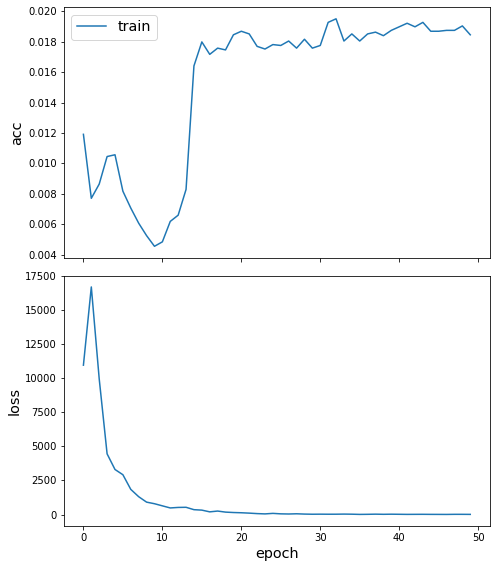

In [42]:
sg.utils.plot_history(history)

In [29]:
test_metrics = model.evaluate(train_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 7s 7s/step - loss: 0.0059 - acc: 0.0194

Test Set Metrics:
	loss: 0.0059
	acc: 0.0194


## prediction for genes of controls (GCN)

In [31]:
all_mapper = generator.flow(controlsDK.index)
all_predictions = model.predict(all_mapper)
all_predictions = all_predictions.astype("float64")

genesEmbeddings = pd.DataFrame(all_predictions[0], index =controlsDK.index,columns =controlsDK.columns)

In [32]:
genesEmbeddings

TCGA-E2-A1L7-11A-33R-A144-07  TCGA-BH-A0BC-11A-22R-A089-07  \
1                              0.004692                     -0.019996   
2                              0.004692                     -0.019996   
9                              0.004692                     -0.019996   
10                             0.004692                     -0.019996   
12                             0.004692                     -0.019996   
...                                 ...                           ...   
100302401                      0.003171                     -0.022571   
100302640                      0.004692                     -0.019996   
100302692                      0.004692                     -0.019996   
100302736                      0.004692                     -0.019996   
100303728                      0.004692                     -0.019996   

           TCGA-E9-A1N9-11A-71R-A14D-07  TCGA-BH-A18P-11A-43R-A12D-07  \
1                              0.036509                      0.038886   
2                              0.036509                      0.038886   
9                              0.036509                      0.038886   
10                             0.036509                      0.038886   
12                             0.036509                      0.038886   
...                                 ...                           ...   
100302401                      0.039229                      0.039760   
100302640                      0.036509                      0.038886   
100302692                      0.036509                      0.038886   
100302736                      0.036509                      0.038886   
100303728                      0.036509                      0.038886   

           TCGA-BH-A1FB-11A-33R-A13Q-07  TCGA-E9-A1RB-11A-33R-A157-07  \
1                             -0.058539                      0.034009   
2                             -0.058539                      0.034009   
9                             -0.058539                      0.034009   
10                            -0.058539                      0.034009   
12                            -0.058539                      0.034009   
...                                 ...                           ...   
100302401                     -0.058792                      0.035916   
100302640                     -0.058539                      0.034009   
100302692                     -0.058539                      0.034009   
100302736                     -0.058539                      0.034009   
100303728                     -0.058539                      0.034009   

           TCGA-BH-A1EO-11A-31R-A137-07  TCGA-GI-A2C8-11A-22R-A16F-07  \
1                             -0.013628                      0.087353   
2                             -0.013628                      0.087353   
9                             -0.013628                      0.087353   
10                            -0.013628                      0.087353   
12                            -0.013628                      0.087353   
...                                 ...                           ...   
100302401                     -0.014336                      0.084949   
100302640                     -0.013628                      0.087353   
100302692                     -0.013628                      0.087353   
100302736                     -0.013628                      0.087353   
100303728                     -0.013628                      0.087353   

           TCGA-E9-A1NA-11A-33R-A144-07  TCGA-BH-A0H9-11A-22R-A466-07  ...  \
1                             -0.047503                     -0.000832  ...   
2                             -0.047503                     -0.000832  ...   
9                             -0.047503                     -0.000832  ...   
10                            -0.047503                     -0.000832  ...   
12                            -0.047503                     -0.000832  ...   
...                                

<AxesSubplot:>

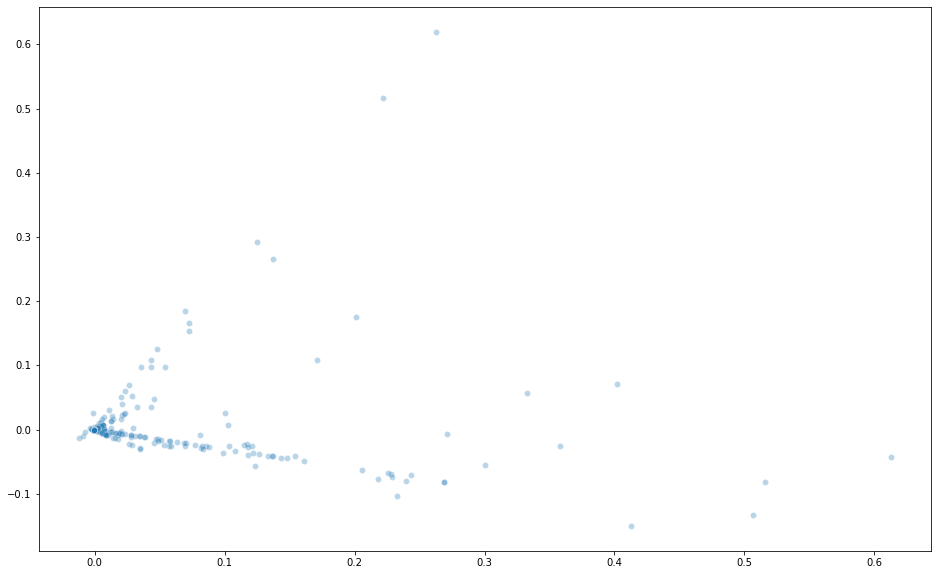

In [33]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(genesEmbeddings)
firstDim = pca_result[:,0]
secondDim = pca_result[:,1] 
thirdDim = pca_result[:,2]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=firstDim, y=secondDim,
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.3
)

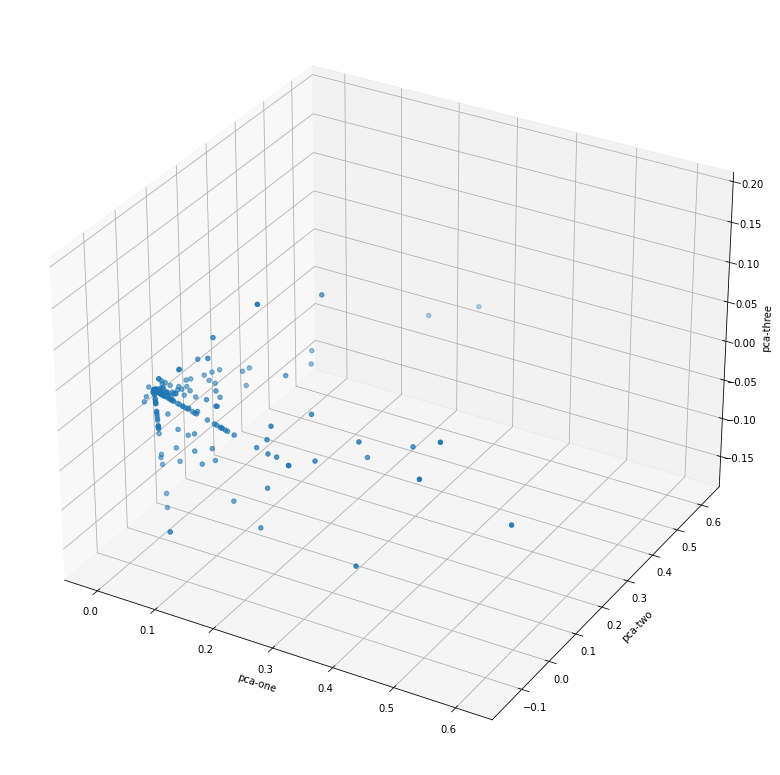

In [34]:
ax = plt.figure(figsize=(16,14)).gca(projection='3d')
ax.scatter(
    xs=firstDim, 
    ys=secondDim, 
    zs=thirdDim, 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

## GRAPHSAGE (controls)

10 nodes in the first layer(5 in and 5 out) and 4 nodes in the second layer

In [73]:
batch_size = controlsDK.shape[0]
in_samples = [5, 2]
out_samples = [5, 2]
batch_size

17129

In [78]:
generator = DirectedGraphSAGENodeGenerator(directedGraph, batch_size, in_samples, out_samples)

In [79]:
#train_gen = generator.flow(train_subjects.index, train_subjects)
#val_gen = generator.flow(val_subjects.index, val_subjects)
trainGen = generator.flow(controlsDK.index, controlsDK)

graphsage_model = DirectedGraphSAGE(
    layer_sizes=[32, 32], generator=generator, bias=False, dropout=0.5,
)

x_inp, x_out = graphsage_model.in_out_tensors()
prediction = layers.Dense(units=controlsDK.shape[1], activation="softmax")(x_out)

In [80]:
model = Model(inputs=x_inp, outputs=prediction)
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.005),
    loss=optimized_lossGNN(tensorEdgesTest=tensorEdgesTest,constantTensor=constantTensor),
    #loss=genes_loss_with_closure(edges=tensorEdgesTest),
    #loss = testLoss([0,1]),
    metrics=["acc"]
)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_30 (InputLayer)          [(None, 5, 113)]     0           []                               
                                                                                                  
 input_31 (InputLayer)          [(None, 5, 113)]     0           []                               
                                                                                                  
 input_32 (InputLayer)          [(None, 10, 113)]    0           []                               
                                                                                                  
 input_33 (InputLayer)          [(None, 10, 113)]    0           []                               
                                                                                            

In [81]:
checkpointPath = "model_checkpoints/GRAPHSAGEcontrolsGenes.ckpt"
checkpointDir = os.path.dirname(checkpointPath)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpointPath,
                                                 save_weights_only=True,
                                                 verbose=1)


model.load_weights(checkpointPath)

In [32]:
history = model.fit(
    trainGen, epochs=50, 
    #validation_data=test_gen,
    batch_size=batch_size,
    verbose=2, 
    shuffle=False,
    callbacks=[cp_callback]
)

Epoch 1/50

Epoch 1: saving model to model_checkpoints/GRAPHSAGEcontrolsGenes.ckpt
1/1 - 27s - loss: 0.1331 - acc: 0.0074 - 27s/epoch - 27s/step
Epoch 2/50

Epoch 2: saving model to model_checkpoints/GRAPHSAGEcontrolsGenes.ckpt
1/1 - 24s - loss: 0.1119 - acc: 0.0076 - 24s/epoch - 24s/step
Epoch 3/50

Epoch 3: saving model to model_checkpoints/GRAPHSAGEcontrolsGenes.ckpt
1/1 - 25s - loss: 0.1012 - acc: 0.0061 - 25s/epoch - 25s/step
Epoch 4/50

Epoch 4: saving model to model_checkpoints/GRAPHSAGEcontrolsGenes.ckpt
1/1 - 25s - loss: 0.0809 - acc: 0.0056 - 25s/epoch - 25s/step
Epoch 5/50

Epoch 5: saving model to model_checkpoints/GRAPHSAGEcontrolsGenes.ckpt
1/1 - 25s - loss: 0.0713 - acc: 0.0051 - 25s/epoch - 25s/step
Epoch 6/50

Epoch 6: saving model to model_checkpoints/GRAPHSAGEcontrolsGenes.ckpt
1/1 - 25s - loss: 0.0679 - acc: 0.0051 - 25s/epoch - 25s/step
Epoch 7/50

Epoch 7: saving model to model_checkpoints/GRAPHSAGEcontrolsGenes.ckpt
1/1 - 24s - loss: 0.0759 - acc: 0.0058 - 24s/ep

In [33]:
model.save_weights(checkpointPath.format(epoch=0))

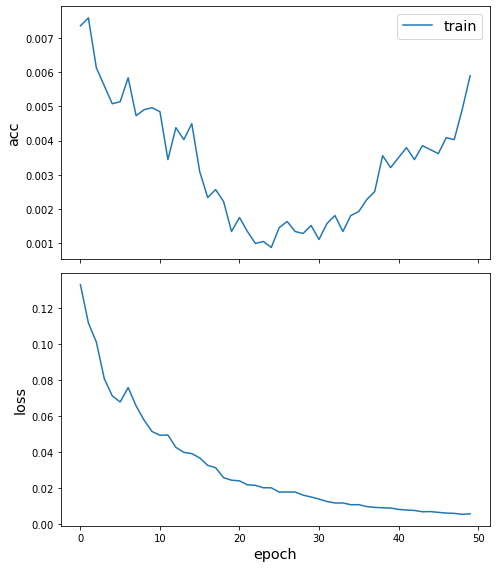

In [34]:
sg.utils.plot_history(history)

## prediction for genes of controls (GRAPHSAGE)

In [82]:
all_mapper = generator.flow(controlsDK.index)
all_predictions = model.predict(all_mapper)
all_predictions = all_predictions.astype("float64")

genesEmbeddings = pd.DataFrame(all_predictions, index =controlsDK.index)

In [83]:
genesEmbeddings.to_csv("genesEmbedding/genesEmbeddingsControl")

Column names are only **indicative**, they are not the patients since these features are the embeddings.

<AxesSubplot:>

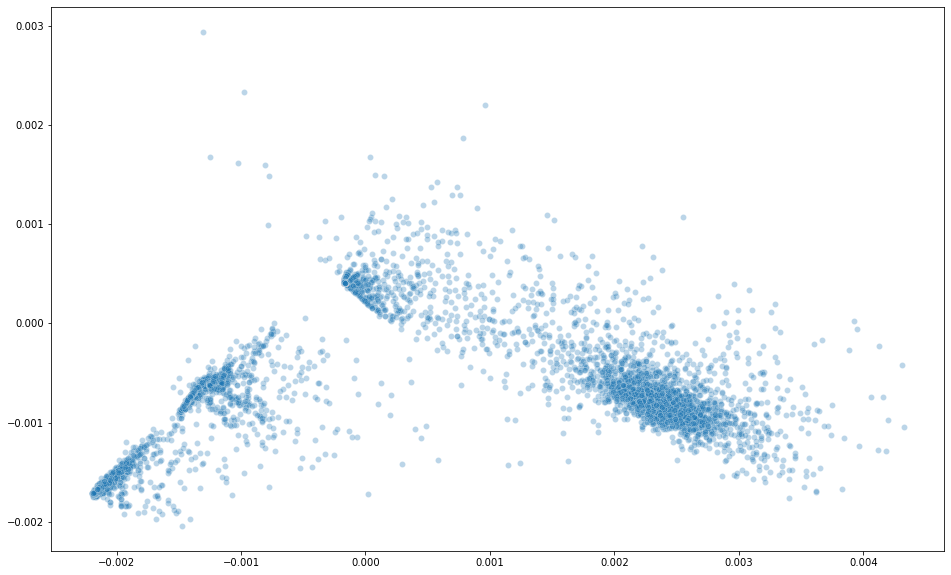

In [84]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(genesEmbeddings)
firstDim = pca_result[:,0]
secondDim = pca_result[:,1] 
thirdDim = pca_result[:,2]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=firstDim, y=secondDim,
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.3
)

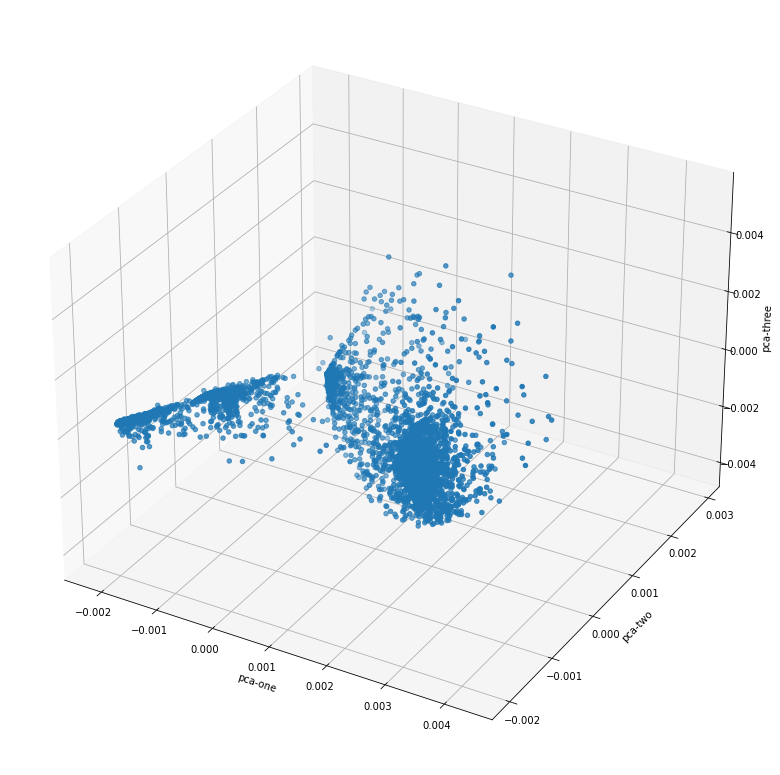

In [85]:
ax = plt.figure(figsize=(16,14)).gca(projection='3d')
ax.scatter(
    xs=firstDim, 
    ys=secondDim, 
    zs=thirdDim, 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

# Genes embeddings for Tumors

### preliminary steps

In [17]:
indexOfGenesTumor = dict()

for i in range(0,len(tumorDKfull.index)):
    indexOfGenesTumor[tumorDKfull.index[i]] = i

tensorEdgesTumor = tf.constant(geneEdgesTumor,tf.int32)
tensorEdgesTestTumor = tf.map_fn(lambda row: tf.map_fn(lambda element:indexOfGenesTumor[element.numpy()],tf.gather(row, [0, 1]).numpy()) ,tensorEdgesTumor)  # take only edges with no weight

**using the full dataset for the constant vector used in the loss function for both the reduced dataset(with less columns) and the full dataset since the final product is the same**

In [18]:
tfTumor = tf.constant(tumorDK,tf.float32)
#difference_of_edge_genes_embedding(tensorEdgesTest[3],tfControls)
maxDegreeTumor = 0

for gene in list(tumorDK.index):
    if(len(inAdjacencyListMetapathways[str(gene)]) + len(outAdjacencyListMetapathways[str(gene)]) > maxDegreeTumor):
        maxDegreeTumor = len(inAdjacencyListMetapathways[str(gene)]) + len(outAdjacencyListMetapathways[str(gene)])

precompConstantListTumor,constantTensorTumor = precomputeCostantsTensor(tensorEdgesTumor,inAdjacencyListMetapathways,outAdjacencyListMetapathways,maxDegreeTumor)
constantTensorTumor

<tf.Tensor: shape=(17264,), dtype=float32, numpy=
array([4.4326767e-05, 1.4577259e-05, 1.4577259e-05, ..., 1.4577259e-05,
       1.4577259e-05, 1.4577259e-05], dtype=float32)>

### true embeddings for all patients tumor

In [35]:
graphTumorWithFeatures = sg.StellarGraph(tumorDKfull ,geneEdgesTumor )
print(graphTumorWithFeatures.info())

StellarGraph: Undirected multigraph
 Nodes: 19727, Edges: 17264

 Node types:
  default: [19727]
    Features: float32 vector, length 1082
    Edge types: default-default->default

 Edge types:
    default-default->default: [17264]
        Weights: range=[-1, 1], mean=0.68165, std=0.7317
        Features: none


In [36]:
generatorTumor = FullBatchNodeGenerator(graphTumorWithFeatures, method="gcn")
trainGenTumor = generatorTumor.flow(tumorDKfull.index,tumorDKfull)
gcnTumor = GCN(
    layer_sizes=[16, 16], activations=["relu", "relu"], generator=generatorTumor, dropout=0.5
)

Using GCN (local pooling) filters...


In [37]:
x_inpTumor, x_outTumor = gcnTumor.in_out_tensors()
predictionsTumorFull = layers.Dense(tumorDKfull.shape[1], kernel_initializer='normal')(x_outTumor)

In [41]:
modelTumor = Model(inputs=x_inpTumor , outputs=predictionsTumorFull)

modelTumor.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    #loss=genes_loss_with_closure_weighted(edges=tensorEdgesTest,inAdjacencyListMetapathways=inAdjacencyListMetapathways,outAdjacencyListMetapathways=outAdjacencyListMetapathways),
    loss = optimized_loss(tensorEdgesTest=tensorEdgesTestTumor,constantTensor=constantTensorTumor),
    metrics=["acc"])

In [42]:
modelTumor.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(1, 19727, 1082)]   0           []                               
                                                                                                  
 input_7 (InputLayer)           [(1, None, 2)]       0           []                               
                                                                                                  
 input_8 (InputLayer)           [(1, None)]          0           []                               
                                                                                                  
 dropout_2 (Dropout)            (1, 19727, 1082)     0           ['input_5[0][0]']                
                                                                                            

In [43]:
checkpointPathTumor = "model_checkpoints/adamGenesTumor.ckpt"
checkpointDirTumor = os.path.dirname(checkpointPathTumor)

# Create a callback that saves the model's weights
cp_callbackTumor = tf.keras.callbacks.ModelCheckpoint(filepath=checkpointPathTumor,
                                                 save_weights_only=True,
                                                 verbose=1)

modelTumor.load_weights(checkpointPathTumor)

In [103]:
historyTumor = modelTumor.fit(
    trainGenTumor,
    epochs=10,
    #validation_data=val_gen,
    batch_size=tumorDKfull.shape[0],
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    callbacks=[cp_callbackTumor]
)

Epoch 1/10

Epoch 1: saving model to model_checkpoints/adamGenesTumor.ckpt
1/1 - 113s - loss: 48.7121 - acc: 3.0415e-04 - 113s/epoch - 113s/step
Epoch 2/10

Epoch 2: saving model to model_checkpoints/adamGenesTumor.ckpt
1/1 - 113s - loss: 16.3105 - acc: 4.0554e-04 - 113s/epoch - 113s/step
Epoch 3/10

Epoch 3: saving model to model_checkpoints/adamGenesTumor.ckpt
1/1 - 112s - loss: 18.2850 - acc: 1.0138e-04 - 112s/epoch - 112s/step
Epoch 4/10

Epoch 4: saving model to model_checkpoints/adamGenesTumor.ckpt
1/1 - 113s - loss: 17.8057 - acc: 2.5346e-04 - 113s/epoch - 113s/step
Epoch 5/10

Epoch 5: saving model to model_checkpoints/adamGenesTumor.ckpt
1/1 - 113s - loss: 25.7509 - acc: 2.0277e-04 - 113s/epoch - 113s/step
Epoch 6/10

Epoch 6: saving model to model_checkpoints/adamGenesTumor.ckpt
1/1 - 113s - loss: 22.5953 - acc: 4.0554e-04 - 113s/epoch - 113s/step
Epoch 7/10

Epoch 7: saving model to model_checkpoints/adamGenesTumor.ckpt
1/1 - 113s - loss: 23.7553 - acc: 2.5346e-04 - 113s/epo

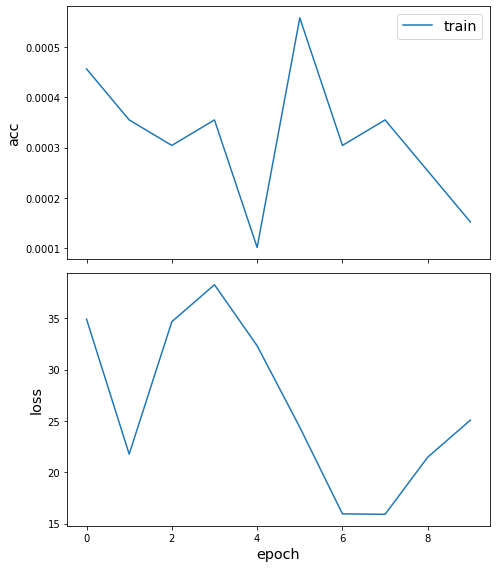

In [126]:
modelTumor.save_weights(checkpointPathTumor.format(epoch=0))
sg.utils.plot_history(historyTumor)

## prediction for genes of tumors (GCN)

In [45]:
all_mapper = generatorTumor.flow(tumorDKfull.index)
all_predictions = modelTumor.predict(all_mapper)
all_predictions = all_predictions.astype("float64")

genesEmbeddingsTumor = pd.DataFrame(all_predictions[0], index =tumorDKfull.index,columns =tumorDKfull.columns)

In [46]:
genesEmbeddingsTumor

TCGA-3C-AAAU-01  TCGA-3C-AALI-01  TCGA-3C-AALJ-01  TCGA-3C-AALK-01  \
2             0.077756         0.024824        -0.013002        -0.034736   
3             0.077756         0.024824        -0.013002        -0.034736   
7             0.077756         0.024824        -0.013002        -0.034736   
8             0.077756         0.024824        -0.013002        -0.034736   
10            0.077756         0.024824        -0.013002        -0.034736   
...                ...              ...              ...              ...   
20526         0.077756         0.024824        -0.013002        -0.034736   
20527         0.077756         0.024824        -0.013002        -0.034736   
20528         0.077756         0.024824        -0.013002        -0.034736   
20529         0.077756         0.024824        -0.013002        -0.034736   
20530         0.077756         0.024824        -0.013002        -0.034736   

       TCGA-4H-AAAK-01  TCGA-5L-AAT0-01  TCGA-5T-A9QA-01  TCGA-A1-A0SB-01  \
2             0.055104         0.037664         0.052124          0.02696   
3             0.055104         0.037664         0.052124          0.02696   
7             0.055104         0.037664         0.052124          0.02696   
8             0.055104         0.037664         0.052124          0.02696   
10            0.055104         0.037664         0.052124          0.02696   
...                ...              ...              ...              ...   
20526         0.055104         0.037664         0.052124          0.02696   
20527         0.055104         0.037664         0.052124          0.02696   
20528         0.055104         0.037664         0.052124          0.02696   
20529         0.055104         0.037664         0.052124          0.02696   
20530         0.055104         0.037664         0.052124          0.02696   

       TCGA-A1-A0SD-01  TCGA-A1-A0SE-01  ...  TCGA-UL-AAZ6-01  \
2             0.012788        -0.045989  ...         0.025012   
3             0.012788        -0.045989  ...         0.025012   
7             0.012788        -0.045989  ...         0.025012   
8             0.012788        -0.045989  ...         0.025012   
10            0.012788        -0.045989  ...         0.025012   
...                ...              ...  ...              ...   
20526         0.012788        -0.045989  ...         0.025012   
20527         0.012788        -0.045989  ...         0.025012   
20528         0.012788        -0.045989  ...         0.025012   
20529         0.012788        -0.045989  ...         0.025012   
20530         0.012788        -0.045989  ...         0.025012   

       TCGA-UU-A93S-01  TCGA-V7-A7HQ-01  TCGA-W8-A86G-01  TCGA-WT-AB41-01  \
2             0.034019         0.027135         0.013607        -0.033031   
3             0.034019         0.027135         0.013607        -0.033031   
7             0.034019         0.027135         0.013607        -0.033031   
8             0.034019         0.027135         0.013607        -0.033031   
10            0.034019         0.027135         0.013607        -0.033031   
...                ...              ...              ...              ...   
20526         0.034019         0.027135         0.013607        -0.033031   
20527         0.034019         0.027135         0.013607        -0.033031   
20528         0.034019         0.027135         0.013607        -0.033031   
20529         0.034019         0.027135         0.013607        -0.033031   
20530         0.034019         0.027135         0.013607        -0.033031   

       TCGA-WT-AB44-01  TCGA-XX-A899-01  TCGA-XX-A89A-01  TCGA-Z7-A8R5-01  \
2            -0.013939        -0.051558        -0.083843        -0.013089   
3            -0.013939        -0.051558        -0.083843        -0.013089   
7            -0.013939        -0.051558        -0.083843        -0.013089   
8            -0.013939        -0.051558        -0.083843        -0.013089   
10           -0.013939        -0.051558        -0.083843        -0

<AxesSubplot:>

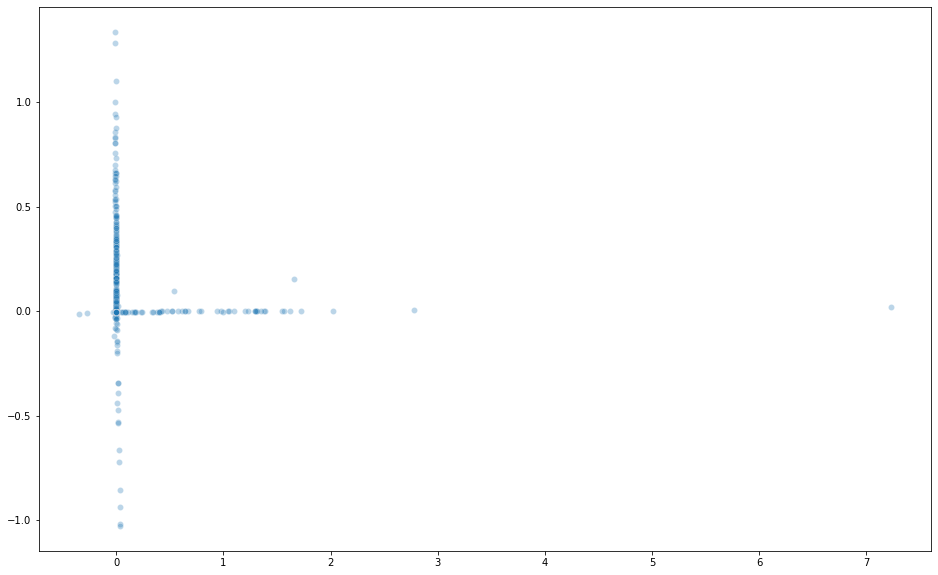

In [48]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(genesEmbeddingsTumor)
firstDim = pca_result[:,0]
secondDim = pca_result[:,1] 
thirdDim = pca_result[:,2]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=firstDim, y=secondDim,
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.3
)

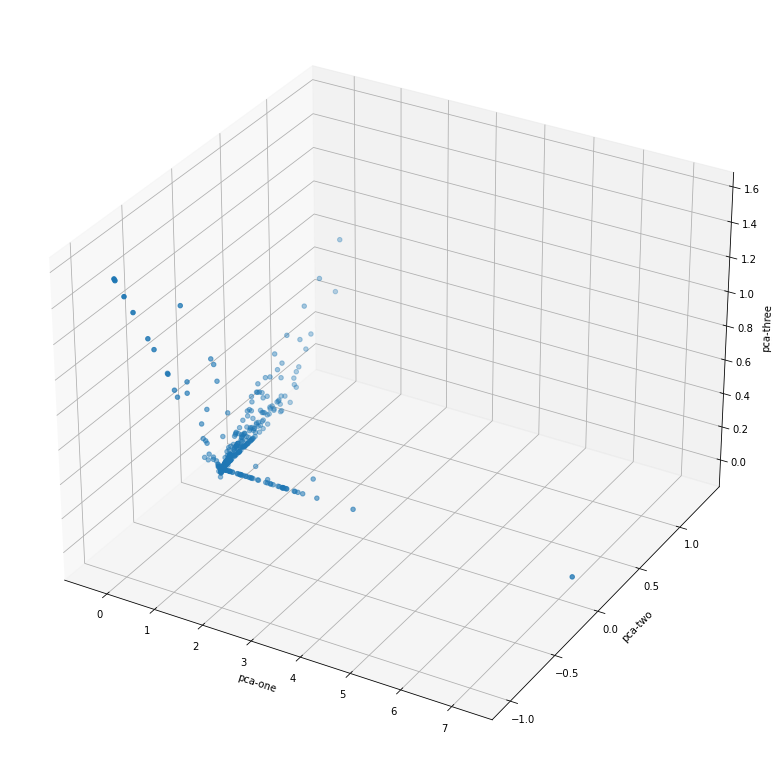

In [49]:
ax = plt.figure(figsize=(16,14)).gca(projection='3d')
ax.scatter(
    xs=firstDim, 
    ys=secondDim, 
    zs=thirdDim, 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

## GRAPHSAGE for tumors

In [19]:
directedGraphTumor = sg.StellarDiGraph(tumorDK ,geneEdgesTumor)
print(directedGraphTumor.info())

StellarDiGraph: Directed multigraph
 Nodes: 19727, Edges: 17264

 Node types:
  default: [19727]
    Features: float32 vector, length 390
    Edge types: default-default->default

 Edge types:
    default-default->default: [17264]
        Weights: range=[-1, 1], mean=0.68165, std=0.7317
        Features: none


In [42]:
batch_sizeTumor = int(tumorDK.shape[0])
#batch_sizeTumor = tumorDK.shape[0]
in_samples = [5, 2]
out_samples = [5, 2]
batch_sizeTumor

19727

In [43]:
generatorTumor = DirectedGraphSAGENodeGenerator(directedGraphTumor, batch_sizeTumor, in_samples, out_samples)

In [44]:
#train_gen = generator.flow(train_subjects.index, train_subjects)
#val_gen = generator.flow(val_subjects.index, val_subjects)
trainGenTumor = generatorTumor.flow(tumorDK.index, tumorDK)

graphsage_modelTumor = DirectedGraphSAGE(
    layer_sizes=[32, 32], generator=generatorTumor, bias=False, dropout=0.5,
)

x_inpTumor, x_outTumor = graphsage_modelTumor.in_out_tensors()
predictionTumor = layers.Dense(units=tumorDK.shape[1], activation="softmax")(x_outTumor)


In [45]:
modelTumor = Model(inputs=x_inpTumor, outputs=predictionTumor)
modelTumor.compile(
    optimizer=optimizers.Adam(learning_rate=0.005),
    loss=optimized_lossGNN(tensorEdgesTest=tensorEdgesTestTumor,constantTensor=constantTensorTumor),
    #loss=genes_loss_with_closure(edges=tensorEdgesTest),
    #loss = testLoss([0,1]),
    metrics=["acc"]
)

#test_gen = generator.flow(test_subjects.index, test_subjects)
modelTumor.summary()



Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 5, 390)]     0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, 5, 390)]     0           []                               
                                                                                                  
 input_11 (InputLayer)          [(None, 10, 390)]    0           []                               
                                                                                                  
 input_12 (InputLayer)          [(None, 10, 390)]    0           []                               
                                                                                            

In [46]:
checkpointPathTumor = "model_checkpoints/GRAPHSAGEtumorGenes.ckpt"
checkpointDirTumor = os.path.dirname(checkpointPathTumor)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpointPathTumor,
                                                 save_weights_only=True,
                                                 verbose=1)


#modelTumor.load_weights(checkpointPathTumor)

In [47]:
history = modelTumor.fit(
    trainGenTumor, epochs=50, 
    #validation_data=test_gen,
    batch_size=batch_sizeTumor,
    verbose=2, 
    shuffle=False,
    callbacks=[cp_callback]
)

Epoch 1/50

Epoch 1: saving model to model_checkpoints/GRAPHSAGEtumorGenes.ckpt
1/1 - 29s - loss: 0.0092 - acc: 0.0025 - 29s/epoch - 29s/step
Epoch 2/50

Epoch 2: saving model to model_checkpoints/GRAPHSAGEtumorGenes.ckpt
1/1 - 26s - loss: 0.0087 - acc: 0.0026 - 26s/epoch - 26s/step
Epoch 3/50

Epoch 3: saving model to model_checkpoints/GRAPHSAGEtumorGenes.ckpt
1/1 - 28s - loss: 0.0075 - acc: 0.0028 - 28s/epoch - 28s/step
Epoch 4/50

Epoch 4: saving model to model_checkpoints/GRAPHSAGEtumorGenes.ckpt
1/1 - 27s - loss: 0.0065 - acc: 0.0019 - 27s/epoch - 27s/step
Epoch 5/50

Epoch 5: saving model to model_checkpoints/GRAPHSAGEtumorGenes.ckpt
1/1 - 28s - loss: 0.0057 - acc: 0.0022 - 28s/epoch - 28s/step
Epoch 6/50

Epoch 6: saving model to model_checkpoints/GRAPHSAGEtumorGenes.ckpt
1/1 - 28s - loss: 0.0052 - acc: 0.0026 - 28s/epoch - 28s/step
Epoch 7/50

Epoch 7: saving model to model_checkpoints/GRAPHSAGEtumorGenes.ckpt
1/1 - 28s - loss: 0.0046 - acc: 0.0019 - 28s/epoch - 28s/step
Epoch 

In [48]:
modelTumor.save_weights(checkpointPathTumor.format(epoch=0))

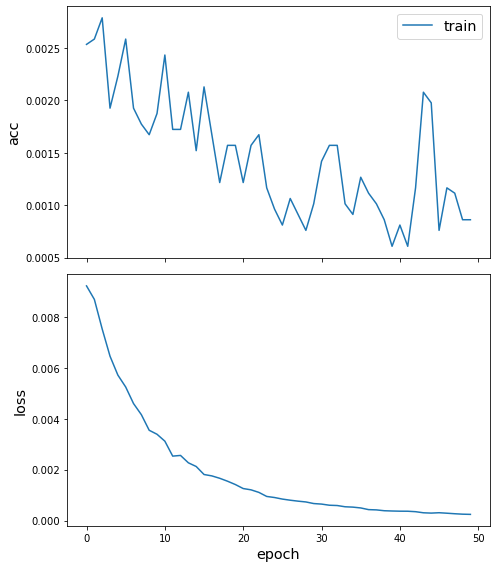

In [49]:
sg.utils.plot_history(history)

## prediction for genes of tumors

In [50]:
all_mapper = generatorTumor.flow(tumorDK.index)
all_predictions = modelTumor.predict(all_mapper)
all_predictions = all_predictions.astype("float64")

genesEmbeddingsTumor = pd.DataFrame(all_predictions, index =tumorDK.index,columns =tumorDK.columns)

In [51]:
genesEmbeddingsTumor

TCGA-A2-A1FX  TCGA-D8-A1XB  TCGA-BH-A0E1  TCGA-AQ-A04J  TCGA-BH-A0E9  \
2          0.002660      0.002772      0.002760      0.002250      0.002473   
3          0.002651      0.002782      0.002746      0.002272      0.002439   
7          0.002666      0.002773      0.002760      0.002254      0.002480   
8          0.002668      0.002772      0.002759      0.002255      0.002481   
10         0.002666      0.002771      0.002758      0.002255      0.002483   
...             ...           ...           ...           ...           ...   
20526      0.002648      0.002774      0.002758      0.002257      0.002473   
20527      0.002667      0.002772      0.002760      0.002255      0.002481   
20528      0.002671      0.002773      0.002760      0.002255      0.002481   
20529      0.002667      0.002772      0.002759      0.002255      0.002481   
20530      0.002666      0.002776      0.002764      0.002252      0.002481   

       TCGA-C8-A133  TCGA-B6-A0IG  TCGA-LL-A8F5  TCGA-E2-A14Q  TCGA-AR-A2LQ  \
2          0.002536      0.002290      0.002261      0.002823      0.002485   
3          0.002522      0.002335      0.002236      0.002835      0.002458   
7          0.002532      0.002281      0.002258      0.002824      0.002481   
8          0.002531      0.002281      0.002259      0.002824      0.002481   
10         0.002534      0.002278      0.002254      0.002828      0.002481   
...             ...           ...           ...           ...           ...   
20526      0.002542      0.002278      0.002237      0.002836      0.002476   
20527      0.002531      0.002281      0.002258      0.002824      0.002480   
20528      0.002529      0.002282      0.002262      0.002824      0.002480   
20529      0.002531      0.002282      0.002258      0.002825      0.002480   
20530      0.002533      0.002279      0.002261      0.002824      0.002478   

       ...  TCGA-A2-A0YI  TCGA-A2-A4S1  TCGA-A8-A07B  TCGA-AC-A5XS  \
2      ...      0.002392      0.002789      0.002362      0.002719   
3      ...      0.002405      0.002802      0.002377      0.002721   
7      ...      0.002391      0.002788      0.002351      0.002711   
8      ...      0.002392      0.002790      0.002350      0.002713   
10     ...      0.002396      0.002788      0.002350      0.002712   
...    ...           ...           ...           ...           ...   
20526  ...      0.002392      0.002781      0.002357      0.002709   
20527  ...      0.002392      0.002790      0.002352      0.002712   
20528  ...      0.002392      0.002792      0.002348      0.002715   
20529  ...      0.002393      0.002789      0.002351      0.002712   
20530  ...      0.002389      0.002791      0.002353      0.002712   

       TCGA-GM-A5PV  TCGA-A1-A0SI  TCGA-AC-A2BK  TCGA-OL-A5DA  TCGA-AR-A254  \
2          0.002388      0.002747      0.002722      0.002255      0.002526   
3          0.002401      0.002768      0.002696      0.002200      0.002557   
7          0.002382      0.002746      0.002732      0.002250      0.002523   
8          0.002382      0.002747      0.002732      0.002251      0.002523   
10         0.002386      0.002750      0.002730      0.002250      0.002519   
...             ...           ...           ...           ...           ...   
20526      0.002397      0.002758      0.002729      0.002234      0.002521   
20527      0.002382      0.002746      0.002732      0.002251      0.002523   
20528      0.002381      0.002747      0.002731      0.002251      0.002526   
20529      0.002383      0.002747      0.002731      0.002250      0.002523   
20530      0.002384      0.002743      0.002733      0.002252      0.002526   

       TCGA-B6-A0I9  
2          0.002586  
3          0.002618  
7          0.002584  
8          0.002586  
10         0.002587  
...             ...  
20526      0.002589  
20527      0.002586  
20528      0.002587  
20529      0.002586  
20530      0.002584  

[19727 rows x 390 columns]

As already said, column names are only **indicative**, they are not the patients since these features are the embeddings.

### visualizzazione dati di espressione

<AxesSubplot:>

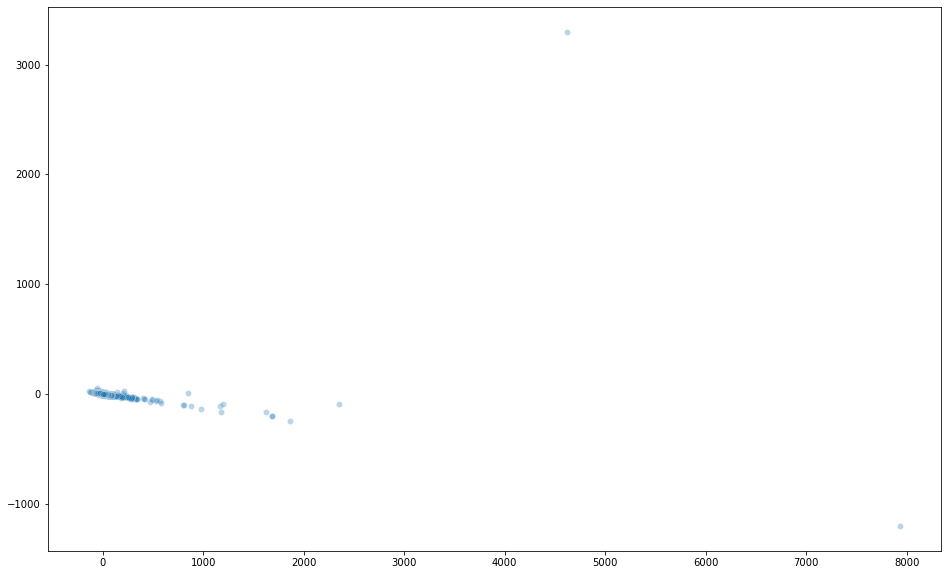

In [52]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(tumorDK)
firstDim = pca_result[:,0]
secondDim = pca_result[:,1] 
thirdDim = pca_result[:,2]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=firstDim, y=secondDim,
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.3
)

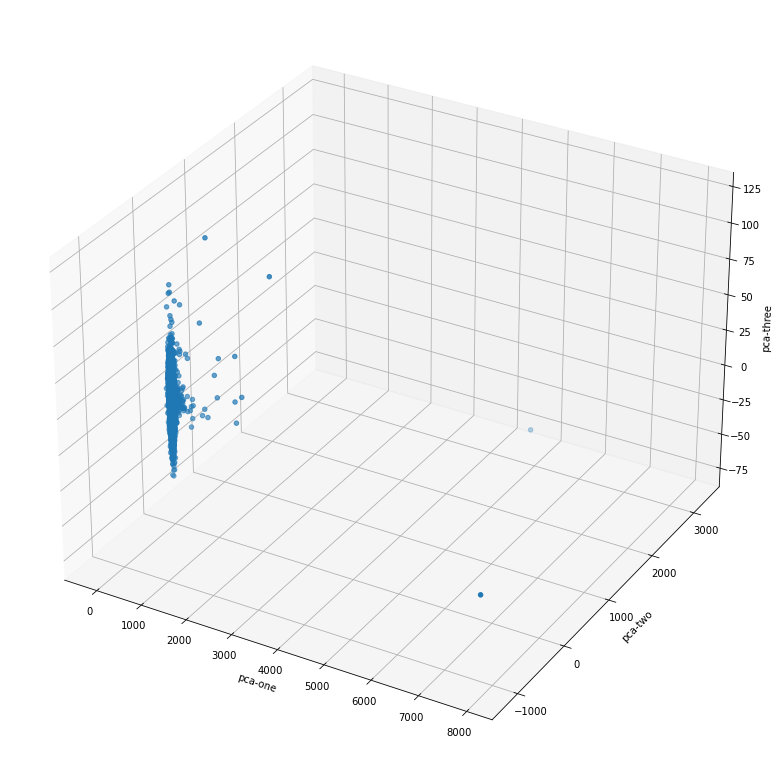

In [74]:
ax = plt.figure(figsize=(16,14)).gca(projection='3d')
ax.scatter(
    xs=firstDim, 
    ys=secondDim, 
    zs=thirdDim, 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

### visualizzazione embeddings

<AxesSubplot:>

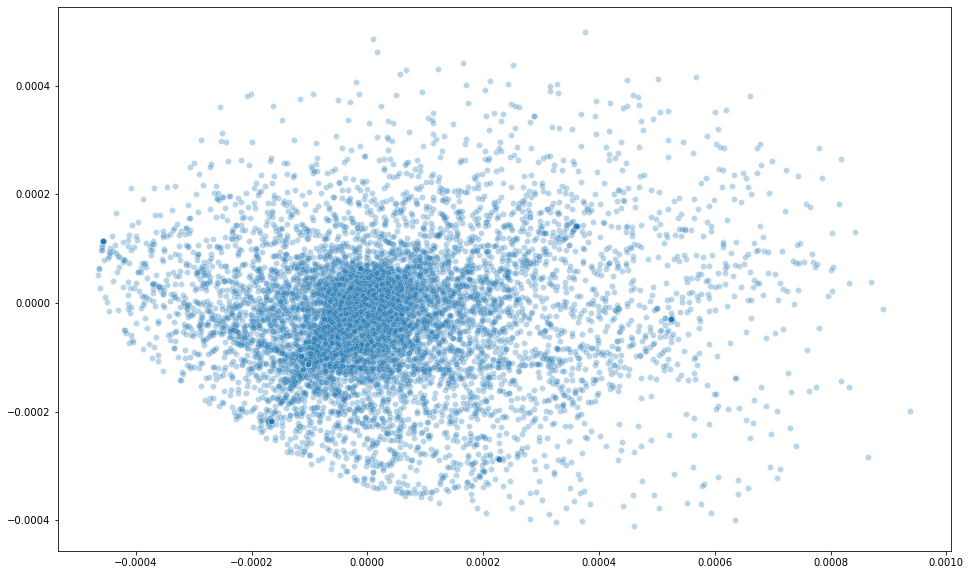

In [53]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(genesEmbeddingsTumor)
firstDim = pca_result[:,0]
secondDim = pca_result[:,1] 
thirdDim = pca_result[:,2]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=firstDim, y=secondDim,
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.3
)

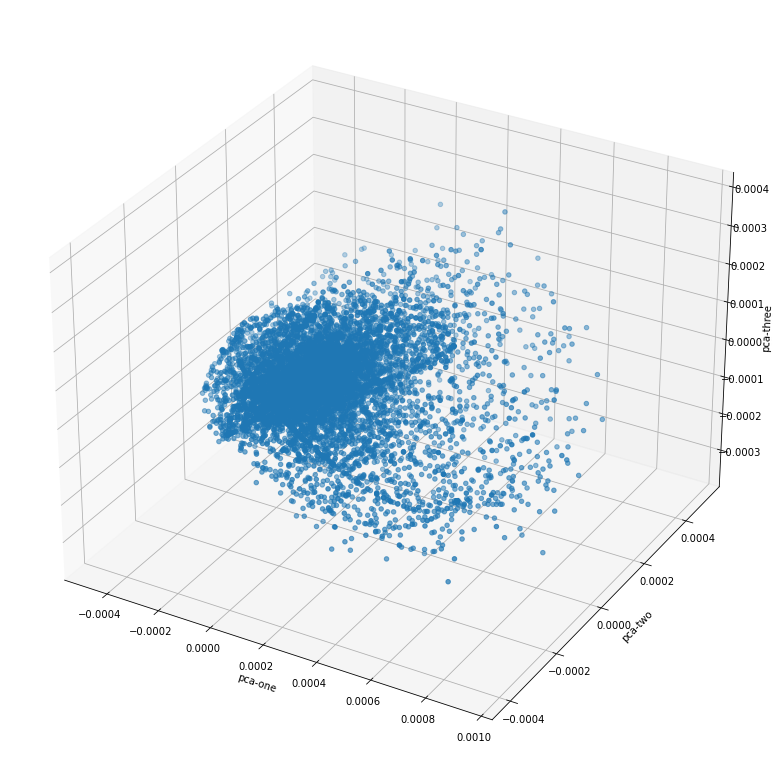

In [54]:
ax = plt.figure(figsize=(16,14)).gca(projection='3d')
ax.scatter(
    xs=firstDim, 
    ys=secondDim, 
    zs=thirdDim, 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

## GRAPHSAGE for tumors(same number of features as controls)

In [55]:
#tumorDKfinal = tumorDKfull.sample(n=controlsDK.shape[1], axis='columns', random_state=2)
tumorDKfinal = tumorDKfull.iloc[: , :controlsDK.shape[1]]
directedGraphTumorfinal = sg.StellarDiGraph(tumorDKfinal ,geneEdgesTumor)
print(directedGraphTumorfinal.info())

StellarDiGraph: Directed multigraph
 Nodes: 19727, Edges: 17264

 Node types:
  default: [19727]
    Features: float32 vector, length 113
    Edge types: default-default->default

 Edge types:
    default-default->default: [17264]
        Weights: range=[-1, 1], mean=0.68165, std=0.7317
        Features: none


In [56]:
batch_sizeTumor = int(tumorDKfinal.shape[0])
#batch_sizeTumor = tumorDK.shape[0]
in_samples = [5, 2]
out_samples = [5, 2]
batch_sizeTumor

19727

In [57]:
generatorTumorfinal = DirectedGraphSAGENodeGenerator(directedGraphTumorfinal, batch_sizeTumor, in_samples, out_samples)

In [58]:
#train_gen = generator.flow(train_subjects.index, train_subjects)
#val_gen = generator.flow(val_subjects.index, val_subjects)
trainGenTumorfinal = generatorTumorfinal.flow(tumorDKfinal.index, tumorDKfinal)

graphsage_modelTumorfinal = DirectedGraphSAGE(
    layer_sizes=[32, 32], generator=generatorTumorfinal, bias=False, dropout=0.5,
)

x_inpTumorfinal, x_outTumorfinal = graphsage_modelTumorfinal.in_out_tensors()
predictionTumorfinal = layers.Dense(units=tumorDKfinal.shape[1], activation="softmax")(x_outTumorfinal)


In [59]:
modelTumorfinal = Model(inputs=x_inpTumorfinal, outputs=predictionTumorfinal)
modelTumorfinal.compile(
    optimizer=optimizers.Adam(learning_rate=0.005),
    loss=optimized_lossGNN(tensorEdgesTest=tensorEdgesTestTumor,constantTensor=constantTensorTumor),
    #loss=genes_loss_with_closure(edges=tensorEdgesTest),
    #loss = testLoss([0,1]),
    metrics=["acc"]
)

#test_gen = generator.flow(test_subjects.index, test_subjects)
modelTumorfinal.summary()



Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 5, 113)]     0           []                               
                                                                                                  
 input_17 (InputLayer)          [(None, 5, 113)]     0           []                               
                                                                                                  
 input_18 (InputLayer)          [(None, 10, 113)]    0           []                               
                                                                                                  
 input_19 (InputLayer)          [(None, 10, 113)]    0           []                               
                                                                                            

In [42]:
checkpointPathTumorfinal = "model_checkpoints/GRAPHSAGEtumorGenes113Patients.ckpt"
checkpointDirTumorfinal = os.path.dirname(checkpointPathTumorfinal)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpointPathTumorfinal,
                                                 save_weights_only=True,
                                                 verbose=1)


modelTumorfinal.load_weights(checkpointPathTumorfinal)

In [119]:
history = modelTumorfinal.fit(
    trainGenTumorfinal, epochs=50, 
    #validation_data=test_gen,
    batch_size=batch_sizeTumor,
    verbose=2, 
    shuffle=False,
    callbacks=[cp_callback]
)

Epoch 1/50

Epoch 1: saving model to model_checkpoints/GRAPHSAGEtumorGenes113Patients.ckpt
1/1 - 15s - loss: 1.9562 - acc: 0.0068 - 15s/epoch - 15s/step
Epoch 2/50

Epoch 2: saving model to model_checkpoints/GRAPHSAGEtumorGenes113Patients.ckpt
1/1 - 15s - loss: 1.9475 - acc: 0.0050 - 15s/epoch - 15s/step
Epoch 3/50

Epoch 3: saving model to model_checkpoints/GRAPHSAGEtumorGenes113Patients.ckpt
1/1 - 15s - loss: 1.7388 - acc: 0.0034 - 15s/epoch - 15s/step
Epoch 4/50

Epoch 4: saving model to model_checkpoints/GRAPHSAGEtumorGenes113Patients.ckpt
1/1 - 16s - loss: 1.7063 - acc: 0.0034 - 16s/epoch - 16s/step
Epoch 5/50

Epoch 5: saving model to model_checkpoints/GRAPHSAGEtumorGenes113Patients.ckpt
1/1 - 16s - loss: 1.5977 - acc: 0.0033 - 16s/epoch - 16s/step
Epoch 6/50

Epoch 6: saving model to model_checkpoints/GRAPHSAGEtumorGenes113Patients.ckpt
1/1 - 15s - loss: 1.5195 - acc: 0.0032 - 15s/epoch - 15s/step
Epoch 7/50

Epoch 7: saving model to model_checkpoints/GRAPHSAGEtumorGenes113Patie

In [120]:
modelTumorfinal.save_weights(checkpointPathTumorfinal.format(epoch=0))

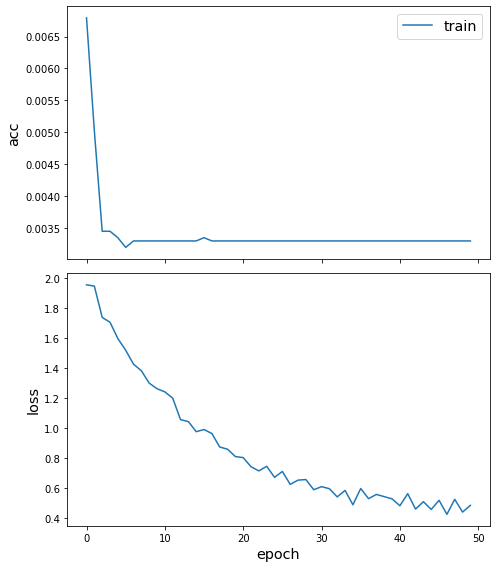

In [121]:
sg.utils.plot_history(history)

### generazione embedding per tumor con lo stesso numero di feature di control

In [43]:
all_mapper = generatorTumorfinal.flow(tumorDKfinal.index)
all_predictions = modelTumorfinal.predict(all_mapper)
all_predictions = all_predictions.astype("float64")

genesEmbeddingsTumorfinal = pd.DataFrame(all_predictions, index =tumorDKfinal.index,columns =tumorDKfinal.columns)

In [44]:
genesEmbeddingsTumorfinal

TCGA-3C-AAAU-01  TCGA-3C-AALI-01  TCGA-3C-AALJ-01  TCGA-3C-AALK-01  \
2             0.006832         0.006949         0.007543         0.006660   
3             0.006834         0.006957         0.007542         0.006666   
7             0.006835         0.006959         0.007541         0.006660   
8             0.006834         0.006959         0.007540         0.006660   
10            0.006835         0.006960         0.007540         0.006660   
...                ...              ...              ...              ...   
20526         0.006831         0.006956         0.007538         0.006660   
20527         0.006834         0.006959         0.007540         0.006660   
20528         0.006834         0.006960         0.007540         0.006660   
20529         0.006834         0.006959         0.007540         0.006660   
20530         0.006834         0.006959         0.007540         0.006660   

       TCGA-4H-AAAK-01  TCGA-5L-AAT0-01  TCGA-5T-A9QA-01  TCGA-A1-A0SB-01  \
2             0.009087         0.010477         0.010361         0.007585   
3             0.009085         0.010482         0.010368         0.007603   
7             0.009084         0.010472         0.010371         0.007585   
8             0.009085         0.010472         0.010372         0.007585   
10            0.009086         0.010473         0.010371         0.007587   
...                ...              ...              ...              ...   
20526         0.009084         0.010479         0.010368         0.007591   
20527         0.009085         0.010472         0.010371         0.007584   
20528         0.009086         0.010473         0.010371         0.007587   
20529         0.009085         0.010472         0.010372         0.007585   
20530         0.009084         0.010472         0.010372         0.007584   

       TCGA-A1-A0SD-01  TCGA-A1-A0SE-01  ...  TCGA-A2-A25F-01  \
2             0.006659         0.008082  ...         0.009688   
3             0.006662         0.008072  ...         0.009688   
7             0.006656         0.008076  ...         0.009693   
8             0.006655         0.008076  ...         0.009693   
10            0.006656         0.008075  ...         0.009692   
...                ...              ...  ...              ...   
20526         0.006658         0.008081  ...         0.009694   
20527         0.006655         0.008076  ...         0.009693   
20528         0.006656         0.008076  ...         0.009693   
20529         0.006655         0.008076  ...         0.009693   
20530         0.006655         0.008076  ...         0.009693   

       TCGA-A2-A3KC-01  TCGA-A2-A3KD-01  TCGA-A2-A3XS-01  TCGA-A2-A3XT-01  \
2             0.009826         0.007555         0.009018         0.010200   
3             0.009829         0.007539         0.009023         0.010202   
7             0.009835         0.007543         0.009019         0.010198   
8             0.009836         0.007543         0.009019         0.010199   
10            0.009835         0.007543         0.009020         0.010199   
...                ...              ...              ...              ...   
20526         0.009831         0.007548         0.009020         0.010200   
20527         0.009836         0.007544         0.009019         0.010198   
20528         0.009836         0.007543         0.009020         0.010199   
20529         0.009836         0.007544         0.009019         0.010198   
20530         0.009835         0.007544         0.009019         0.010198   

       TCGA-A2-A3XU-01  TCGA-A2-A3XV-01  TCGA-A2-A3XW-01  TCGA-A2-A3XX-01  \
2             0.009970         0.010301         0.010654         0.006951   
3             0.009974         0.010303         0.010653         0.006961   
7             0.009966         0.010302         0.010657         0.006955   
8             0.009966         0.010302         0.010657         0.006955   
10            0.009967         0.010302         0.010656         0

### visualizzazione embeddings (stesso numero di feature-pazienti di controls)

<AxesSubplot:>

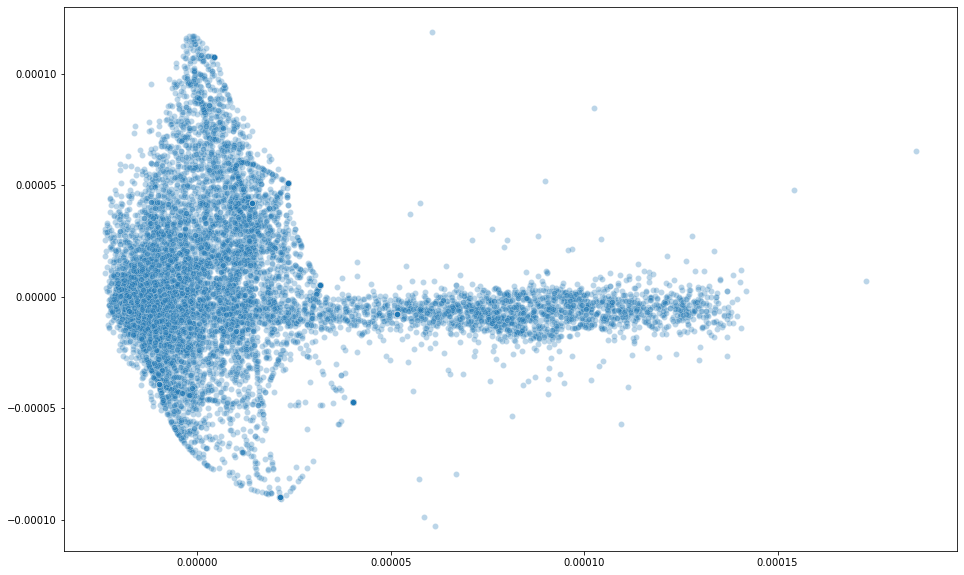

In [45]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(genesEmbeddingsTumorfinal)
firstDim = pca_result[:,0]
secondDim = pca_result[:,1] 
thirdDim = pca_result[:,2]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=firstDim, y=secondDim,
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.3
)

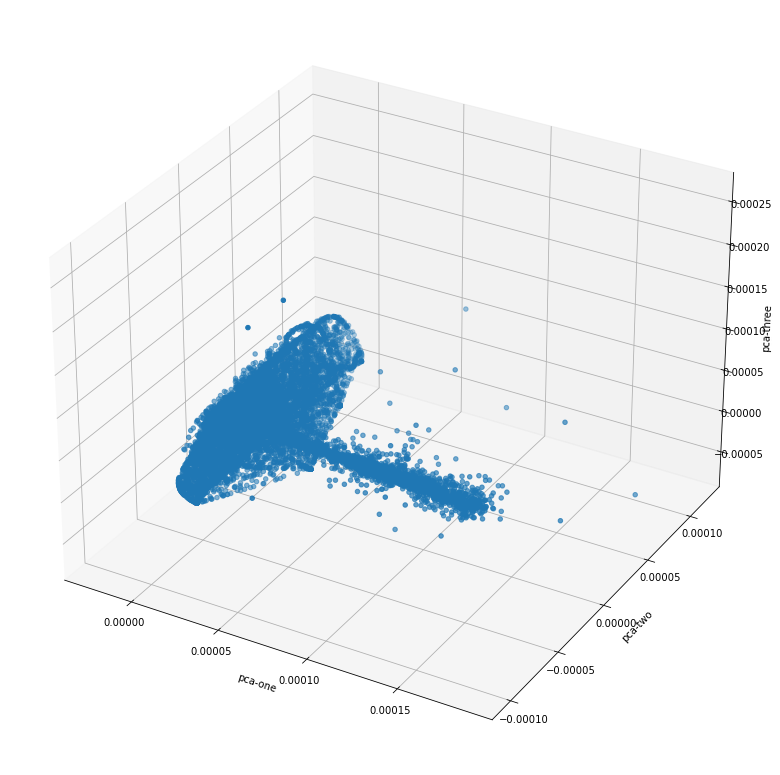

In [46]:
ax = plt.figure(figsize=(16,14)).gca(projection='3d')
ax.scatter(
    xs=firstDim, 
    ys=secondDim, 
    zs=thirdDim, 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

## Embeddings Graphsage for **Basal** tumors

In [20]:
directedGraphTumorBasal = sg.StellarDiGraph(basalExprMatrix ,geneEdgesTumor)
print(directedGraphTumorBasal.info())

StellarDiGraph: Directed multigraph
 Nodes: 19727, Edges: 17264

 Node types:
  default: [19727]
    Features: float32 vector, length 171
    Edge types: default-default->default

 Edge types:
    default-default->default: [17264]
        Weights: range=[-1, 1], mean=0.68165, std=0.7317
        Features: none


In [21]:
batch_sizeTumor = int(tumorDK.shape[0])
#batch_sizeTumor = tumorDK.shape[0]
in_samples = [5, 2]
out_samples = [5, 2]
batch_sizeTumor

19727

In [22]:
generatorTumorBasal = DirectedGraphSAGENodeGenerator(directedGraphTumorBasal, batch_sizeTumor, in_samples, out_samples)

In [23]:
#train_gen = generator.flow(train_subjects.index, train_subjects)
#val_gen = generator.flow(val_subjects.index, val_subjects)
trainGenTumorfinal = generatorTumorBasal.flow(tumorDK.index, tumorDK)

graphsage_modelTumorfinal = DirectedGraphSAGE(
    layer_sizes=[32, 32], generator=generatorTumorBasal, bias=False, dropout=0.5,
)

x_inpTumorfinal, x_outTumorfinal = graphsage_modelTumorfinal.in_out_tensors()
predictionTumorfinal = layers.Dense(units=basalExprMatrix.shape[1], activation="softmax")(x_outTumorfinal)


In [24]:
modelTumorfinal = Model(inputs=x_inpTumorfinal, outputs=predictionTumorfinal)
modelTumorfinal.compile(
    optimizer=optimizers.Adam(learning_rate=0.005),
    loss=optimized_lossGNN(tensorEdgesTest=tensorEdgesTestTumor,constantTensor=constantTensorTumor),
    #loss=genes_loss_with_closure(edges=tensorEdgesTest),
    #loss = testLoss([0,1]),
    metrics=["acc"]
)

#test_gen = generator.flow(test_subjects.index, test_subjects)
modelTumorfinal.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 5, 171)]     0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 5, 171)]     0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 10, 171)]    0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 10, 171)]    0           []                               
                                                                                              

In [28]:
checkpointPathTumorfinal = "model_checkpoints/GRAPHSAGEtumorGenesBasal.ckpt"
checkpointDirTumorfinal = os.path.dirname(checkpointPathTumorfinal)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpointPathTumorfinal,
                                                 save_weights_only=True,
                                                 verbose=1)


modelTumorfinal.load_weights(checkpointPathTumorfinal)

In [139]:
history = modelTumorfinal.fit(
    trainGenTumorfinal, epochs=50, 
    #validation_data=test_gen,
    batch_size=batch_sizeTumor,
    verbose=2, 
    shuffle=False,
    callbacks=[cp_callback]
)

Epoch 1/50

Epoch 1: saving model to model_checkpoints/GRAPHSAGEtumorGenesBasal.ckpt
1/1 - 74s - loss: 49.2269 - acc: 0.0068 - 74s/epoch - 74s/step
Epoch 2/50

Epoch 2: saving model to model_checkpoints/GRAPHSAGEtumorGenesBasal.ckpt
1/1 - 74s - loss: 44.9268 - acc: 0.0066 - 74s/epoch - 74s/step
Epoch 3/50

Epoch 3: saving model to model_checkpoints/GRAPHSAGEtumorGenesBasal.ckpt
1/1 - 80s - loss: 40.5904 - acc: 0.0073 - 80s/epoch - 80s/step
Epoch 4/50

Epoch 4: saving model to model_checkpoints/GRAPHSAGEtumorGenesBasal.ckpt
1/1 - 83s - loss: 37.1797 - acc: 0.0067 - 83s/epoch - 83s/step
Epoch 5/50

Epoch 5: saving model to model_checkpoints/GRAPHSAGEtumorGenesBasal.ckpt
1/1 - 83s - loss: 33.6647 - acc: 0.0056 - 83s/epoch - 83s/step
Epoch 6/50

Epoch 6: saving model to model_checkpoints/GRAPHSAGEtumorGenesBasal.ckpt
1/1 - 83s - loss: 30.4873 - acc: 0.0065 - 83s/epoch - 83s/step
Epoch 7/50

Epoch 7: saving model to model_checkpoints/GRAPHSAGEtumorGenesBasal.ckpt
1/1 - 84s - loss: 27.2234 -

In [140]:
modelTumorfinal.save_weights(checkpointPathTumorfinal.format(epoch=0))

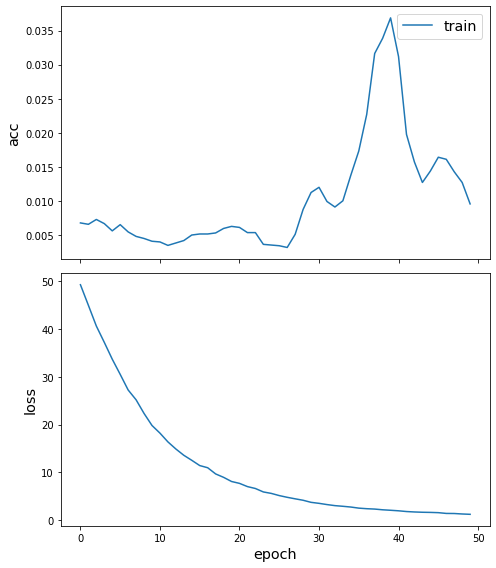

In [141]:
sg.utils.plot_history(history)

### generazione embedding per tumor Basal

In [29]:
all_mapper = generatorTumorBasal.flow(basalExprMatrix.index)
all_predictions = modelTumorfinal.predict(all_mapper)
all_predictions = all_predictions.astype("float64")

genesEmbeddingsTumorBasal = pd.DataFrame(all_predictions, index =basalExprMatrix.index,columns =basalExprMatrix.columns)

In [30]:
genesEmbeddingsTumorBasal

TCGA-A1-A0SK  TCGA-A1-A0SO  TCGA-A1-A0SP  TCGA-A2-A04P  TCGA-A2-A04Q  \
2          0.005930      0.005155      0.005080      0.006354      0.006509   
3          0.005907      0.005103      0.005061      0.006328      0.006505   
7          0.005903      0.005144      0.005078      0.006355      0.006518   
8          0.005904      0.005143      0.005076      0.006352      0.006520   
10         0.005902      0.005143      0.005083      0.006358      0.006518   
...             ...           ...           ...           ...           ...   
20526      0.005872      0.005147      0.005073      0.006342      0.006521   
20527      0.005905      0.005144      0.005076      0.006352      0.006519   
20528      0.005916      0.005137      0.005091      0.006346      0.006511   
20529      0.005904      0.005145      0.005078      0.006355      0.006518   
20530      0.005901      0.005143      0.005077      0.006356      0.006518   

       TCGA-A2-A04T  TCGA-A2-A04U  TCGA-A2-A0CM  TCGA-A2-A0D0  TCGA-A2-A0D2  \
2          0.004767      0.006098      0.005971      0.006384      0.004998   
3          0.004734      0.006104      0.005979      0.006378      0.004989   
7          0.004769      0.006107      0.005986      0.006363      0.005007   
8          0.004770      0.006106      0.005984      0.006364      0.005005   
10         0.004754      0.006106      0.005971      0.006370      0.005002   
...             ...           ...           ...           ...           ...   
20526      0.004738      0.006109      0.005996      0.006382      0.005013   
20527      0.004771      0.006105      0.005986      0.006363      0.005005   
20528      0.004766      0.006095      0.005968      0.006368      0.005000   
20529      0.004769      0.006106      0.005986      0.006362      0.005007   
20530      0.004765      0.006107      0.005985      0.006363      0.005006   

       ...  TCGA-OL-A5D7  TCGA-OL-A5RW  TCGA-OL-A5S0  TCGA-OL-A66I  \
2      ...      0.005626      0.005052      0.006507      0.004909   
3      ...      0.005651      0.005080      0.006515      0.004874   
7      ...      0.005628      0.005066      0.006496      0.004886   
8      ...      0.005626      0.005068      0.006496      0.004886   
10     ...      0.005633      0.005061      0.006486      0.004896   
...    ...           ...           ...           ...           ...   
20526  ...      0.005611      0.005051      0.006503      0.004879   
20527  ...      0.005626      0.005068      0.006497      0.004886   
20528  ...      0.005617      0.005058      0.006514      0.004876   
20529  ...      0.005629      0.005066      0.006496      0.004886   
20530  ...      0.005631      0.005066      0.006495      0.004886   

       TCGA-OL-A6VO  TCGA-PL-A8LV  TCGA-PL-A8LZ  TCGA-S3-AA0Z  TCGA-S3-AA10  \
2          0.006336      0.006100      0.004766      0.006507      0.005241   
3          0.006354      0.006123      0.004782      0.006513      0.005232   
7          0.006322      0.006109      0.004776      0.006508      0.005241   
8          0.006319      0.006108      0.004777      0.006508      0.005240   
10         0.006300      0.006073      0.004801      0.006510      0.005239   
...             ...           ...           ...           ...           ...   
20526      0.006349      0.006121      0.004796      0.006523      0.005213   
20527      0.006320      0.006110      0.004773      0.006508      0.005242   
20528      0.006310      0.006100      0.004783      0.006501      0.005249   
20529      0.006321      0.006109      0.004776      0.006508      0.005241   
20530      0.006323      0.006108      0.004780      0.006508      0.005238   

       TCGA-S3-AA15  
2          0.006061  
3          0.006100  
7          0.006091  
8          0.006088  
10         0.006069  
...             ...  
20526      0.006105  
20527      0.006088  
20528      0.006091  
20529      0.006091  
20530      0.006094  

[19727 rows x 171 columns]

### visualizzazione embeddings (stesso numero di feature-pazienti di controls)

<AxesSubplot:>

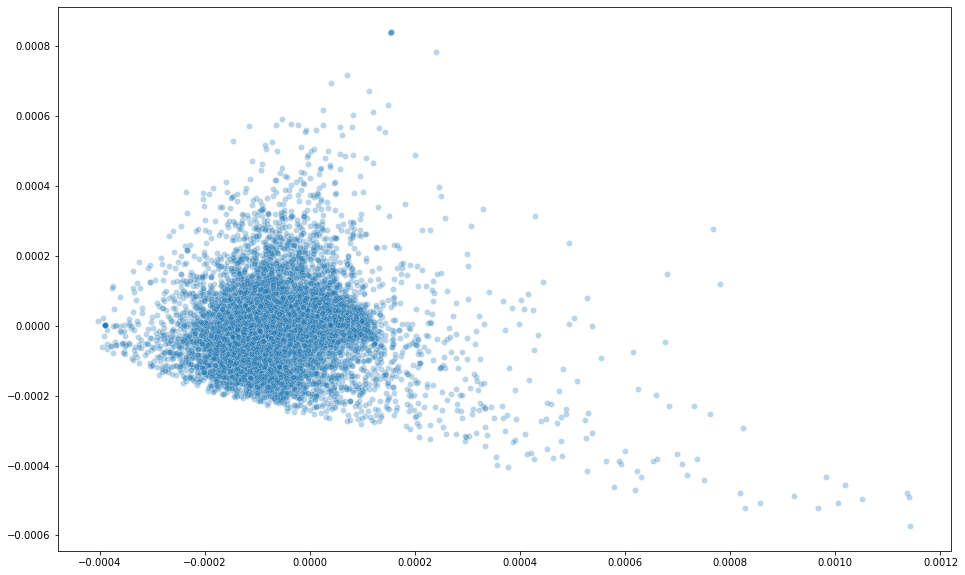

In [146]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(genesEmbeddingsTumorBasal)
firstDim = pca_result[:,0]
secondDim = pca_result[:,1] 
thirdDim = pca_result[:,2]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=firstDim, y=secondDim,
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.3
)

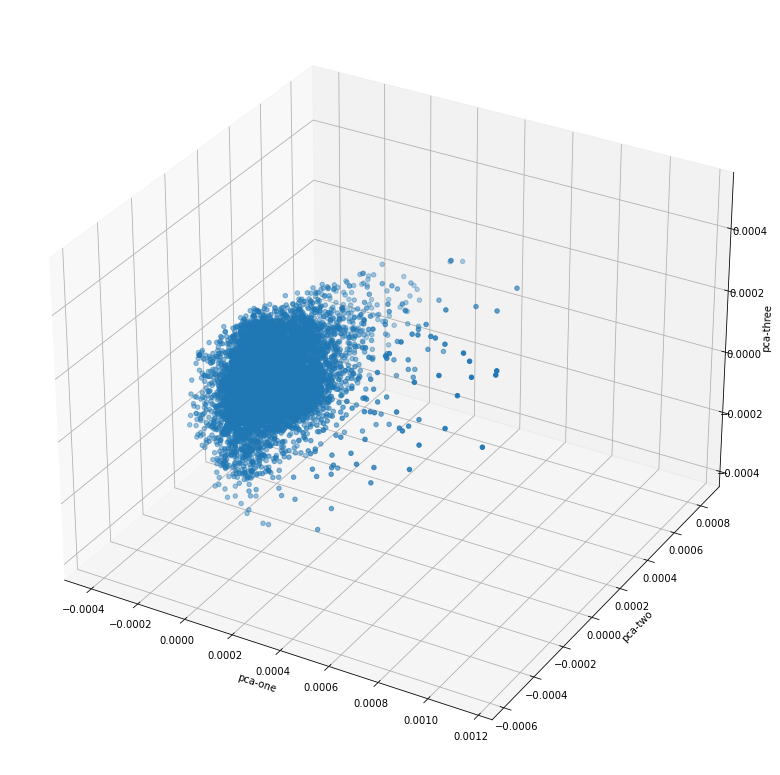

In [147]:
ax = plt.figure(figsize=(16,14)).gca(projection='3d')
ax.scatter(
    xs=firstDim, 
    ys=secondDim, 
    zs=thirdDim, 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

## Embeddings Graphsage for **Basal** tumors (113 patients)

In [25]:
basalExprMatrixShort = basalExprMatrix.iloc[:,:controlsDK.shape[1]]
directedGraphTumorBasal = sg.StellarDiGraph(basalExprMatrixShort ,geneEdgesTumor)
print(directedGraphTumorBasal.info())

StellarDiGraph: Directed multigraph
 Nodes: 19727, Edges: 17264

 Node types:
  default: [19727]
    Features: float32 vector, length 113
    Edge types: default-default->default

 Edge types:
    default-default->default: [17264]
        Weights: range=[-1, 1], mean=0.68165, std=0.7317
        Features: none


In [26]:
batch_sizeTumor = int(tumorDK.shape[0])
#batch_sizeTumor = tumorDK.shape[0]
in_samples = [5, 2]
out_samples = [5, 2]
batch_sizeTumor

19727

In [27]:
generatorTumorBasal = DirectedGraphSAGENodeGenerator(directedGraphTumorBasal, batch_sizeTumor, in_samples, out_samples)

In [28]:
#train_gen = generator.flow(train_subjects.index, train_subjects)
#val_gen = generator.flow(val_subjects.index, val_subjects)
trainGenTumorfinal = generatorTumorBasal.flow(tumorDK.index, tumorDK)

graphsage_modelTumorfinal = DirectedGraphSAGE(
    layer_sizes=[32, 32], generator=generatorTumorBasal, bias=False, dropout=0.5,
)

x_inpTumorfinal, x_outTumorfinal = graphsage_modelTumorfinal.in_out_tensors()
predictionTumorfinal = layers.Dense(units=basalExprMatrixShort.shape[1], activation="softmax")(x_outTumorfinal)


In [29]:
modelTumorfinal = Model(inputs=x_inpTumorfinal, outputs=predictionTumorfinal)
modelTumorfinal.compile(
    optimizer=optimizers.Adam(learning_rate=0.005),
    loss=optimized_lossGNN(tensorEdgesTest=tensorEdgesTestTumor,constantTensor=constantTensorTumor),
    #loss=genes_loss_with_closure(edges=tensorEdgesTest),
    #loss = testLoss([0,1]),
    metrics=["acc"]
)

#test_gen = generator.flow(test_subjects.index, test_subjects)
modelTumorfinal.summary()



Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 5, 113)]     0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, 5, 113)]     0           []                               
                                                                                                  
 input_11 (InputLayer)          [(None, 10, 113)]    0           []                               
                                                                                                  
 input_12 (InputLayer)          [(None, 10, 113)]    0           []                               
                                                                                            

In [30]:
checkpointPathTumorfinal = "model_checkpoints/GRAPHSAGEtumorGenesBasal113.ckpt"
checkpointDirTumorfinal = os.path.dirname(checkpointPathTumorfinal)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpointPathTumorfinal,
                                                 save_weights_only=True,
                                                 verbose=1)


modelTumorfinal.load_weights(checkpointPathTumorfinal)

In [66]:
history = modelTumorfinal.fit(
    trainGenTumorfinal, epochs=50, 
    #validation_data=test_gen,
    batch_size=batch_sizeTumor,
    verbose=2, 
    shuffle=False,
    callbacks=[cp_callback]
)

Epoch 1/50

Epoch 1: saving model to model_checkpoints/GRAPHSAGEtumorGenesBasal113.ckpt
1/1 - 19s - loss: 0.0321 - acc: 0.0100 - 19s/epoch - 19s/step
Epoch 2/50

Epoch 2: saving model to model_checkpoints/GRAPHSAGEtumorGenesBasal113.ckpt
1/1 - 19s - loss: 0.0293 - acc: 0.0087 - 19s/epoch - 19s/step
Epoch 3/50

Epoch 3: saving model to model_checkpoints/GRAPHSAGEtumorGenesBasal113.ckpt
1/1 - 19s - loss: 0.0253 - acc: 0.0094 - 19s/epoch - 19s/step
Epoch 4/50

Epoch 4: saving model to model_checkpoints/GRAPHSAGEtumorGenesBasal113.ckpt
1/1 - 18s - loss: 0.0259 - acc: 0.0095 - 18s/epoch - 18s/step
Epoch 5/50

Epoch 5: saving model to model_checkpoints/GRAPHSAGEtumorGenesBasal113.ckpt
1/1 - 16s - loss: 0.0221 - acc: 0.0089 - 16s/epoch - 16s/step
Epoch 6/50

Epoch 6: saving model to model_checkpoints/GRAPHSAGEtumorGenesBasal113.ckpt
1/1 - 17s - loss: 0.0209 - acc: 0.0089 - 17s/epoch - 17s/step
Epoch 7/50

Epoch 7: saving model to model_checkpoints/GRAPHSAGEtumorGenesBasal113.ckpt
1/1 - 17s - 

In [67]:
modelTumorfinal.save_weights(checkpointPathTumorfinal.format(epoch=0))

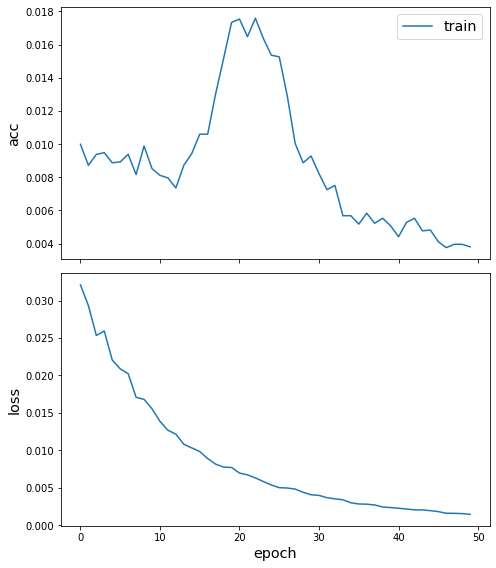

In [68]:
sg.utils.plot_history(history)

### generazione embedding per tumor Basal

In [31]:
all_mapper = generatorTumorBasal.flow(basalExprMatrixShort.index)
all_predictions = modelTumorfinal.predict(all_mapper)
all_predictions = all_predictions.astype("float64")

genesEmbeddingsTumorBasal = pd.DataFrame(all_predictions, index =basalExprMatrix.index)

In [72]:
genesEmbeddingsTumorBasal.to_csv("genesEmbedding/genesEmbeddingsTumorBasal.csv")

### visualizzazione embeddings (stesso numero di feature-pazienti di controls)

<AxesSubplot:>

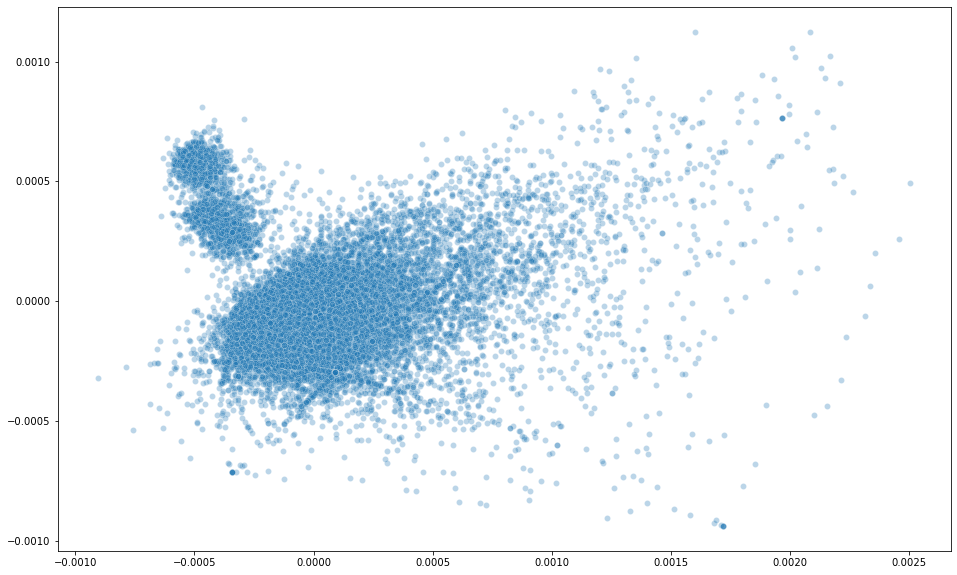

In [33]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(genesEmbeddingsTumorBasal)
firstDim = pca_result[:,0]
secondDim = pca_result[:,1] 
thirdDim = pca_result[:,2]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=firstDim, y=secondDim,
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.3
)

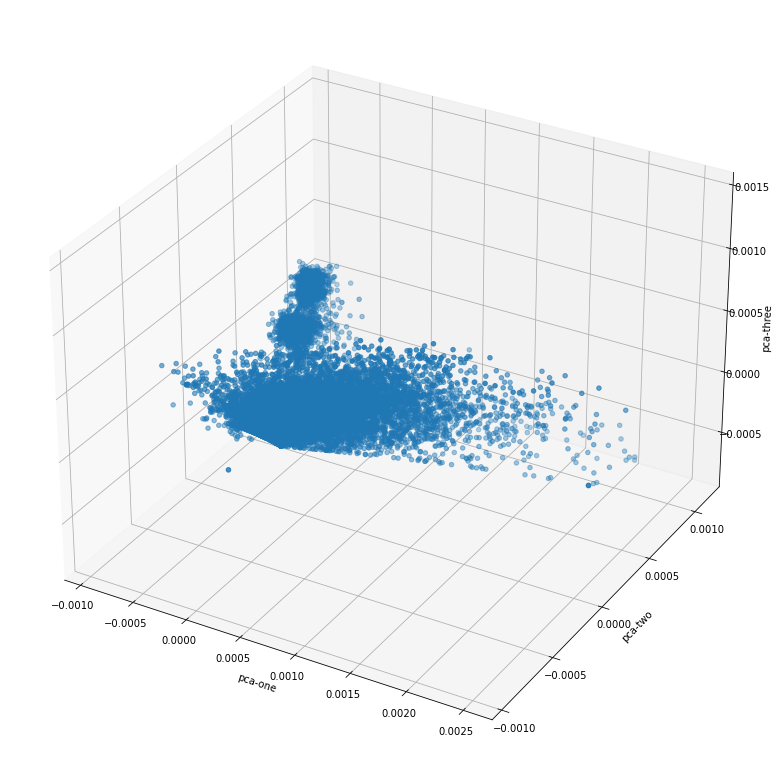

In [34]:
ax = plt.figure(figsize=(16,14)).gca(projection='3d')
ax.scatter(
    xs=firstDim, 
    ys=secondDim, 
    zs=thirdDim, 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

## Genes embeddings for **LumA** tumors

In [35]:
lumAExprMatrixShort = lumAExprMatrix.sample(n=basalExprMatrixShort.shape[1], axis='columns', random_state=2)
directedGraphTumor = sg.StellarDiGraph(lumAExprMatrixShort ,geneEdgesTumor)
print(directedGraphTumor.info())

StellarDiGraph: Directed multigraph
 Nodes: 19727, Edges: 17264

 Node types:
  default: [19727]
    Features: float32 vector, length 113
    Edge types: default-default->default

 Edge types:
    default-default->default: [17264]
        Weights: range=[-1, 1], mean=0.68165, std=0.7317
        Features: none


In [36]:
batch_sizeTumor = int(tumorDK.shape[0])
#batch_sizeTumor = tumorDK.shape[0]
in_samples = [5, 2]
out_samples = [5, 2]
batch_sizeTumor

19727

In [37]:
generatorTumorLumA = DirectedGraphSAGENodeGenerator(directedGraphTumor, batch_sizeTumor, in_samples, out_samples)

In [38]:
#train_gen = generator.flow(train_subjects.index, train_subjects)
#val_gen = generator.flow(val_subjects.index, val_subjects)
trainGenTumorfinal = generatorTumorLumA.flow(lumAExprMatrixShort.index, lumAExprMatrixShort)

graphsage_modelTumorfinal = DirectedGraphSAGE(
    layer_sizes=[32, 32], generator=generatorTumorLumA, bias=False, dropout=0.5,
)

x_inpTumorfinal, x_outTumorfinal = graphsage_modelTumorfinal.in_out_tensors()
predictionTumorfinal = layers.Dense(units=lumAExprMatrixShort.shape[1], activation="softmax")(x_outTumorfinal)


In [39]:
modelTumorfinal = Model(inputs=x_inpTumorfinal, outputs=predictionTumorfinal)
modelTumorfinal.compile(
    optimizer=optimizers.Adam(learning_rate=0.005),
    loss=optimized_lossGNN(tensorEdgesTest=tensorEdgesTestTumor,constantTensor=constantTensorTumor),
    #loss=genes_loss_with_closure(edges=tensorEdgesTest),
    #loss = testLoss([0,1]),
    metrics=["acc"]
)

#test_gen = generator.flow(test_subjects.index, test_subjects)
modelTumorfinal.summary()



Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 5, 113)]     0           []                               
                                                                                                  
 input_17 (InputLayer)          [(None, 5, 113)]     0           []                               
                                                                                                  
 input_18 (InputLayer)          [(None, 10, 113)]    0           []                               
                                                                                                  
 input_19 (InputLayer)          [(None, 10, 113)]    0           []                               
                                                                                            

In [40]:
checkpointPathTumorfinal = "model_checkpoints/GRAPHSAGEtumorGenesLumAShort.ckpt"
checkpointDirTumorfinal = os.path.dirname(checkpointPathTumorfinal)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpointPathTumorfinal,
                                                 save_weights_only=True,
                                                 verbose=1)


modelTumorfinal.load_weights(checkpointPathTumorfinal)

In [80]:
history = modelTumorfinal.fit(
    trainGenTumorfinal, epochs=50, 
    #validation_data=test_gen,
    batch_size=batch_sizeTumor,
    verbose=2, 
    shuffle=False,
    callbacks=[cp_callback]
)

Epoch 1/50

Epoch 1: saving model to model_checkpoints/GRAPHSAGEtumorGenesLumAShort.ckpt
1/1 - 17s - loss: 0.0337 - acc: 0.0076 - 17s/epoch - 17s/step
Epoch 2/50

Epoch 2: saving model to model_checkpoints/GRAPHSAGEtumorGenesLumAShort.ckpt
1/1 - 16s - loss: 0.0335 - acc: 0.0097 - 16s/epoch - 16s/step
Epoch 3/50

Epoch 3: saving model to model_checkpoints/GRAPHSAGEtumorGenesLumAShort.ckpt
1/1 - 16s - loss: 0.0285 - acc: 0.0090 - 16s/epoch - 16s/step
Epoch 4/50

Epoch 4: saving model to model_checkpoints/GRAPHSAGEtumorGenesLumAShort.ckpt
1/1 - 18s - loss: 0.0252 - acc: 0.0082 - 18s/epoch - 18s/step
Epoch 5/50

Epoch 5: saving model to model_checkpoints/GRAPHSAGEtumorGenesLumAShort.ckpt
1/1 - 20s - loss: 0.0239 - acc: 0.0085 - 20s/epoch - 20s/step
Epoch 6/50

Epoch 6: saving model to model_checkpoints/GRAPHSAGEtumorGenesLumAShort.ckpt
1/1 - 20s - loss: 0.0215 - acc: 0.0075 - 20s/epoch - 20s/step
Epoch 7/50

Epoch 7: saving model to model_checkpoints/GRAPHSAGEtumorGenesLumAShort.ckpt
1/1 -

In [81]:
modelTumorfinal.save_weights(checkpointPathTumorfinal.format(epoch=0))

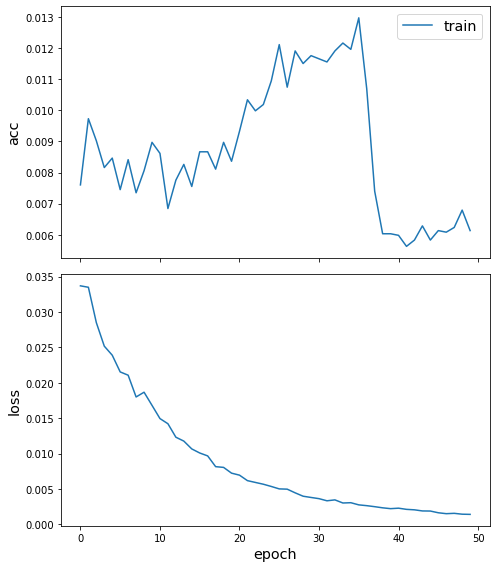

In [82]:
sg.utils.plot_history(history)

### generazione embedding per tumor LumA

In [41]:
all_mapper = generatorTumorLumA.flow(lumAExprMatrixShort.index)
all_predictions = modelTumorfinal.predict(all_mapper)
all_predictions = all_predictions.astype("float64")

genesEmbeddingsTumorLumA = pd.DataFrame(all_predictions, index =lumAExprMatrixShort.index)

In [42]:
genesEmbeddingsTumorLumA

0         1         2         3         4         5         6    \
2      0.007777  0.008296  0.010094  0.009946  0.009810  0.007835  0.009553   
3      0.007874  0.008274  0.010160  0.009925  0.009824  0.007807  0.009602   
7      0.007804  0.008252  0.010091  0.009956  0.009855  0.007742  0.009620   
8      0.007824  0.008215  0.010088  0.009966  0.009843  0.007775  0.009621   
10     0.007822  0.008201  0.010088  0.009961  0.009843  0.007764  0.009618   
...         ...       ...       ...       ...       ...       ...       ...   
20526  0.007838  0.008162  0.010587  0.010033  0.009856  0.007605  0.009502   
20527  0.007836  0.008210  0.010095  0.009954  0.009835  0.007783  0.009617   
20528  0.007839  0.008212  0.010074  0.009958  0.009831  0.007808  0.009609   
20529  0.007825  0.008249  0.010127  0.009961  0.009849  0.007753  0.009626   
20530  0.007823  0.008240  0.010125  0.009955  0.009855  0.007733  0.009644   

            7         8         9    ...       103       104       105  \
2      0.008431  0.008095  0.008550  ...  0.008466  0.008234  0.009878   
3      0.008594  0.008329  0.008302  ...  0.008350  0.008152  0.009959   
7      0.008464  0.008166  0.008371  ...  0.008491  0.008189  0.009796   
8      0.008511  0.008175  0.008403  ...  0.008425  0.008175  0.009820   
10     0.008508  0.008151  0.008405  ...  0.008436  0.008180  0.009809   
...         ...       ...       ...  ...       ...       ...       ...   
20526  0.008600  0.008129  0.008243  ...  0.008537  0.008085  0.009777   
20527  0.008529  0.008186  0.008393  ...  0.008408  0.008178  0.009843   
20528  0.008522  0.008203  0.008410  ...  0.008400  0.008189  0.009849   
20529  0.008523  0.008193  0.008362  ...  0.008423  0.008158  0.009847   
20530  0.008528  0.008191  0.008344  ...  0.008433  0.008138  0.009827   

            106       107       108       109       110       111       112  
2      0.009468  0.008191  0.009415  0.007572  0.008525  0.010223  0.009825  
3      0.009577  0.008199  0.009360  0.007467  0.008464  0.010236  0.009646  
7      0.009546  0.008178  0.009366  0.007491  0.008508  0.010152  0.009663  
8      0.009540  0.008202  0.009365  0.007558  0.008447  0.010207  0.009686  
10     0.009538  0.008219  0.009373  0.007578  0.008437  0.010205  0.009702  
...         ...       ...       ...       ...       ...       ...       ...  
20526  0.009570  0.008351  0.009394  0.007616  0.008649  0.010194  0.009538  
20527  0.009546  0.008215  0.009366  0.007567  0.008426  0.010220  0.009701  
20528  0.009519  0.008189  0.009365  0.007541  0.008441  0.010211  0.009692  
20529  0.009583  0.008204  0.009371  0.007535  0.008448  0.010210  0.009681  
20530  0.009599  0.008230  0.009359  0.007560  0.008446  0.010212  0.009668  

[19727 rows x 113 columns]

In [47]:
lumAExprMatrixShort1 = lumAExprMatrix.iloc[:,:basalExprMatrixShort.shape[1]]
lumAExprMatrixShort2 = lumAExprMatrix.iloc[:,basalExprMatrixShort.shape[1]:2*basalExprMatrixShort.shape[1]]
lumAExprMatrixShort3 = lumAExprMatrix.iloc[:,2*basalExprMatrixShort.shape[1]:3*basalExprMatrixShort.shape[1]]
lumAExprMatrixShort4 = lumAExprMatrix.iloc[:,3*basalExprMatrixShort.shape[1]:4*basalExprMatrixShort.shape[1]]
directedGraphTumor1 = sg.StellarDiGraph(lumAExprMatrixShort1 ,geneEdgesTumor)
directedGraphTumor2 = sg.StellarDiGraph(lumAExprMatrixShort2 ,geneEdgesTumor)
directedGraphTumor3 = sg.StellarDiGraph(lumAExprMatrixShort3 ,geneEdgesTumor)
directedGraphTumor4 = sg.StellarDiGraph(lumAExprMatrixShort4 ,geneEdgesTumor)
generatorTumorLumA1 = DirectedGraphSAGENodeGenerator(directedGraphTumor1, batch_sizeTumor, in_samples, out_samples)
generatorTumorLumA2= DirectedGraphSAGENodeGenerator(directedGraphTumor2, batch_sizeTumor, in_samples, out_samples)
generatorTumorLumA3 = DirectedGraphSAGENodeGenerator(directedGraphTumor3, batch_sizeTumor, in_samples, out_samples)
generatorTumorLumA4 = DirectedGraphSAGENodeGenerator(directedGraphTumor4, batch_sizeTumor, in_samples, out_samples)

In [49]:
all_mapper = generatorTumorLumA1.flow(lumAExprMatrixShort1.index)
all_predictions = modelTumorfinal.predict(all_mapper)
all_predictions = all_predictions.astype("float64")

genesEmbeddingsTumorLumA1 = pd.DataFrame(all_predictions, index =lumAExprMatrixShort1.index)

all_mapper = generatorTumorLumA2.flow(lumAExprMatrixShort2.index)
all_predictions = modelTumorfinal.predict(all_mapper)
all_predictions = all_predictions.astype("float64")

genesEmbeddingsTumorLumA2 = pd.DataFrame(all_predictions, index =lumAExprMatrixShort2.index)

all_mapper = generatorTumorLumA3.flow(lumAExprMatrixShort3.index)
all_predictions = modelTumorfinal.predict(all_mapper)
all_predictions = all_predictions.astype("float64")

genesEmbeddingsTumorLumA3 = pd.DataFrame(all_predictions, index =lumAExprMatrixShort3.index)

all_mapper = generatorTumorLumA4.flow(lumAExprMatrixShort4.index)
all_predictions = modelTumorfinal.predict(all_mapper)
all_predictions = all_predictions.astype("float64")

genesEmbeddingsTumorLumA4 = pd.DataFrame(all_predictions, index =lumAExprMatrixShort4.index)

In [51]:
genesEmbeddingsTumorLumA1.to_csv("genesEmbedding/genesEmbeddingsTumorLumA1.csv")
genesEmbeddingsTumorLumA2.to_csv("genesEmbedding/genesEmbeddingsTumorLumA2.csv")
genesEmbeddingsTumorLumA3.to_csv("genesEmbedding/genesEmbeddingsTumorLumA3.csv")
genesEmbeddingsTumorLumA4.to_csv("genesEmbedding/genesEmbeddingsTumorLumA4.csv")

### visualizzazione embeddings LumA

<AxesSubplot:>

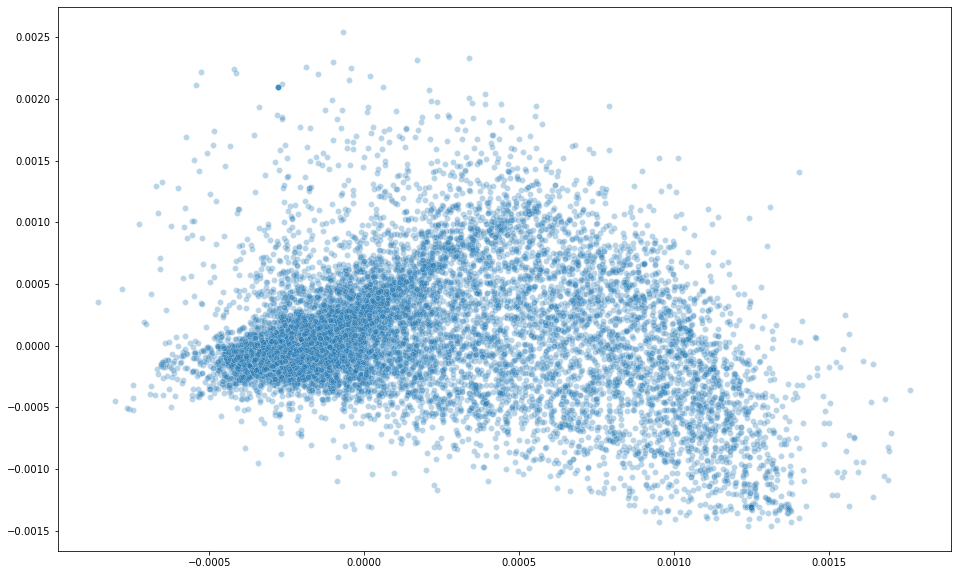

In [59]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(genesEmbeddingsTumorLumA)
firstDim = pca_result[:,0]
secondDim = pca_result[:,1] 
thirdDim = pca_result[:,2]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=firstDim, y=secondDim,
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.3
)

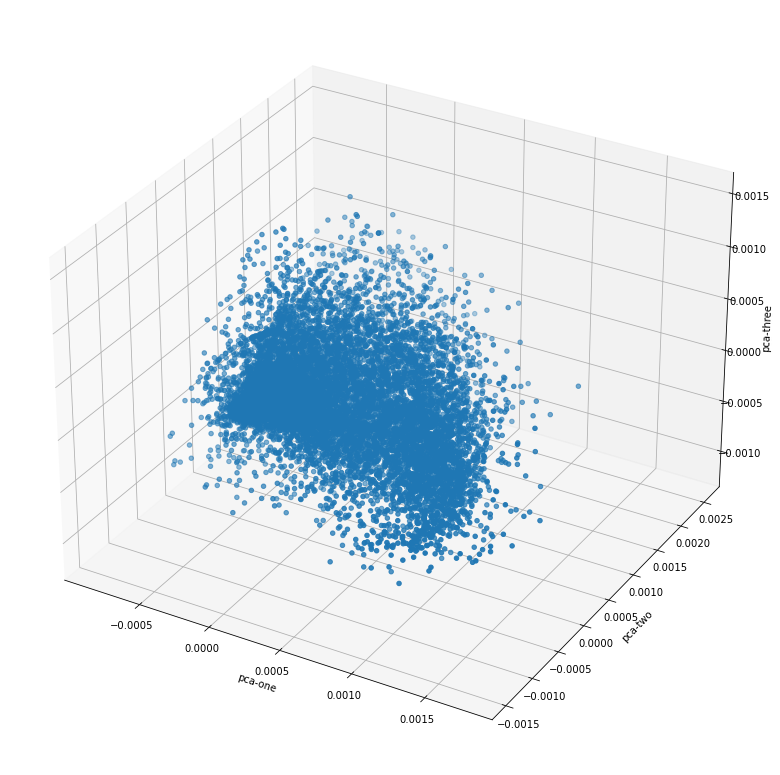

In [60]:
ax = plt.figure(figsize=(16,14)).gca(projection='3d')
ax.scatter(
    xs=firstDim, 
    ys=secondDim, 
    zs=thirdDim, 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

## Genes embeddings for **LumB** tumors

In [61]:
lumBExprMatrixShort = lumBExprMatrix.sample(n=basalExprMatrixShort.shape[1], axis='columns', random_state=2)
directedGraphTumor = sg.StellarDiGraph(lumBExprMatrixShort ,geneEdgesTumor)
print(directedGraphTumor.info())

StellarDiGraph: Directed multigraph
 Nodes: 19727, Edges: 17264

 Node types:
  default: [19727]
    Features: float32 vector, length 113
    Edge types: default-default->default

 Edge types:
    default-default->default: [17264]
        Weights: range=[-1, 1], mean=0.68165, std=0.7317
        Features: none


In [62]:
batch_sizeTumor = int(tumorDK.shape[0])
#batch_sizeTumor = tumorDK.shape[0]
in_samples = [5, 2]
out_samples = [5, 2]
batch_sizeTumor

19727

In [63]:
generatorTumorLumB = DirectedGraphSAGENodeGenerator(directedGraphTumor, batch_sizeTumor, in_samples, out_samples)

In [64]:
#train_gen = generator.flow(train_subjects.index, train_subjects)
#val_gen = generator.flow(val_subjects.index, val_subjects)
trainGenTumorfinal = generatorTumorLumB.flow(lumBExprMatrixShort.index, lumBExprMatrixShort)

graphsage_modelTumorfinal = DirectedGraphSAGE(
    layer_sizes=[32, 32], generator=generatorTumorLumB, bias=False, dropout=0.5,
)

x_inpTumorfinal, x_outTumorfinal = graphsage_modelTumorfinal.in_out_tensors()
predictionTumorfinal = layers.Dense(units=lumBExprMatrixShort.shape[1], activation="softmax")(x_outTumorfinal)


In [65]:
modelTumorfinal = Model(inputs=x_inpTumorfinal, outputs=predictionTumorfinal)
modelTumorfinal.compile(
    optimizer=optimizers.Adam(learning_rate=0.005),
    loss=optimized_lossGNN(tensorEdgesTest=tensorEdgesTestTumor,constantTensor=constantTensorTumor),
    #loss=genes_loss_with_closure(edges=tensorEdgesTest),
    #loss = testLoss([0,1]),
    metrics=["acc"]
)

#test_gen = generator.flow(test_subjects.index, test_subjects)
modelTumorfinal.summary()



Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_23 (InputLayer)          [(None, 5, 113)]     0           []                               
                                                                                                  
 input_24 (InputLayer)          [(None, 5, 113)]     0           []                               
                                                                                                  
 input_25 (InputLayer)          [(None, 10, 113)]    0           []                               
                                                                                                  
 input_26 (InputLayer)          [(None, 10, 113)]    0           []                               
                                                                                            

In [66]:
checkpointPathTumorfinal = "model_checkpoints/GRAPHSAGEtumorGenesLumB113.ckpt"
checkpointDirTumorfinal = os.path.dirname(checkpointPathTumorfinal)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpointPathTumorfinal,
                                                 save_weights_only=True,
                                                 verbose=1)


modelTumorfinal.load_weights(checkpointPathTumorfinal)

In [47]:
history = modelTumorfinal.fit(
    trainGenTumorfinal, epochs=50, 
    #validation_data=test_gen,
    batch_size=batch_sizeTumor,
    verbose=2, 
    shuffle=False,
    callbacks=[cp_callback]
)

Epoch 1/50

Epoch 1: saving model to model_checkpoints/GRAPHSAGEtumorGenesLumB113.ckpt
1/1 - 51s - loss: 0.0322 - acc: 0.0076 - 51s/epoch - 51s/step
Epoch 2/50

Epoch 2: saving model to model_checkpoints/GRAPHSAGEtumorGenesLumB113.ckpt
1/1 - 49s - loss: 0.0326 - acc: 0.0079 - 49s/epoch - 49s/step
Epoch 3/50

Epoch 3: saving model to model_checkpoints/GRAPHSAGEtumorGenesLumB113.ckpt
1/1 - 50s - loss: 0.0286 - acc: 0.0070 - 50s/epoch - 50s/step
Epoch 4/50

Epoch 4: saving model to model_checkpoints/GRAPHSAGEtumorGenesLumB113.ckpt
1/1 - 52s - loss: 0.0279 - acc: 0.0077 - 52s/epoch - 52s/step
Epoch 5/50

Epoch 5: saving model to model_checkpoints/GRAPHSAGEtumorGenesLumB113.ckpt
1/1 - 51s - loss: 0.0249 - acc: 0.0080 - 51s/epoch - 51s/step
Epoch 6/50

Epoch 6: saving model to model_checkpoints/GRAPHSAGEtumorGenesLumB113.ckpt
1/1 - 51s - loss: 0.0230 - acc: 0.0073 - 51s/epoch - 51s/step
Epoch 7/50

Epoch 7: saving model to model_checkpoints/GRAPHSAGEtumorGenesLumB113.ckpt
1/1 - 52s - loss: 0

In [48]:
modelTumorfinal.save_weights(checkpointPathTumorfinal.format(epoch=0))

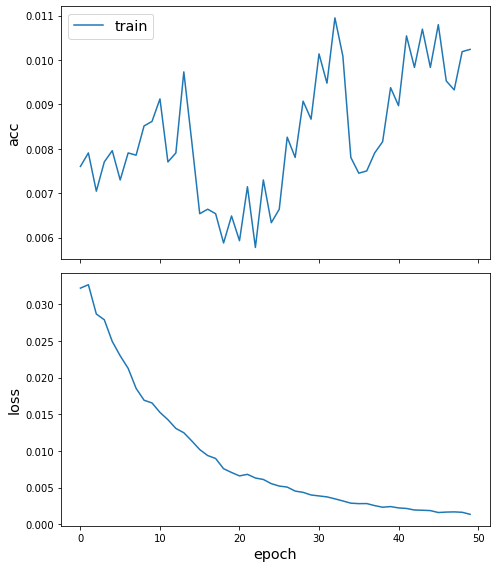

In [49]:
sg.utils.plot_history(history)

### generazione embedding per tumor LumB

In [67]:
all_mapper = generatorTumorLumB.flow(lumBExprMatrixShort.index)
all_predictions = modelTumorfinal.predict(all_mapper)
all_predictions = all_predictions.astype("float64")

genesEmbeddingsTumorLumB = pd.DataFrame(all_predictions, index =lumBExprMatrixShort.index)

In [69]:
genesEmbeddingsTumorLumB.to_csv("genesEmbedding/genesEmbeddingsTumorLumB.csv")

### visualizzazione embeddings LumB

<AxesSubplot:>

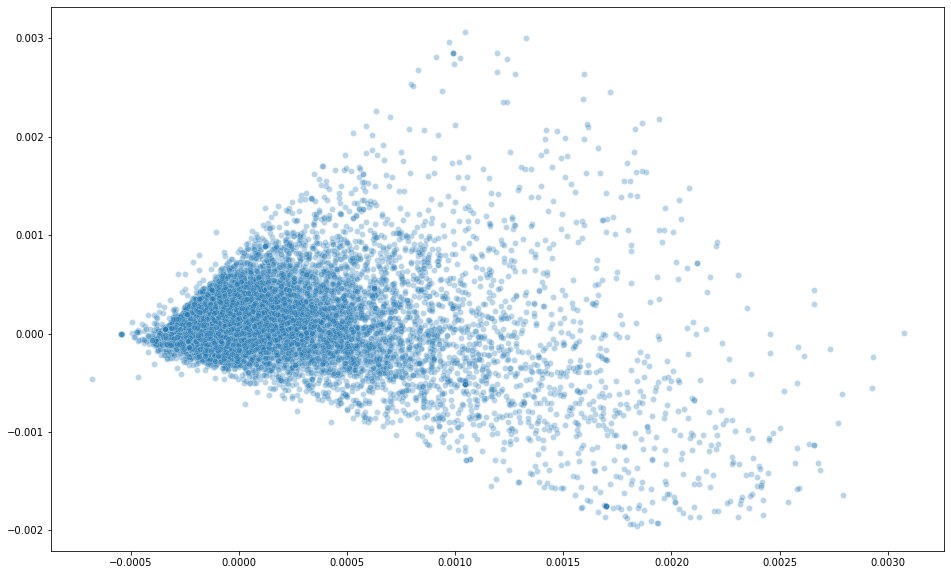

In [70]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(genesEmbeddingsTumorLumB)
firstDim = pca_result[:,0]
secondDim = pca_result[:,1] 
thirdDim = pca_result[:,2]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=firstDim, y=secondDim,
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.3
)

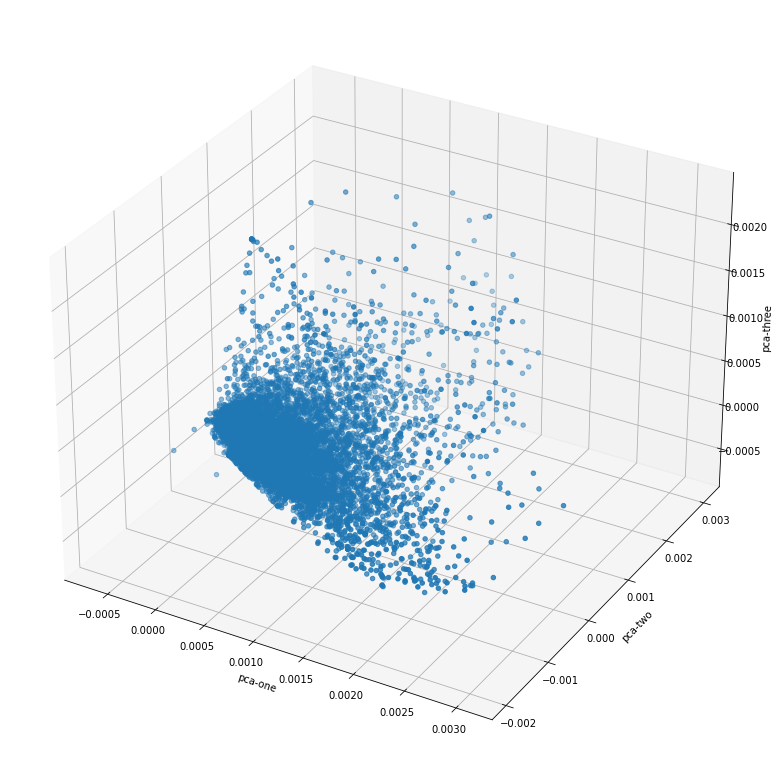

In [71]:
ax = plt.figure(figsize=(16,14)).gca(projection='3d')
ax.scatter(
    xs=firstDim, 
    ys=secondDim, 
    zs=thirdDim, 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

## Genes embeddings for **LumB** tumors (171 patients)

In [72]:
lumBExprMatrixShort = lumBExprMatrix.sample(n=basalExprMatrix.shape[1], axis='columns', random_state=2)
directedGraphTumor = sg.StellarDiGraph(lumBExprMatrixShort ,geneEdgesTumor)
print(directedGraphTumor.info())

StellarDiGraph: Directed multigraph
 Nodes: 19727, Edges: 17264

 Node types:
  default: [19727]
    Features: float32 vector, length 171
    Edge types: default-default->default

 Edge types:
    default-default->default: [17264]
        Weights: range=[-1, 1], mean=0.68165, std=0.7317
        Features: none


In [73]:
batch_sizeTumor = int(tumorDK.shape[0])
#batch_sizeTumor = tumorDK.shape[0]
in_samples = [5, 2]
out_samples = [5, 2]
batch_sizeTumor

19727

In [74]:
generatorTumorLumB = DirectedGraphSAGENodeGenerator(directedGraphTumor, batch_sizeTumor, in_samples, out_samples)

In [75]:
#train_gen = generator.flow(train_subjects.index, train_subjects)
#val_gen = generator.flow(val_subjects.index, val_subjects)
trainGenTumorfinal = generatorTumorLumB.flow(lumBExprMatrixShort.index, lumBExprMatrixShort)

graphsage_modelTumorfinal = DirectedGraphSAGE(
    layer_sizes=[32, 32], generator=generatorTumorLumB, bias=False, dropout=0.5,
)

x_inpTumorfinal, x_outTumorfinal = graphsage_modelTumorfinal.in_out_tensors()
predictionTumorfinal = layers.Dense(units=lumBExprMatrixShort.shape[1], activation="softmax")(x_outTumorfinal)


In [76]:
modelTumorfinal = Model(inputs=x_inpTumorfinal, outputs=predictionTumorfinal)
modelTumorfinal.compile(
    optimizer=optimizers.Adam(learning_rate=0.005),
    loss=optimized_lossGNN(tensorEdgesTest=tensorEdgesTestTumor,constantTensor=constantTensorTumor),
    #loss=genes_loss_with_closure(edges=tensorEdgesTest),
    #loss = testLoss([0,1]),
    metrics=["acc"]
)

#test_gen = generator.flow(test_subjects.index, test_subjects)
modelTumorfinal.summary()



Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_58 (InputLayer)          [(None, 5, 171)]     0           []                               
                                                                                                  
 input_59 (InputLayer)          [(None, 5, 171)]     0           []                               
                                                                                                  
 input_60 (InputLayer)          [(None, 10, 171)]    0           []                               
                                                                                                  
 input_61 (InputLayer)          [(None, 10, 171)]    0           []                               
                                                                                            

In [77]:
checkpointPathTumorfinal = "model_checkpoints/GRAPHSAGEtumorGenesLumBShort.ckpt"
checkpointDirTumorfinal = os.path.dirname(checkpointPathTumorfinal)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpointPathTumorfinal,
                                                 save_weights_only=True,
                                                 verbose=1)


modelTumorfinal.load_weights(checkpointPathTumorfinal)

ValueError: Shapes (171, 12) and (113, 12) are incompatible

In [94]:
history = modelTumorfinal.fit(
    trainGenTumorfinal, epochs=50, 
    #validation_data=test_gen,
    batch_size=batch_sizeTumor,
    verbose=2, 
    shuffle=False,
    callbacks=[cp_callback]
)

Epoch 1/50

Epoch 1: saving model to model_checkpoints/GRAPHSAGEtumorGenesLumBShort.ckpt
1/1 - 17s - loss: 0.0327 - acc: 0.0104 - 17s/epoch - 17s/step
Epoch 2/50

Epoch 2: saving model to model_checkpoints/GRAPHSAGEtumorGenesLumBShort.ckpt
1/1 - 16s - loss: 0.0273 - acc: 0.0094 - 16s/epoch - 16s/step
Epoch 3/50

Epoch 3: saving model to model_checkpoints/GRAPHSAGEtumorGenesLumBShort.ckpt
1/1 - 16s - loss: 0.0256 - acc: 0.0094 - 16s/epoch - 16s/step
Epoch 4/50

Epoch 4: saving model to model_checkpoints/GRAPHSAGEtumorGenesLumBShort.ckpt
1/1 - 16s - loss: 0.0227 - acc: 0.0108 - 16s/epoch - 16s/step
Epoch 5/50

Epoch 5: saving model to model_checkpoints/GRAPHSAGEtumorGenesLumBShort.ckpt
1/1 - 16s - loss: 0.0215 - acc: 0.0101 - 16s/epoch - 16s/step
Epoch 6/50

Epoch 6: saving model to model_checkpoints/GRAPHSAGEtumorGenesLumBShort.ckpt
1/1 - 17s - loss: 0.0192 - acc: 0.0104 - 17s/epoch - 17s/step
Epoch 7/50

Epoch 7: saving model to model_checkpoints/GRAPHSAGEtumorGenesLumBShort.ckpt
1/1 -

In [95]:
modelTumorfinal.save_weights(checkpointPathTumorfinal.format(epoch=0))

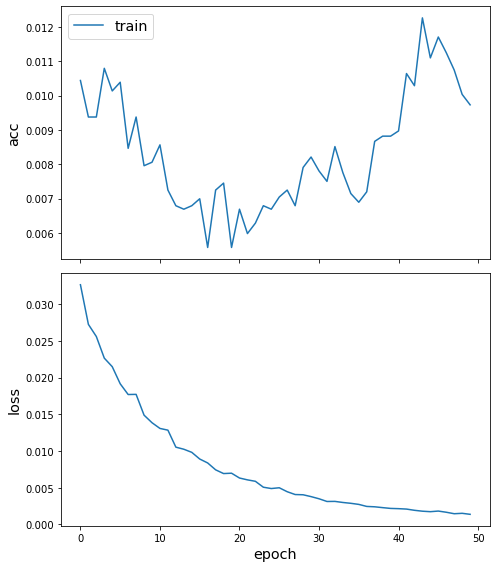

In [96]:
sg.utils.plot_history(history)

### generazione embedding per tumor LumB

In [55]:
all_mapper = generatorTumorLumB.flow(lumBExprMatrixShort.index)
all_predictions = modelTumorfinal.predict(all_mapper)
all_predictions = all_predictions.astype("float64")

genesEmbeddingsTumorLumB = pd.DataFrame(all_predictions, index =lumBExprMatrixShort.index)

In [56]:
genesEmbeddingsTumorLumB

0         1         2         3         4         5         6    \
2      0.008046  0.009165  0.009507  0.007762  0.008953  0.009442  0.008768   
3      0.008129  0.009336  0.009642  0.007812  0.008795  0.009024  0.008635   
7      0.008085  0.009213  0.009582  0.007538  0.009009  0.009334  0.008707   
8      0.008092  0.009209  0.009590  0.007535  0.009008  0.009336  0.008718   
10     0.008094  0.009216  0.009598  0.007536  0.008984  0.009317  0.008729   
...         ...       ...       ...       ...       ...       ...       ...   
20526  0.008050  0.009233  0.009576  0.007499  0.008864  0.009262  0.008704   
20527  0.008085  0.009205  0.009585  0.007546  0.009015  0.009336  0.008704   
20528  0.008093  0.009217  0.009601  0.007531  0.009012  0.009339  0.008725   
20529  0.008097  0.009208  0.009591  0.007536  0.009008  0.009335  0.008719   
20530  0.008087  0.009196  0.009572  0.007560  0.009013  0.009333  0.008689   

            7         8         9    ...       103       104       105  \
2      0.007342  0.007893  0.007922  ...  0.008203  0.007700  0.009996   
3      0.007236  0.008111  0.008233  ...  0.008309  0.007449  0.009873   
7      0.007254  0.008031  0.007983  ...  0.008012  0.007588  0.009979   
8      0.007247  0.008024  0.007971  ...  0.008030  0.007584  0.009975   
10     0.007232  0.008023  0.007988  ...  0.008048  0.007591  0.009966   
...         ...       ...       ...  ...       ...       ...       ...   
20526  0.007391  0.007994  0.008025  ...  0.008089  0.007747  0.009926   
20527  0.007261  0.008023  0.007972  ...  0.008028  0.007602  0.009985   
20528  0.007246  0.008032  0.007961  ...  0.008036  0.007561  0.009966   
20529  0.007250  0.008023  0.007966  ...  0.008037  0.007584  0.009974   
20530  0.007272  0.008019  0.007981  ...  0.008034  0.007623  0.009999   

            106       107       108       109       110       111       112  
2      0.009976  0.009424  0.007666  0.009379  0.007389  0.009634  0.009800  
3      0.009797  0.009396  0.007468  0.009217  0.006978  0.009808  0.010148  
7      0.009890  0.009372  0.007511  0.009290  0.007273  0.009714  0.009894  
8      0.009907  0.009388  0.007508  0.009305  0.007293  0.009698  0.009888  
10     0.009912  0.009398  0.007492  0.009299  0.007287  0.009693  0.009908  
...         ...       ...       ...       ...       ...       ...       ...  
20526  0.009859  0.009379  0.007572  0.009222  0.007299  0.009709  0.009950  
20527  0.009901  0.009391  0.007523  0.009307  0.007291  0.009709  0.009882  
20528  0.009917  0.009384  0.007503  0.009313  0.007288  0.009694  0.009888  
20529  0.009913  0.009394  0.007513  0.009311  0.007302  0.009697  0.009886  
20530  0.009890  0.009403  0.007539  0.009307  0.007301  0.009715  0.009878  

[19727 rows x 113 columns]

### visualizzazione embeddings LumB

<AxesSubplot:>

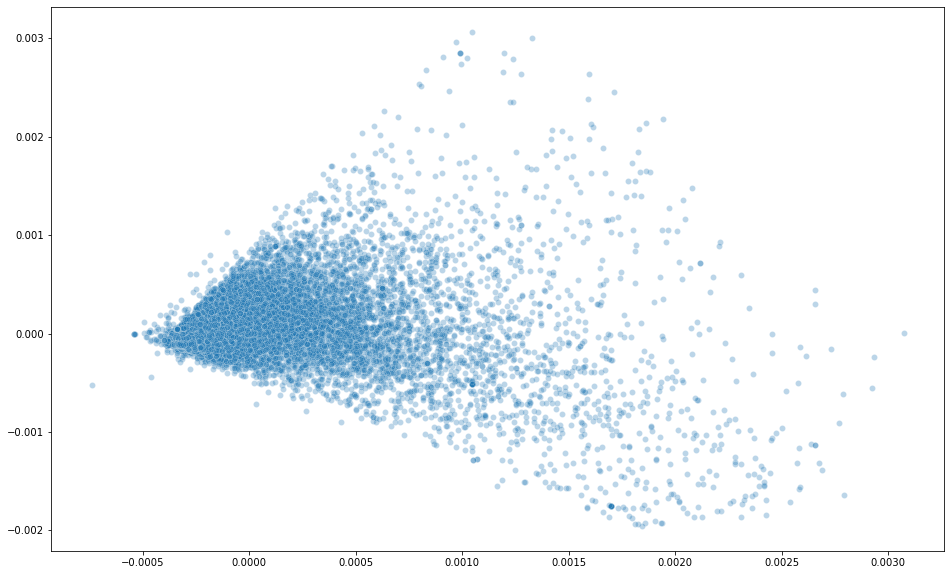

In [57]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(genesEmbeddingsTumorLumB)
firstDim = pca_result[:,0]
secondDim = pca_result[:,1] 
thirdDim = pca_result[:,2]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=firstDim, y=secondDim,
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.3
)

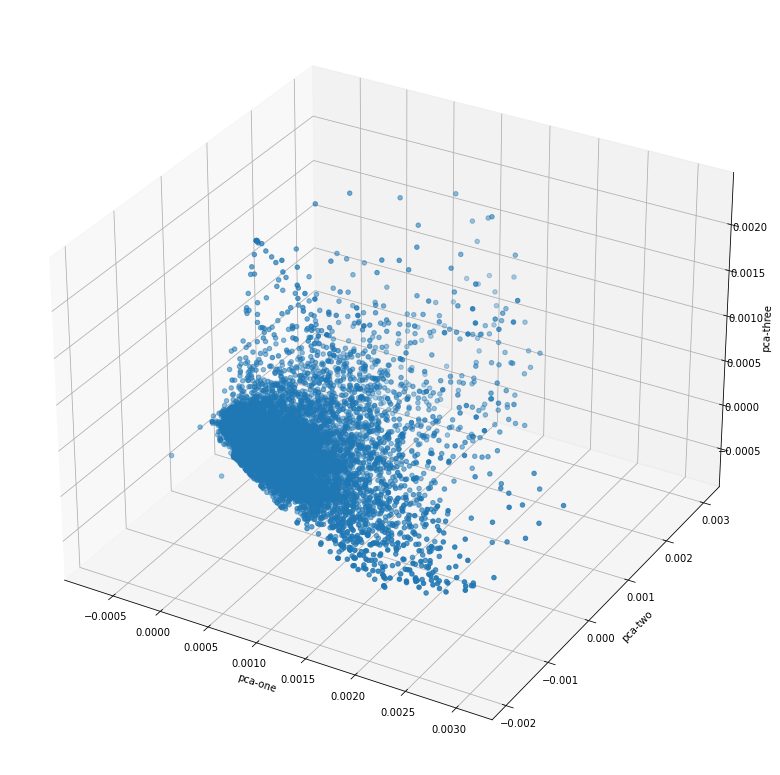

In [58]:
ax = plt.figure(figsize=(16,14)).gca(projection='3d')
ax.scatter(
    xs=firstDim, 
    ys=secondDim, 
    zs=thirdDim, 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

## Genes embeddings for **Stage I** tumors

In [75]:
#stageExprMatrixShort = stageIExprMatrix.sample(n=basalExprMatrix.shape[1], axis='columns', random_state=2)
directedGraphTumor = sg.StellarDiGraph(stageIExprMatrix ,geneEdgesTumor)
print(directedGraphTumor.info())

StellarDiGraph: Directed multigraph
 Nodes: 19727, Edges: 17264

 Node types:
  default: [19727]
    Features: float32 vector, length 180
    Edge types: default-default->default

 Edge types:
    default-default->default: [17264]
        Weights: range=[-1, 1], mean=0.68165, std=0.7317
        Features: none


In [76]:
batch_sizeTumor = int(tumorDK.shape[0])
#batch_sizeTumor = tumorDK.shape[0]
in_samples = [5, 2]
out_samples = [5, 2]
batch_sizeTumor

19727

In [77]:
generatorTumorStageI = DirectedGraphSAGENodeGenerator(directedGraphTumor, batch_sizeTumor, in_samples, out_samples)

In [79]:
#train_gen = generator.flow(train_subjects.index, train_subjects)
#val_gen = generator.flow(val_subjects.index, val_subjects)
trainGenTumorfinal = generatorTumorStageI.flow(stageIExprMatrix.index, stageIExprMatrix)

graphsage_modelTumorfinal = DirectedGraphSAGE(
    layer_sizes=[32, 32], generator=generatorTumorStageI, bias=False, dropout=0.5,
)

x_inpTumorfinal, x_outTumorfinal = graphsage_modelTumorfinal.in_out_tensors()
predictionTumorfinal = layers.Dense(units=stageIExprMatrix.shape[1], activation="softmax")(x_outTumorfinal)


In [80]:
modelTumorfinal = Model(inputs=x_inpTumorfinal, outputs=predictionTumorfinal)
modelTumorfinal.compile(
    optimizer=optimizers.Adam(learning_rate=0.005),
    loss=optimized_lossGNN(tensorEdgesTest=tensorEdgesTestTumor,constantTensor=constantTensorTumor),
    #loss=genes_loss_with_closure(edges=tensorEdgesTest),
    #loss = testLoss([0,1]),
    metrics=["acc"]
)

#test_gen = generator.flow(test_subjects.index, test_subjects)
modelTumorfinal.summary()



Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_30 (InputLayer)          [(None, 5, 180)]     0           []                               
                                                                                                  
 input_31 (InputLayer)          [(None, 5, 180)]     0           []                               
                                                                                                  
 input_32 (InputLayer)          [(None, 10, 180)]    0           []                               
                                                                                                  
 input_33 (InputLayer)          [(None, 10, 180)]    0           []                               
                                                                                            

In [81]:
checkpointPathTumorfinal = "model_checkpoints/GRAPHSAGEtumorGenesStageI.ckpt"
checkpointDirTumorfinal = os.path.dirname(checkpointPathTumorfinal)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpointPathTumorfinal,
                                                 save_weights_only=True,
                                                 verbose=1)


modelTumorfinal.load_weights(checkpointPathTumorfinal)

In [82]:
history = modelTumorfinal.fit(
    trainGenTumorfinal, epochs=50, 
    #validation_data=test_gen,
    batch_size=batch_sizeTumor,
    verbose=2, 
    shuffle=False,
    callbacks=[cp_callback]
)

Epoch 1/50

Epoch 1: saving model to model_checkpoints/GRAPHSAGEtumorGenesStageI.ckpt
1/1 - 23s - loss: 49.2279 - acc: 0.0025 - 23s/epoch - 23s/step
Epoch 2/50

Epoch 2: saving model to model_checkpoints/GRAPHSAGEtumorGenesStageI.ckpt
1/1 - 22s - loss: 45.1349 - acc: 0.0029 - 22s/epoch - 22s/step
Epoch 3/50

Epoch 3: saving model to model_checkpoints/GRAPHSAGEtumorGenesStageI.ckpt
1/1 - 22s - loss: 40.8627 - acc: 0.0030 - 22s/epoch - 22s/step
Epoch 4/50

Epoch 4: saving model to model_checkpoints/GRAPHSAGEtumorGenesStageI.ckpt
1/1 - 22s - loss: 36.7535 - acc: 0.0035 - 22s/epoch - 22s/step
Epoch 5/50

Epoch 5: saving model to model_checkpoints/GRAPHSAGEtumorGenesStageI.ckpt
1/1 - 22s - loss: 32.1572 - acc: 0.0031 - 22s/epoch - 22s/step
Epoch 6/50

Epoch 6: saving model to model_checkpoints/GRAPHSAGEtumorGenesStageI.ckpt
1/1 - 21s - loss: 29.9125 - acc: 0.0033 - 21s/epoch - 21s/step
Epoch 7/50

Epoch 7: saving model to model_checkpoints/GRAPHSAGEtumorGenesStageI.ckpt
1/1 - 22s - loss: 25

In [83]:
modelTumorfinal.save_weights(checkpointPathTumorfinal.format(epoch=0))

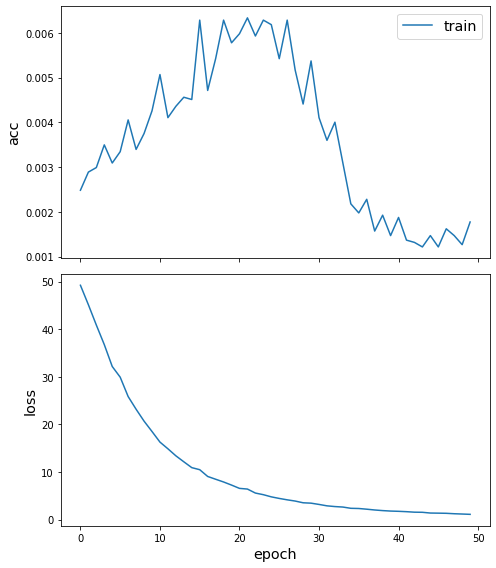

In [84]:
sg.utils.plot_history(history)

### generazione embedding per tumor Stage I

In [85]:
all_mapper = generatorTumorStageI.flow(stageIExprMatrix.index)
all_predictions = modelTumorfinal.predict(all_mapper)
all_predictions = all_predictions.astype("float64")

genesEmbeddingsTumorStageI = pd.DataFrame(all_predictions, index =stageIExprMatrix.index,columns =stageIExprMatrix.columns)

In [86]:
genesEmbeddingsTumorStageI

TCGA-3C-AALK  TCGA-A1-A0SB  TCGA-A1-A0SE  TCGA-A2-A04N  TCGA-A2-A04Q  \
2          0.004746      0.006207      0.004781      0.005088      0.005704   
3          0.004747      0.006178      0.004800      0.005047      0.005712   
7          0.004760      0.006199      0.004763      0.005077      0.005688   
8          0.004760      0.006200      0.004765      0.005077      0.005687   
10         0.004761      0.006201      0.004767      0.005075      0.005686   
...             ...           ...           ...           ...           ...   
20526      0.004759      0.006206      0.004790      0.005069      0.005675   
20527      0.004759      0.006199      0.004765      0.005077      0.005688   
20528      0.004761      0.006200      0.004765      0.005076      0.005687   
20529      0.004760      0.006200      0.004765      0.005076      0.005687   
20530      0.004760      0.006199      0.004762      0.005078      0.005688   

       TCGA-A2-A04R  TCGA-A2-A0CP  TCGA-A2-A0CQ  TCGA-A2-A0D3  TCGA-A2-A0EM  \
2          0.005695      0.006119      0.006064      0.005557      0.006263   
3          0.005639      0.006134      0.006062      0.005538      0.006246   
7          0.005687      0.006113      0.006046      0.005554      0.006244   
8          0.005687      0.006113      0.006046      0.005554      0.006243   
10         0.005686      0.006113      0.006047      0.005554      0.006243   
...             ...           ...           ...           ...           ...   
20526      0.005686      0.006118      0.006055      0.005542      0.006249   
20527      0.005687      0.006113      0.006047      0.005553      0.006243   
20528      0.005686      0.006112      0.006046      0.005553      0.006244   
20529      0.005687      0.006111      0.006046      0.005553      0.006243   
20530      0.005688      0.006112      0.006046      0.005554      0.006244   

       ...  TCGA-OL-A5RX  TCGA-OL-A5RZ  TCGA-OL-A66H  TCGA-OL-A66J  \
2      ...      0.004899      0.004439      0.006279      0.004539   
3      ...      0.004881      0.004453      0.006333      0.004518   
7      ...      0.004881      0.004440      0.006301      0.004501   
8      ...      0.004879      0.004441      0.006302      0.004501   
10     ...      0.004880      0.004446      0.006304      0.004501   
...    ...           ...           ...           ...           ...   
20526  ...      0.004885      0.004445      0.006291      0.004519   
20527  ...      0.004880      0.004439      0.006302      0.004501   
20528  ...      0.004880      0.004443      0.006304      0.004503   
20529  ...      0.004880      0.004440      0.006302      0.004501   
20530  ...      0.004879      0.004439      0.006301      0.004503   

       TCGA-OL-A66L  TCGA-OL-A6VO  TCGA-OL-A6VR  TCGA-S3-AA14  TCGA-WT-AB44  \
2          0.005144      0.006103      0.005682      0.004735      0.004795   
3          0.005119      0.006109      0.005677      0.004728      0.004801   
7          0.005129      0.006118      0.005679      0.004770      0.004783   
8          0.005129      0.006118      0.005679      0.004771      0.004783   
10         0.005130      0.006118      0.005679      0.004770      0.004784   
...             ...           ...           ...           ...           ...   
20526      0.005121      0.006115      0.005674      0.004724      0.004795   
20527      0.005129      0.006117      0.005679      0.004770      0.004783   
20528      0.005129      0.006117      0.005680      0.004770      0.004784   
20529      0.005128      0.006118      0.005680      0.004771      0.004783   
20530      0.005129      0.006117      0.005679      0.004770      0.004782   

       TCGA-Z7-A8R6  
2          0.004928  
3          0.004935  
7          0.004930  
8          0.004930  
10         0.004928  
...             ...  
20526      0.004933  
20527      0.004930  
20528      0.004929  
20529      0.004930  
20530      0.004931  

[19727 rows x 180 columns]

### visualizzazione embeddings StageI

<AxesSubplot:>

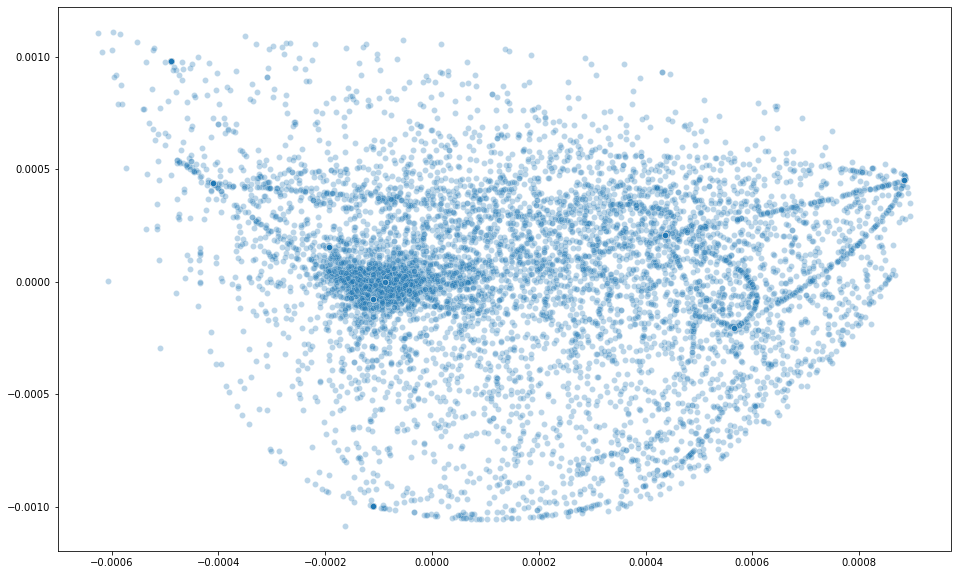

In [87]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(genesEmbeddingsTumorStageI)
firstDim = pca_result[:,0]
secondDim = pca_result[:,1] 
thirdDim = pca_result[:,2]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=firstDim, y=secondDim,
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.3
)

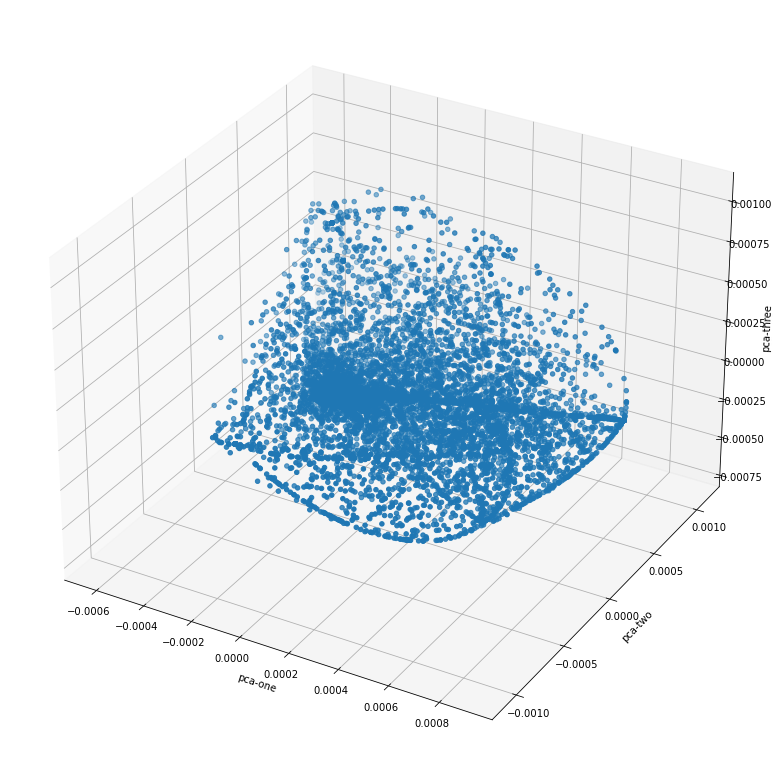

In [88]:
ax = plt.figure(figsize=(16,14)).gca(projection='3d')
ax.scatter(
    xs=firstDim, 
    ys=secondDim, 
    zs=thirdDim, 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

## Genes embeddings for **Stage II** tumors

In [89]:
stageIIExprMatrixShort = stageIIExprMatrix.sample(n=stageIExprMatrix.shape[1], axis='columns', random_state=2)
directedGraphTumor = sg.StellarDiGraph(stageIIExprMatrixShort ,geneEdgesTumor)
print(directedGraphTumor.info())

StellarDiGraph: Directed multigraph
 Nodes: 19727, Edges: 17264

 Node types:
  default: [19727]
    Features: float32 vector, length 180
    Edge types: default-default->default

 Edge types:
    default-default->default: [17264]
        Weights: range=[-1, 1], mean=0.68165, std=0.7317
        Features: none


In [90]:
batch_sizeTumor = int(tumorDK.shape[0])
#batch_sizeTumor = tumorDK.shape[0]
in_samples = [5, 2]
out_samples = [5, 2]
batch_sizeTumor

19727

In [91]:
generatorTumorStageII = DirectedGraphSAGENodeGenerator(directedGraphTumor, batch_sizeTumor, in_samples, out_samples)

In [92]:
#train_gen = generator.flow(train_subjects.index, train_subjects)
#val_gen = generator.flow(val_subjects.index, val_subjects)
trainGenTumorfinal = generatorTumorStageII.flow(stageIIExprMatrixShort.index, stageIIExprMatrixShort)

graphsage_modelTumorfinal = DirectedGraphSAGE(
    layer_sizes=[32, 32], generator=generatorTumorStageII, bias=False, dropout=0.5,
)

x_inpTumorfinal, x_outTumorfinal = graphsage_modelTumorfinal.in_out_tensors()
predictionTumorfinal = layers.Dense(units=stageIExprMatrix.shape[1], activation="softmax")(x_outTumorfinal)


In [93]:
modelTumorfinal = Model(inputs=x_inpTumorfinal, outputs=predictionTumorfinal)
modelTumorfinal.compile(
    optimizer=optimizers.Adam(learning_rate=0.005),
    loss=optimized_lossGNN(tensorEdgesTest=tensorEdgesTestTumor,constantTensor=constantTensorTumor),
    #loss=genes_loss_with_closure(edges=tensorEdgesTest),
    #loss = testLoss([0,1]),
    metrics=["acc"]
)

#test_gen = generator.flow(test_subjects.index, test_subjects)
modelTumorfinal.summary()



Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_37 (InputLayer)          [(None, 5, 180)]     0           []                               
                                                                                                  
 input_38 (InputLayer)          [(None, 5, 180)]     0           []                               
                                                                                                  
 input_39 (InputLayer)          [(None, 10, 180)]    0           []                               
                                                                                                  
 input_40 (InputLayer)          [(None, 10, 180)]    0           []                               
                                                                                            

In [94]:
checkpointPathTumorfinal = "model_checkpoints/GRAPHSAGEtumorGenesStageII.ckpt"
checkpointDirTumorfinal = os.path.dirname(checkpointPathTumorfinal)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpointPathTumorfinal,
                                                 save_weights_only=True,
                                                 verbose=1)


#modelTumorfinal.load_weights(checkpointPathTumorfinal)

In [95]:
history = modelTumorfinal.fit(
    trainGenTumorfinal, epochs=50, 
    #validation_data=test_gen,
    batch_size=batch_sizeTumor,
    verbose=2, 
    shuffle=False,
    callbacks=[cp_callback]
)

Epoch 1/50

Epoch 1: saving model to model_checkpoints/GRAPHSAGEtumorGenesStageII.ckpt
1/1 - 24s - loss: 53.4809 - acc: 0.0057 - 24s/epoch - 24s/step
Epoch 2/50

Epoch 2: saving model to model_checkpoints/GRAPHSAGEtumorGenesStageII.ckpt
1/1 - 21s - loss: 48.4542 - acc: 0.0085 - 21s/epoch - 21s/step
Epoch 3/50

Epoch 3: saving model to model_checkpoints/GRAPHSAGEtumorGenesStageII.ckpt
1/1 - 21s - loss: 42.3013 - acc: 0.0075 - 21s/epoch - 21s/step
Epoch 4/50

Epoch 4: saving model to model_checkpoints/GRAPHSAGEtumorGenesStageII.ckpt
1/1 - 19s - loss: 38.4755 - acc: 0.0055 - 19s/epoch - 19s/step
Epoch 5/50

Epoch 5: saving model to model_checkpoints/GRAPHSAGEtumorGenesStageII.ckpt
1/1 - 20s - loss: 34.0123 - acc: 0.0055 - 20s/epoch - 20s/step
Epoch 6/50

Epoch 6: saving model to model_checkpoints/GRAPHSAGEtumorGenesStageII.ckpt
1/1 - 18s - loss: 29.9842 - acc: 0.0061 - 18s/epoch - 18s/step
Epoch 7/50

Epoch 7: saving model to model_checkpoints/GRAPHSAGEtumorGenesStageII.ckpt
1/1 - 19s - l

In [96]:
modelTumorfinal.save_weights(checkpointPathTumorfinal.format(epoch=0))

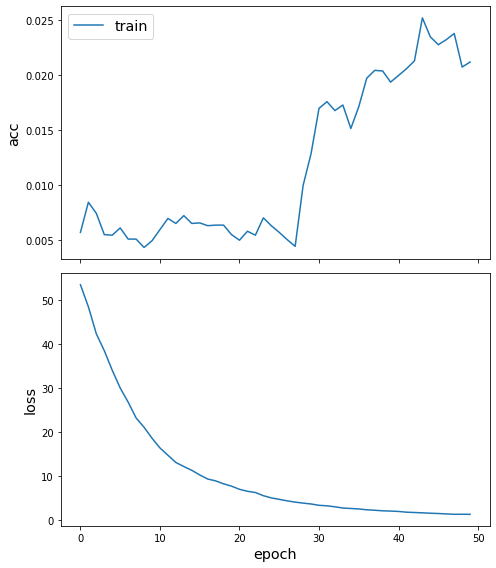

In [97]:
sg.utils.plot_history(history)

### generazione embedding per tumor Stage II

In [99]:
all_mapper = generatorTumorStageII.flow(stageIIExprMatrixShort.index)
all_predictions = modelTumorfinal.predict(all_mapper)
all_predictions = all_predictions.astype("float64")

genesEmbeddingsTumorStageII = pd.DataFrame(all_predictions, index =stageIIExprMatrixShort.index,columns =stageIIExprMatrixShort.columns)

In [100]:
genesEmbeddingsTumorStageII

TCGA-E2-A1B5  TCGA-OL-A5RW  TCGA-AR-A2LO  TCGA-A7-A26I  TCGA-A8-A07C  \
2          0.005634      0.005906      0.006169      0.006265      0.005645   
3          0.005540      0.005919      0.006175      0.006259      0.005799   
7          0.005627      0.005926      0.006155      0.006272      0.005649   
8          0.005628      0.005927      0.006157      0.006272      0.005651   
10         0.005634      0.005925      0.006165      0.006269      0.005651   
...             ...           ...           ...           ...           ...   
20526      0.005589      0.005967      0.006270      0.006218      0.005783   
20527      0.005627      0.005927      0.006156      0.006272      0.005652   
20528      0.005625      0.005928      0.006157      0.006271      0.005654   
20529      0.005628      0.005926      0.006157      0.006272      0.005651   
20530      0.005630      0.005927      0.006158      0.006272      0.005650   

       TCGA-D8-A1JK  TCGA-E9-A1N5  TCGA-WT-AB41  TCGA-AO-A125  TCGA-D8-A1JM  \
2          0.005056      0.006111      0.005749      0.005793      0.005721   
3          0.005003      0.006100      0.005725      0.005854      0.005677   
7          0.005064      0.006096      0.005764      0.005791      0.005714   
8          0.005067      0.006093      0.005772      0.005784      0.005712   
10         0.005071      0.006094      0.005780      0.005781      0.005710   
...             ...           ...           ...           ...           ...   
20526      0.005076      0.006074      0.005797      0.005745      0.005628   
20527      0.005065      0.006093      0.005769      0.005786      0.005712   
20528      0.005066      0.006093      0.005770      0.005785      0.005712   
20529      0.005066      0.006093      0.005772      0.005784      0.005712   
20530      0.005067      0.006092      0.005773      0.005783      0.005712   

       ...  TCGA-A2-A0T0  TCGA-D8-A1XF  TCGA-A7-A56D  TCGA-D8-A27G  \
2      ...      0.005971      0.005806      0.006169      0.006246   
3      ...      0.005865      0.005756      0.006066      0.006196   
7      ...      0.005949      0.005803      0.006154      0.006259   
8      ...      0.005952      0.005805      0.006163      0.006260   
10     ...      0.005949      0.005806      0.006163      0.006260   
...    ...           ...           ...           ...           ...   
20526  ...      0.005933      0.005779      0.006105      0.006159   
20527  ...      0.005951      0.005804      0.006160      0.006260   
20528  ...      0.005950      0.005804      0.006160      0.006260   
20529  ...      0.005951      0.005804      0.006162      0.006261   
20530  ...      0.005952      0.005805      0.006162      0.006261   

       TCGA-E2-A105  TCGA-A2-A0CR  TCGA-A1-A0SO  TCGA-LL-A5YL  TCGA-C8-A27A  \
2          0.004632      0.005443      0.005809      0.006183      0.004711   
3          0.004705      0.005404      0.005835      0.006198      0.004811   
7          0.004635      0.005432      0.005802      0.006187      0.004724   
8          0.004641      0.005436      0.005797      0.006189      0.004727   
10         0.004634      0.005438      0.005794      0.006190      0.004722   
...             ...           ...           ...           ...           ...   
20526      0.004684      0.005461      0.005779      0.006248      0.004891   
20527      0.004640      0.005435      0.005799      0.006188      0.004727   
20528      0.004639      0.005434      0.005799      0.006187      0.004726   
20529      0.004638      0.005435      0.005798      0.006188      0.004726   
20530      0.004636      0.005435      0.005797      0.006188      0.004726   

       TCGA-AC-A3TN  
2          0.006372  
3          0.006349  
7          0.006359  
8          0.006358  
10         0.006357  
...             ...  
20526      0.006381  
20527      0.006359  
20528      0.006358  
20529      0.006358  
20530      0.006359  

[19727 rows x 180 columns]

### visualizzazione embeddings StageII

<AxesSubplot:>

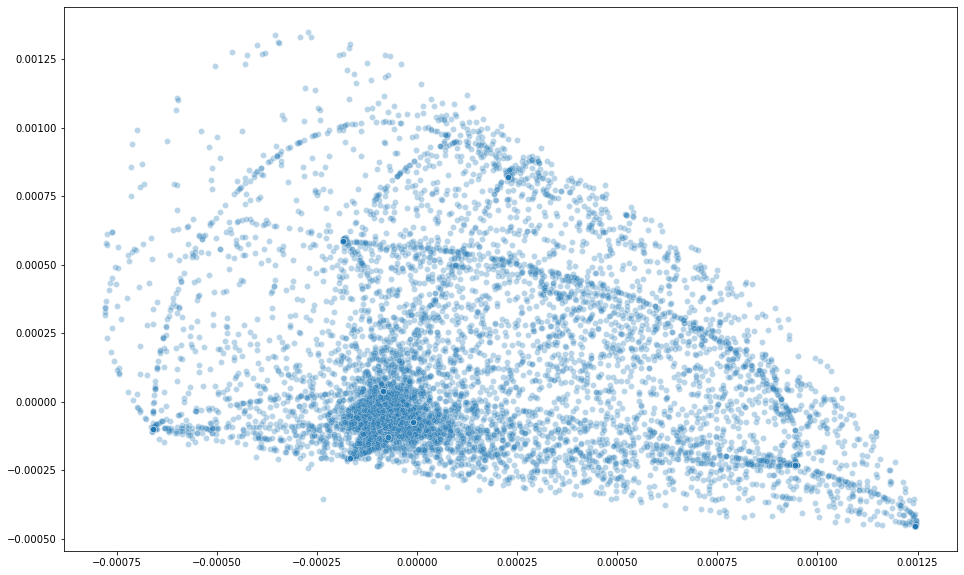

In [101]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(genesEmbeddingsTumorStageII)
firstDim = pca_result[:,0]
secondDim = pca_result[:,1] 
thirdDim = pca_result[:,2]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=firstDim, y=secondDim,
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.3
)

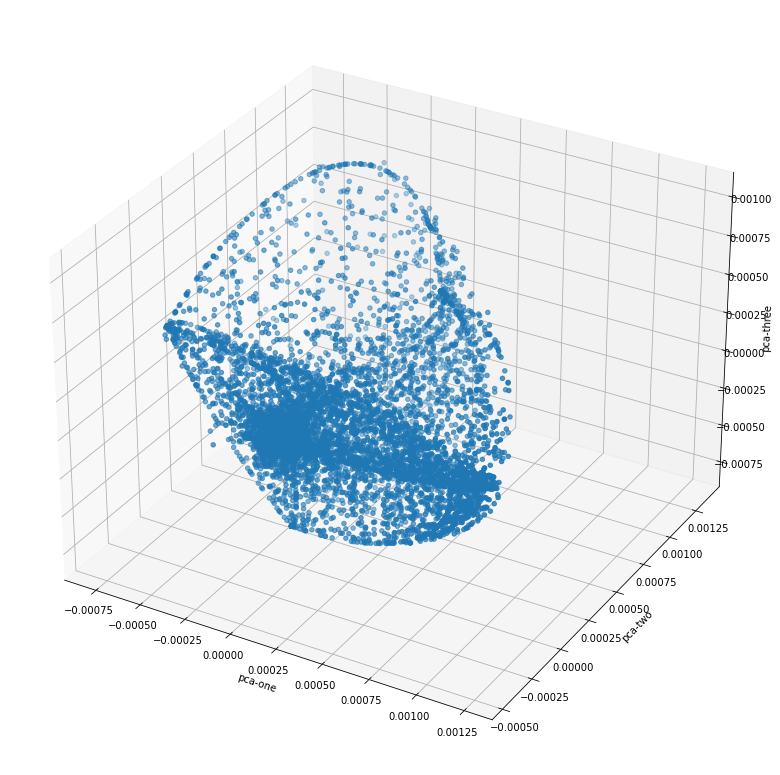

In [102]:
ax = plt.figure(figsize=(16,14)).gca(projection='3d')
ax.scatter(
    xs=firstDim, 
    ys=secondDim, 
    zs=thirdDim, 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

## Genes embeddings for **Stage III** tumors

In [103]:
stageIIIExprMatrixShort = stageIIIExprMatrix.sample(n=stageIExprMatrix.shape[1], axis='columns', random_state=2)
directedGraphTumor = sg.StellarDiGraph(stageIIIExprMatrixShort ,geneEdgesTumor)
print(directedGraphTumor.info())

StellarDiGraph: Directed multigraph
 Nodes: 19727, Edges: 17264

 Node types:
  default: [19727]
    Features: float32 vector, length 180
    Edge types: default-default->default

 Edge types:
    default-default->default: [17264]
        Weights: range=[-1, 1], mean=0.68165, std=0.7317
        Features: none


In [104]:
batch_sizeTumor = int(tumorDK.shape[0])
#batch_sizeTumor = tumorDK.shape[0]
in_samples = [5, 2]
out_samples = [5, 2]
batch_sizeTumor

19727

In [105]:
generatorTumorStageIII = DirectedGraphSAGENodeGenerator(directedGraphTumor, batch_sizeTumor, in_samples, out_samples)

In [106]:
#train_gen = generator.flow(train_subjects.index, train_subjects)
#val_gen = generator.flow(val_subjects.index, val_subjects)
trainGenTumorfinal = generatorTumorStageIII.flow(stageIIIExprMatrixShort.index, stageIIIExprMatrixShort)

graphsage_modelTumorfinal = DirectedGraphSAGE(
    layer_sizes=[32, 32], generator=generatorTumorStageIII, bias=False, dropout=0.5,
)

x_inpTumorfinal, x_outTumorfinal = graphsage_modelTumorfinal.in_out_tensors()
predictionTumorfinal = layers.Dense(units=stageIIIExprMatrixShort.shape[1], activation="softmax")(x_outTumorfinal)


In [107]:
modelTumorfinal = Model(inputs=x_inpTumorfinal, outputs=predictionTumorfinal)
modelTumorfinal.compile(
    optimizer=optimizers.Adam(learning_rate=0.005),
    loss=optimized_lossGNN(tensorEdgesTest=tensorEdgesTestTumor,constantTensor=constantTensorTumor),
    #loss=genes_loss_with_closure(edges=tensorEdgesTest),
    #loss = testLoss([0,1]),
    metrics=["acc"]
)

#test_gen = generator.flow(test_subjects.index, test_subjects)
modelTumorfinal.summary()



Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_44 (InputLayer)          [(None, 5, 180)]     0           []                               
                                                                                                  
 input_45 (InputLayer)          [(None, 5, 180)]     0           []                               
                                                                                                  
 input_46 (InputLayer)          [(None, 10, 180)]    0           []                               
                                                                                                  
 input_47 (InputLayer)          [(None, 10, 180)]    0           []                               
                                                                                            

In [108]:
checkpointPathTumorfinal = "model_checkpoints/GRAPHSAGEtumorGenesStageIII.ckpt"
checkpointDirTumorfinal = os.path.dirname(checkpointPathTumorfinal)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpointPathTumorfinal,
                                                 save_weights_only=True,
                                                 verbose=1)


#modelTumorfinal.load_weights(checkpointPathTumorfinal)

In [109]:
history = modelTumorfinal.fit(
    trainGenTumorfinal, epochs=50, 
    #validation_data=test_gen,
    batch_size=batch_sizeTumor,
    verbose=2, 
    shuffle=False,
    callbacks=[cp_callback]
)

Epoch 1/50

Epoch 1: saving model to model_checkpoints/GRAPHSAGEtumorGenesStageIII.ckpt
1/1 - 23s - loss: 48.0094 - acc: 0.0051 - 23s/epoch - 23s/step
Epoch 2/50

Epoch 2: saving model to model_checkpoints/GRAPHSAGEtumorGenesStageIII.ckpt
1/1 - 23s - loss: 42.9409 - acc: 0.0062 - 23s/epoch - 23s/step
Epoch 3/50

Epoch 3: saving model to model_checkpoints/GRAPHSAGEtumorGenesStageIII.ckpt
1/1 - 22s - loss: 38.6943 - acc: 0.0056 - 22s/epoch - 22s/step
Epoch 4/50

Epoch 4: saving model to model_checkpoints/GRAPHSAGEtumorGenesStageIII.ckpt
1/1 - 20s - loss: 35.7220 - acc: 0.0063 - 20s/epoch - 20s/step
Epoch 5/50

Epoch 5: saving model to model_checkpoints/GRAPHSAGEtumorGenesStageIII.ckpt
1/1 - 22s - loss: 32.0655 - acc: 0.0062 - 22s/epoch - 22s/step
Epoch 6/50

Epoch 6: saving model to model_checkpoints/GRAPHSAGEtumorGenesStageIII.ckpt
1/1 - 24s - loss: 28.7676 - acc: 0.0070 - 24s/epoch - 24s/step
Epoch 7/50

Epoch 7: saving model to model_checkpoints/GRAPHSAGEtumorGenesStageIII.ckpt
1/1 - 

In [110]:
modelTumorfinal.save_weights(checkpointPathTumorfinal.format(epoch=0))

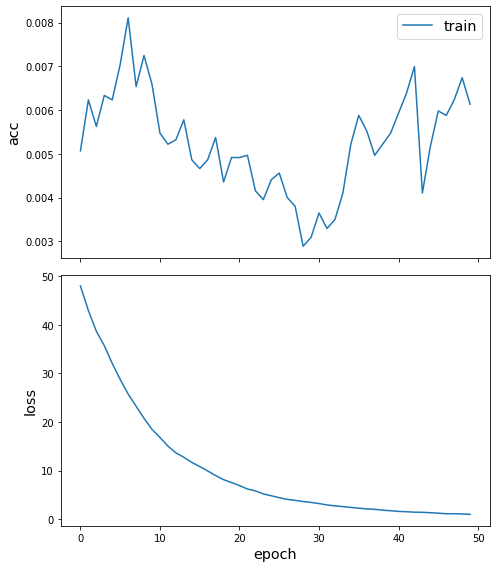

In [111]:
sg.utils.plot_history(history)

### generazione embedding per tumor Stage III

In [114]:
all_mapper = generatorTumorStageIII.flow(stageIIIExprMatrixShort.index)
all_predictions = modelTumorfinal.predict(all_mapper)
all_predictions = all_predictions.astype("float64")

genesEmbeddingsTumorStageIII = pd.DataFrame(all_predictions, index =stageIIIExprMatrixShort.index,columns =stageIIIExprMatrixShort.columns)

In [115]:
genesEmbeddingsTumorStageIII

TCGA-D8-A27T  TCGA-AQ-A1H2  TCGA-C8-A8HR  TCGA-EW-A2FR  TCGA-AQ-A1H3  \
2          0.006219      0.006286      0.004875      0.006219      0.006301   
3          0.006216      0.006292      0.004871      0.006226      0.006292   
7          0.006215      0.006302      0.004885      0.006231      0.006301   
8          0.006219      0.006298      0.004881      0.006223      0.006303   
10         0.006217      0.006295      0.004885      0.006224      0.006297   
...             ...           ...           ...           ...           ...   
20526      0.006216      0.006314      0.004860      0.006224      0.006295   
20527      0.006219      0.006294      0.004878      0.006223      0.006306   
20528      0.006219      0.006291      0.004877      0.006220      0.006297   
20529      0.006218      0.006297      0.004881      0.006226      0.006306   
20530      0.006219      0.006299      0.004876      0.006225      0.006304   

       TCGA-GM-A3XG  TCGA-E9-A3Q9  TCGA-A7-A4SB  TCGA-A8-A06T  TCGA-AN-A0XR  \
2          0.004800      0.006168      0.004674      0.004827      0.004837   
3          0.004798      0.006164      0.004666      0.004816      0.004840   
7          0.004815      0.006158      0.004671      0.004822      0.004834   
8          0.004813      0.006165      0.004671      0.004823      0.004840   
10         0.004817      0.006162      0.004676      0.004821      0.004840   
...             ...           ...           ...           ...           ...   
20526      0.004797      0.006166      0.004679      0.004808      0.004833   
20527      0.004813      0.006170      0.004673      0.004823      0.004839   
20528      0.004811      0.006168      0.004674      0.004820      0.004845   
20529      0.004817      0.006168      0.004677      0.004825      0.004838   
20530      0.004810      0.006169      0.004676      0.004819      0.004839   

       ...  TCGA-A2-A25E  TCGA-AO-A0JL  TCGA-AN-A0FZ  TCGA-BH-A0DV  \
2      ...      0.006263      0.006279      0.006312      0.006041   
3      ...      0.006274      0.006271      0.006301      0.006033   
7      ...      0.006280      0.006275      0.006303      0.006044   
8      ...      0.006273      0.006276      0.006304      0.006043   
10     ...      0.006273      0.006277      0.006306      0.006040   
...    ...           ...           ...           ...           ...   
20526  ...      0.006262      0.006268      0.006310      0.006037   
20527  ...      0.006272      0.006278      0.006305      0.006042   
20528  ...      0.006266      0.006276      0.006305      0.006037   
20529  ...      0.006271      0.006278      0.006304      0.006044   
20530  ...      0.006269      0.006277      0.006307      0.006039   

       TCGA-AC-A3EH  TCGA-A8-A06Q  TCGA-A8-A07U  TCGA-BH-A0E0  TCGA-AN-A0XT  \
2          0.005373      0.004795      0.004719      0.005754      0.006057   
3          0.005366      0.004796      0.004722      0.005760      0.006064   
7          0.005378      0.004803      0.004727      0.005754      0.006062   
8          0.005371      0.004797      0.004723      0.005759      0.006063   
10         0.005373      0.004799      0.004718      0.005756      0.006064   
...             ...           ...           ...           ...           ...   
20526      0.005367      0.004772      0.004757      0.005763      0.006051   
20527      0.005368      0.004794      0.004724      0.005761      0.006063   
20528      0.005370      0.004791      0.004715      0.005760      0.006062   
20529      0.005371      0.004791      0.004722      0.005758      0.006061   
20530      0.005373      0.004788      0.004727      0.005761      0.006058   

       TCGA-E2-A108  
2          0.004878  
3          0.004867  
7          0.004870  
8          0.004877  
10         0.004871  
...             ...  
20526      0.004899  
20527      0.004880  
20528      0.004876  
20529      0.004881  
20530      0.004884  

[19727 rows x 180 columns]

### visualizzazione embeddings StageIII

<AxesSubplot:>

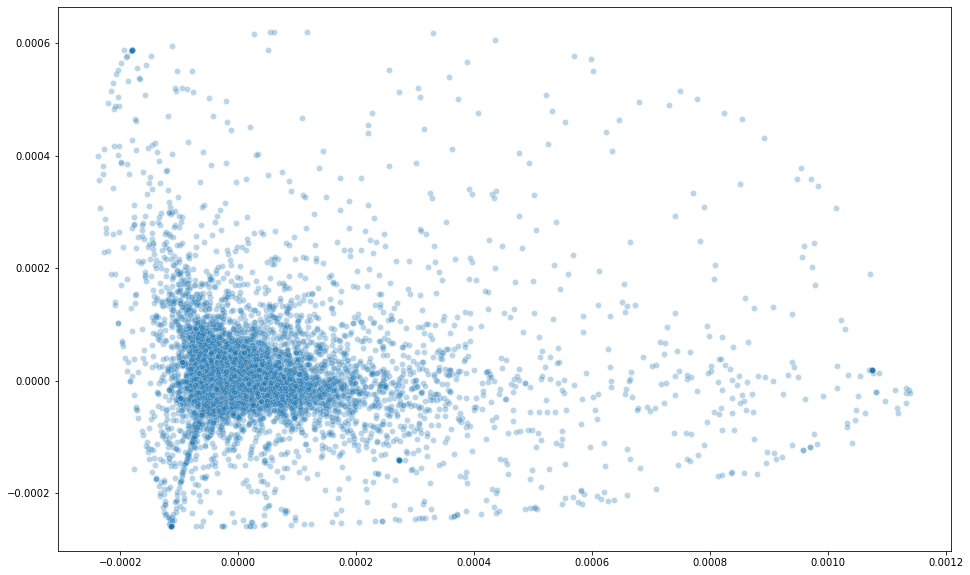

In [116]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(genesEmbeddingsTumorStageIII)
firstDim = pca_result[:,0]
secondDim = pca_result[:,1] 
thirdDim = pca_result[:,2]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=firstDim, y=secondDim,
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.3
)

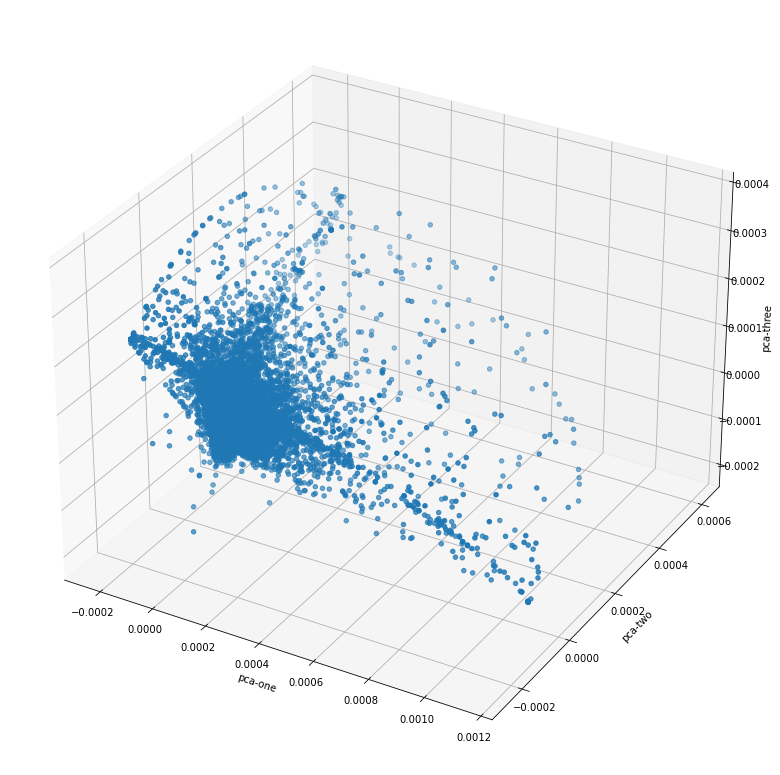

In [117]:
ax = plt.figure(figsize=(16,14)).gca(projection='3d')
ax.scatter(
    xs=firstDim, 
    ys=secondDim, 
    zs=thirdDim, 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

# Pathway embedding

### betweenness of genes in metapathways

In [89]:
import networkx as nx

In [90]:
geneEdges

source  target  weight
3        3640   59350       1
4      284217    3680       1
5      284217    3696       1
6      284217    3674       1
7      284217    3675       1
...       ...     ...     ...
28905    3627    1233       1
28906    3627    1232       1
28907    3627    2829       1
28908    3627   10663       1
28909    3627    2826       1

[19947 rows x 3 columns]

In [91]:
Gcontrols = nx.DiGraph()
Gtumors = nx.DiGraph()

for index, row in geneEdges.iterrows():
    Gcontrols.add_edge(row[0],row[1])
for index, row in geneEdgesTumor.iterrows():
    Gtumors.add_edge(row[0],row[1])

In [92]:
betweennessList = nx.betweenness_centrality(Gcontrols,normalized = True, 
                                              endpoints = False)

# Preliminary definitions

In [295]:
def printDS(dataset):
    for index,elem in dataset:
      print(elem.numpy())
    return

def gene_weight(geneIndex,dictBetw):
    if(geneIndex in dictBetw):
        return dictBetw[geneIndex] + 1.0
    else:
        return 1.0

In [235]:
def getPathwayEmbedding(partialVec,Wmat):
    partialvec_tensor = tf.constant(partialVec,dtype=tf.float64)
    W_tensor = Wmat #tf.constant(Wmat,dtype=tf.float64)  #Wmat could be already a tensor
    trasformedPartialVec = tf.linalg.matvec(W_tensor,partialvec_tensor)  #W_tensor @ partialvec_tensor
    finalVec = tf.map_fn(sigmoid,trasformedPartialVec)
    return finalVec

@tf.function
def sigmoid_log(x):
    return 1.0 / (1.0 + tf.math.exp(-tf.math.log(x)))

@tf.function( experimental_relax_shapes=True)
def getPathwayEmbeddingEnhancedFinal(partialsVec_tensor,Wmat):
    W_tensor = Wmat #tf.constant(Wmat,dtype=tf.float64)  #Wmat could be already a tensor
    trasformedPartialVec = W_tensor @ partialsVec_tensor
    finalVec = tf.map_fn(lambda values: tf.map_fn(tf.nn.leaky_relu,values),trasformedPartialVec)
    return finalVec

In [236]:
@tf.function
def combine(x, y):
  xx, yy = tf.meshgrid(x, y, indexing='ij')
  return tf.stack([tf.reshape(xx, [-1]), tf.reshape(yy, [-1])], axis=1)

def compute_not_equal_path(pathways,coup):
    if(coup[0]!=coup[1]):
        return len(set(pathways["nodes_set"][coup[0]]) & set(pathways["nodes_set"][coup[1]]))/len(set(pathways["nodes_set"][coup[0]]) | set(pathways["nodes_set"][coup[1]]))*10 +1
    else:
        return 0.0
def precompute_pathways_weight(pathways,coupPath):
    return list(map(lambda coup: compute_not_equal_path(pathways,coup) ,coupPath))

In [237]:
@tf.function( experimental_relax_shapes=True)
def getLoss(pathwaysEmbeddingTensor,loss):
    for zPi in pathwaysEmbeddingTensor:
        #print(zPi.get_shape())
        for zPj in pathwaysEmbeddingTensor:
            loss = loss + tf.sqrt(tf.reduce_sum(tf.square(zPi - zPj)) + 1.0e-12)   #tf.norm is unstable
    return 1/loss

@tf.function
def pathway_embedding_norm(pathwayEmbedding, couple):
    path1 = pathwayEmbedding[couple[0]]
    path2 = pathwayEmbedding[couple[1]]
    return tf.sqrt(tf.reduce_sum(tf.square(path1 - path2)) + 1.0e-12)

@tf.function
def loss_opt(pathwaysEmbeddingTensor,pathwayCoup, weightTensor):
    test = tf.map_fn(lambda couple: pathway_embedding_norm(pathwaysEmbeddingTensor,couple),pathwayCoup,fn_output_signature=tf.float64)
    return tf.reduce_sum(tf.math.multiply(test,weightTensor))

In [238]:
import pickle
def saveVariables(filename, variables): #where 'variables' is a list of variables
    with open(filename, 'wb+') as file:
       pickle.dump(variables, file)

def retrieveVariables(filename):
    variables = []
    with open(str(filename), 'rb') as file:
        variables = pickle.load(file)
    return variables

## Pathway embeddings for controls

In [232]:
tfDatasetGenesExpressions = tf.data.Dataset.from_tensor_slices((genesEmbeddings.index,genesEmbeddings.values))
normalizer_constant = genesEmbeddings.max().max()
normalizer_constant

0.01206990983337164

In [233]:
#listatest =  ['3915','79728','3293'] 
#listatest = list(map(int, listatest))

#keys_tensor = tf.constant(listatest,dtype=tf.int64)
#vals_tensor = tf.ones_like(keys_tensor)  # Ones will be casted to True.

#table = tf.lookup.StaticHashTable(
#    tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor),
#    default_value=0)  # If index not in table, return 0.


#def hash_table_filter(index, value):
#    table_value = table.lookup(index)  # 1 if index in arr, else 0.
#    index_in_arr =  tf.cast(table_value, tf.bool) # 1 -> True, 0 -> False
#    return index_in_arr

#def filterdatasetOnIndex(ds):
#    return ds.filter(hash_table_filter)

#filtered = tfDatasetGenesExpressions.apply(filterdatasetOnIndex)
#single = filtered.map(lambda index,value : value).reduce(np.float64(0.0),lambda x,y: x+y)/ len(listatest)
#single.numpy()

In [298]:
gene_weight(3680,betweennessList)

1.0000875950430819

In [296]:
#geneWeights = tf.constant(list(map(lambda value: gene_weight(value,betweennessList),list(genesEmbeddings.index))),dtype=tf.float64)
geneWeights = list(map(lambda value: gene_weight(value,betweennessList),list(genesEmbeddings.index)))

In [301]:
exprMatrixWeighted = genesEmbeddings.mul(geneWeights,axis=0)
exprMatrixWeighted

0         1         2         3         4         5    \
1          0.008809  0.008103  0.009435  0.007700  0.009389  0.010149   
2          0.008772  0.008112  0.009471  0.007624  0.009638  0.010399   
9          0.008810  0.008104  0.009436  0.007702  0.009390  0.010150   
10         0.008815  0.008285  0.009376  0.007529  0.009407  0.010066   
12         0.008810  0.008104  0.009436  0.007702  0.009390  0.010150   
...             ...       ...       ...       ...       ...       ...   
100302401  0.008622  0.008470  0.009315  0.007489  0.009212  0.009768   
100302640  0.008771  0.008361  0.009399  0.007837  0.009565  0.010143   
100302692  0.008809  0.008103  0.009435  0.007700  0.009389  0.010149   
100302736  0.008832  0.008110  0.009447  0.007725  0.009364  0.010141   
100303728  0.008805  0.008095  0.009425  0.007690  0.009376  0.010136   

                6         7         8         9    ...       103       104  \
1          0.009932  0.008103  0.008418  0.009885  ...  0.009951  0.009871   
2          0.009942  0.008378  0.008696  0.010056  ...  0.009895  0.009836   
9          0.009931  0.008101  0.008417  0.009884  ...  0.009950  0.009870   
10         0.009792  0.008158  0.008143  0.009766  ...  0.009914  0.010238   
12         0.009931  0.008101  0.008417  0.009884  ...  0.009950  0.009870   
...             ...       ...       ...       ...  ...       ...       ...   
100302401  0.009880  0.007959  0.008166  0.009499  ...  0.009684  0.010191   
100302640  0.009739  0.008029  0.008381  0.009826  ...  0.009950  0.010267   
100302692  0.009932  0.008103  0.008418  0.009885  ...  0.009951  0.009871   
100302736  0.009893  0.008053  0.008380  0.009850  ...  0.009940  0.009849   
100303728  0.009932  0.008111  0.008420  0.009885  ...  0.009958  0.009873   

                105       106       107       108       109       110  \
1          0.009921  0.009924  0.008210  0.007577  0.008449  0.008277   
2          0.009954  0.010217  0.008207  0.007435  0.008463  0.008284   
9          0.009921  0.009923  0.008210  0.007576  0.008448  0.008277   
10         0.009536  0.009851  0.008125  0.007486  0.008557  0.008252   
12         0.009921  0.009923  0.008210  0.007576  0.008448  0.008277   
...             ...       ...       ...       ...       ...       ...   
100302401  0.009747  0.009971  0.008299  0.007353  0.008226  0.008489   
100302640  0.009525  0.009797  0.008097  0.007489  0.008727  0.007978   
100302692  0.009921  0.009924  0.008210  0.007577  0.008449  0.008277   
100302736  0.009927  0.009882  0.008211  0.007582  0.008439  0.008271   
100303728  0.009916  0.009918  0.008211  0.007590  0.008453  0.008275   

                111       112  
1          0.009588  0.009859  
2          0.009662  0.010040  
9          0.009586  0.009859  
10         0.009868  0.009808  
12         0.009586  0.009859  
...             ...       ...  
100302401  0.009775  0.009659  
100302640  0.009743  0.009757  
100302692  0.009588  0.009859  
100302736  0.009561  0.009861  
100303728  0.009601  0.009855  

[17129 rows x 113 columns]

In [302]:
tfExprMatrixWeighted = tf.data.Dataset.from_tensor_slices((exprMatrixWeighted.index,exprMatrixWeighted.values))

In [303]:
def getPartialVec(Nodes):
    listatest =  Nodes.split(";")  
    listatest = list(map(int, listatest))  

    keys_tensor = tf.constant(listatest,dtype=tf.int64)
    vals_tensor = tf.ones_like(keys_tensor)  # Ones will be casted to True.

    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor),
        default_value=0)  # If index not in table, return 0.

    def hash_table_filter(index, value):
        table_value = table.lookup(index)  # 1 if index in arr, else 0.
        index_in_arr =  tf.cast(table_value, tf.bool) # 1 -> True, 0 -> False
        return index_in_arr

    tfFiltered = tfExprMatrixWeighted.filter(hash_table_filter)
    tfFiltered = tfFiltered.map(lambda index,value : value).reduce(np.float64(0.0),lambda x,y: x+y)/ (len(listatest) * normalizer_constant)  #additional normalization by 100 000, otherwise with normalization costant, that is the maximum of all the record genes 
    return tfFiltered.numpy()
    

pathways["partialsVectors"] = pathways["nodes"].map(getPartialVec)

In [304]:
pathways["partialsVectors"].where(pathways["partialsVectors"].map(lambda value: not not value.shape)).dropna()

0      [0.7401471347940944, 0.683704739297084, 0.7938...
1      [0.8266325481154464, 0.7656294293775374, 0.887...
2      [0.7326011299461459, 0.6807482904785247, 0.788...
3      [0.7014047509838489, 0.6594855325144596, 0.760...
4      [0.7803752698400064, 0.7290376832445122, 0.841...
                             ...                        
222    [0.7818408498895707, 0.7224573607697259, 0.838...
223    [0.7546516203156381, 0.7074037258924396, 0.815...
224    [0.6872095051260426, 0.6377790857189249, 0.737...
225    [0.8286640126766981, 0.7679740571530321, 0.892...
226    [0.7656206248750382, 0.7113742155110123, 0.823...
Name: partialsVectors, Length: 226, dtype: object

In [305]:
pathways["partialsVectors"] = pathways["partialsVectors"].where(pathways["partialsVectors"].map(lambda value: not not value.shape))
pathways = pathways.dropna()

In [306]:
#sigmoid = lambda x: 1.0 / (1.0 + math.exp(-x))
#vfunc = np.vectorize(sigmoid)
#vfunc(pathways["partialsVectors"][0])
# problemi con numeri grandi, il risultato finale sono vettori di tutti 1

Transposing the feature tensor because we need It to be transposed to do the matrix multiplication of the feature(rows)

In [307]:
W = np.diag(np.full(len(pathways["partialsVectors"][0]),0.001))
W_tensor = tf.Variable(W,dtype=tf.float64)
npPartial = np.stack(pathways["partialsVectors"]).transpose()
partialsVectors_tensor = tf.constant(npPartial)
finalVectors_tensors = getPathwayEmbeddingEnhancedFinal(partialsVectors_tensor,W_tensor)
pathways["pathwayEmbeddings"]= finalVectors_tensors.numpy().transpose().tolist() #tf.make_ndarray(finalVectors_tensors)
#pathways["pathwayEmbeddings"][0]

In [308]:
pathways["nodes_set"] = list(map(lambda nodes: nodes.split(";") ,pathways["nodes"]))

In [309]:
pathwayPairs = combine(tf.constant(list(pathways.index)),tf.constant(list(pathways.index)))
pathwayPairs.numpy()[0]

array([0, 0], dtype=int32)

In [310]:
indexOfPathways = dict()

for i in range(0,len(pathways.index)):
    indexOfPathways[pathways.index[i]] = i

tensorPathways = tf.map_fn(lambda row: tf.map_fn(lambda element:indexOfPathways[element.numpy()],tf.gather(row, [0, 1]).numpy()) ,pathwayPairs)  # take only edges with no weight

In [311]:
precomputed_weight_pathways = tf.constant(precompute_pathways_weight(pathways,pathwayPairs.numpy()),dtype=tf.float64)

In [312]:
loss = tf.Variable(0.0,dtype="float64")
#firstLoss = getLoss(tf.transpose(finalVectors_tensors),loss).numpy()
firstLoss = loss_opt(tf.transpose(finalVectors_tensors),tensorPathways,precomputed_weight_pathways).numpy()

In [313]:
firstLoss

50.569143086167415

In [318]:
W_numpy = np.diag(np.full(len(pathways["partialsVectors"][0]),1))
W = tf.Variable(W_numpy,dtype=tf.float64,name = "W")
npPartial = np.stack(pathways["partialsVectors"]).transpose()
partialsVectors_tensor = tf.constant(npPartial)  #tf.make_tensor_proto(npPartial)
loss = tf.Variable(0.0,dtype="float64")

In [236]:
with tf.GradientTape(persistent=True) as tape:
    loss.assign(0.0)
    tape.watch(W)
    finalVectors_tensors = getPathwayEmbeddingEnhancedFinal(partialsVectors_tensor,W)
    loss = loss_opt(tf.transpose(finalVectors_tensors),tensorPathways,precomputed_weight_pathways)
    #loss =  getLoss(tf.transpose(finalVectors_tensors),loss)
tape.gradient(loss, W)


<tf.Tensor: shape=(113, 113), dtype=float64, numpy=
array([[6.12087831, 5.80743206, 6.66542873, ..., 5.95189053, 6.7952434 ,
        7.11440458],
       [5.80743206, 5.51004258, 6.32410025, ..., 5.6471    , 6.4472652 ,
        6.75008352],
       [6.66542873, 6.32410025, 7.25843048, ..., 6.48140868, 7.39978975,
        7.74734641],
       ...,
       [5.95189053, 5.6471    , 6.48140868, ..., 5.78757065, 6.60763676,
        6.91798884],
       [6.7952434 , 6.4472652 , 7.39978975, ..., 6.60763676, 7.5439116 ,
        7.89823135],
       [7.11440458, 6.75008352, 7.74734641, ..., 6.91798884, 7.89823135,
        8.26920156]])>

In [ ]:
loss_progression = np.array([11000])
loss = tf.Variable(0.0,dtype="float64")

In [323]:
learning_rate = 0.000001
for i in range(0,20):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(W)
        finalVectors_tensors = getPathwayEmbeddingEnhancedFinal(partialsVectors_tensor,W)
        loss = loss_opt(tf.transpose(finalVectors_tensors),tensorPathways,precomputed_weight_pathways)
        #loss =  getLoss(tf.transpose(finalVectors_tensors),loss)
    dl_dw = tape.gradient(loss, W)
    W.assign_sub(learning_rate * dl_dw)
    loss_progression = np.append(loss_progression,loss.numpy())
    #loss_progression = np.append(loss_progression,getLoss(tf.transpose(finalVectors_tensors),loss).numpy())
    print(loss)

tf.Tensor(1487.4890940577172, shape=(), dtype=float64)
tf.Tensor(1446.8251149563835, shape=(), dtype=float64)
tf.Tensor(1396.6350301678513, shape=(), dtype=float64)
tf.Tensor(1349.7245163734283, shape=(), dtype=float64)
tf.Tensor(1306.5895671370213, shape=(), dtype=float64)
tf.Tensor(1267.3872411540603, shape=(), dtype=float64)
tf.Tensor(1232.2308050230108, shape=(), dtype=float64)
tf.Tensor(1201.296158908536, shape=(), dtype=float64)
tf.Tensor(1177.4164658313439, shape=(), dtype=float64)
tf.Tensor(1156.344827072759, shape=(), dtype=float64)
tf.Tensor(1142.0466297474975, shape=(), dtype=float64)
tf.Tensor(1128.1082771633626, shape=(), dtype=float64)
tf.Tensor(1119.203614968691, shape=(), dtype=float64)
tf.Tensor(1118.227721729264, shape=(), dtype=float64)
tf.Tensor(1121.1140869274552, shape=(), dtype=float64)
tf.Tensor(1156.3777507191198, shape=(), dtype=float64)
tf.Tensor(1171.345937416249, shape=(), dtype=float64)
tf.Tensor(1159.17551924206, shape=(), dtype=float64)
tf.Tensor(1152.37

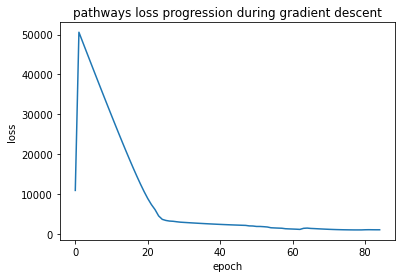

In [325]:
x = np.arange(0,85)
plt.title("pathways loss progression during gradient descent") 
plt.xlabel("epoch") 
plt.ylabel("loss") 
plt.plot(x,loss_progression) 
plt.show()

In [326]:
saveVariables("pathwayParameterMatrix.txt",[W])

In [327]:
W = retrieveVariables("pathwayParameterMatrix.txt")[0]
W

<tf.Variable 'W:0' shape=(113, 113) dtype=float64, numpy=
array([[ 0.99071449, -0.007898  , -0.00954859, ..., -0.00798403,
        -0.00958121, -0.00941912],
       [-0.00783131,  0.99250923, -0.0085821 , ..., -0.00769769,
        -0.00870703, -0.00921964],
       [-0.00939766, -0.0085259 ,  0.98995982, ..., -0.00874792,
        -0.01007909, -0.01039745],
       ...,
       [-0.00786593, -0.00764139, -0.00872738, ...,  0.9920191 ,
        -0.00883334, -0.00955138],
       [-0.00972389, -0.00875547, -0.01026524, ..., -0.00883393,
         0.98949611, -0.0104595 ],
       [-0.00944614, -0.00929832, -0.01055203, ..., -0.00971194,
        -0.0106933 ,  0.98828885]])>

In [328]:
finalVectors_tensors = getPathwayEmbeddingEnhancedFinal(partialsVectors_tensor,W)
pathways = pathways.drop("pathwayEmbeddings",axis=1)
pathways["pathwayEmbeddings"]= finalVectors_tensors.numpy().transpose().tolist()

In [329]:
pathways

pathway_id                                  pathway_name  \
0    path:hsa00190                     Oxidative phosphorylation   
1    path:hsa00072    Synthesis and degradation of ketone bodies   
2    path:hsa01040       Biosynthesis of unsaturated fatty acids   
3    path:hsa04672  Intestinal immune network for IgA production   
4    path:hsa03460                        Fanconi anemia pathway   
..             ...                                           ...   
222  path:hsa03013                                 RNA transport   
223  path:hsa04340                    Hedgehog signaling pathway   
224  path:hsa03018                               RNA degradation   
225  path:hsa00785                        Lipoic acid metabolism   
226  path:hsa03015                     mRNA surveillance pathway   

                                                 nodes  \
0    64077;5464;245972;245973;479;513;514;515;516;5...   
1      64064;38;39;3155;56898;54511;622;3158;3157;5019   
2    641371;79966;6319;570;9415;3992;10965;122970;1...   
3    4055;8174;959;8741;3600;23308;102723407;6370;5...   
4    3280;378708;55120;672;84126;675;2189;83990;229...   
..                                                 ...   
222  8893;8891;8892;9984;8890;1975;340529;8662;8663...   
223  64399;122011;595;1456;1455;1454;1453;1452;6469...   
224  5042;132430;340529;8761;645974;26986;80336;992...   
225                          116285;11019;387787;51601   
226  81608;23049;2107;10898;10978;53981;4686;5976;5...   

                                       partialsVectors  \
0    [0.7401471347940944, 0.683704739297084, 0.7938...   
1    [0.8266325481154464, 0.7656294293775374, 0.887...   
2    [0.7326011299461459, 0.6807482904785247, 0.788...   
3    [0.7014047509838489, 0.6594855325144596, 0.760...   
4    [0.7803752698400064, 0.7290376832445122, 0.841...   
..                                                 ...   
222  [0.7818408498895707, 0.7224573607697259, 0.838...   
223  [0.7546516203156381, 0.7074037258924396, 0.815...   
224  [0.6872095051260426, 0.6377790857189249, 0.737...   
225  [0.8286640126766981, 0.7679740571530321, 0.892...   
226  [0.7656206248750382, 0.7113742155110123, 0.823...   

                                             nodes_set  \
0    [64077, 5464, 245972, 245973, 479, 513, 514, 5...   
1    [64064, 38, 39, 3155, 56898, 54511, 622, 3158,...   
2    [641371, 79966, 6319, 570, 9415, 3992, 10965, ...   
3    [4055, 8174, 959, 8741, 3600, 23308, 102723407...   
4    [3280, 378708, 55120, 672, 84126, 675, 2189, 8...   
..                                                 ...   
222  [8893, 8891, 8892, 9984, 8890, 1975, 340529, 8...   
223  [64399, 122011, 595, 1456, 1455, 1454, 1453, 1...   
224  [5042, 132430, 340529, 8761, 645974, 26986, 80...   
225                     [116285, 11019, 387787, 51601]   
226  [81608, 23049, 2107, 10898, 10978, 53981, 4686...   

                                     pathwayEmbeddings  
0    [-0.0018640588752978874, -0.001323535320621739...  
1    [-0.0024262036270765006, -0.001339893279683281...  
2    [-0.0025748377211555562, -0.001200053883522780...  
3    [-0.0034927964363732876, -0.000755356066202776...  
4    [-0.003258140087550573, -0.0011566495946730457...  
..                                                 ...  
222  [-0.002129166740217994, -0.0014915589486500214...  
223  [-0.0035500254283201385, -0.001052762296300610...  
224  [-0.0023190378248310107, -0.001260448015482329...  
225  [-0.00202671099644977, -0.0007727124204955857,...  
226  [-0.002640680094015983, -0.0013049959958493325...  

[226 rows x 6 columns]

In [330]:
pathways["pathway_name"].describe()

count                       226
unique                      226
top       p53 signaling pathway
freq                          1
Name: pathway_name, dtype: object

In [251]:
pathways["pathwayEmbeddings"][29]

[5.4645564973275e-10,
 5.042482988189707e-10,
 5.857313139763396e-10,
 4.779139025778383e-10,
 5.853589943554639e-10,
 6.326899646040765e-10,
 6.175671010582048e-10,
 5.057152971531486e-10,
 5.263667145140107e-10,
 6.158194451806859e-10,
 4.964583628955228e-10,
 5.050490242374847e-10,
 5.060942091905018e-10,
 5.579415393187345e-10,
 6.382972416133467e-10,
 5.401145649136298e-10,
 5.172521610201631e-10,
 5.156103165617628e-10,
 5.045378635994984e-10,
 5.01941637852936e-10,
 6.15817530631058e-10,
 5.389601638260345e-10,
 5.241702872391573e-10,
 5.343956122727781e-10,
 6.222434005811896e-10,
 6.160712205131387e-10,
 5.650985212770989e-10,
 4.4543127019536393e-10,
 4.480192325142494e-10,
 4.959482680395715e-10,
 6.39118670209577e-10,
 6.199430330339574e-10,
 6.171850591903514e-10,
 4.629329447752452e-10,
 4.5293692684556996e-10,
 6.005218560741706e-10,
 4.767384293879761e-10,
 4.830044633794205e-10,
 4.902295034779023e-10,
 4.917678609829794e-10,
 4.56015763774707e-10,
 4.933693552228951e-

In [331]:
onlyPathwayEmbeddings = pd.DataFrame(np.array(pathways["pathwayEmbeddings"].tolist()))

In [332]:
onlyPathwayEmbeddings["pathway_id"] = pathways["pathway_id"]
onlyPathwayEmbeddings

0         1         2         3         4         5         6  \
0   -0.001864 -0.001324 -0.000723 -0.003979 -0.011037 -0.007056 -0.002351   
1   -0.002426 -0.001340 -0.001045 -0.004201 -0.012533 -0.008876 -0.002859   
2   -0.002575 -0.001200 -0.001035 -0.003873 -0.010635 -0.007583 -0.002191   
3   -0.003493 -0.000755 -0.001101 -0.004443 -0.007395 -0.004756 -0.001841   
4   -0.003258 -0.001157 -0.001393 -0.004688 -0.009175 -0.005571 -0.001749   
..        ...       ...       ...       ...       ...       ...       ...   
221 -0.002129 -0.001492 -0.000868 -0.004024 -0.011750 -0.007828 -0.002335   
222 -0.003550 -0.001053 -0.001416 -0.004719 -0.008204 -0.004976 -0.001647   
223 -0.002319 -0.001260 -0.001203 -0.003856 -0.009317 -0.005888 -0.001735   
224 -0.002027 -0.000773  0.000668  0.002025 -0.013546 -0.008493 -0.004014   
225 -0.002641 -0.001305 -0.001037 -0.004241 -0.010079 -0.006498 -0.001843   

            7         8         9  ...       104       105       106  \
0   -0.004459 -0.021360 -0.008809  ... -0.002568 -0.002259 -0.007833   
1   -0.005409 -0.024896 -0.010152  ... -0.002670 -0.002526 -0.009201   
2   -0.004486 -0.021188 -0.008526  ... -0.003190 -0.001494 -0.007203   
3   -0.001691 -0.017472 -0.006212  ... -0.002415 -0.001946 -0.003811   
4   -0.002641 -0.019524 -0.007269  ... -0.003218 -0.001813 -0.005123   
..        ...       ...       ...  ...       ...       ...       ...   
221 -0.004956 -0.022754 -0.009310  ... -0.003087 -0.001903 -0.008289   
222 -0.002134 -0.018348 -0.006630  ... -0.002958 -0.001842 -0.004320   
223 -0.003330 -0.018454 -0.007287  ... -0.002984 -0.001591 -0.005971   
224 -0.007542 -0.023885 -0.010126  ... -0.002823 -0.002184 -0.010644   
225 -0.003589 -0.020701 -0.008090  ... -0.002935 -0.001830 -0.006404   

          107       108       109       110       111       112     pathway_id  
0   -0.001136 -0.008971 -0.001789 -0.001477 -0.001284 -0.004332  path:hsa00190  
1   -0.001441 -0.009750 -0.001511 -0.001890 -0.001464 -0.005524  path:hsa00072  
2   -0.001087 -0.009073 -0.001620 -0.001242 -0.001434 -0.004609  path:hsa01040  
3   -0.000936 -0.010639 -0.001075 -0.000764 -0.001388 -0.003416  path:hsa04672  
4   -0.000913 -0.010895 -0.001763 -0.000850 -0.001794 -0.003598  path:hsa03460  
..        ...       ...       ...       ...       ...       ...            ...  
221 -0.001213 -0.009307 -0.001887 -0.001500 -0.001613 -0.004810  path:hsa00780  
222 -0.001128 -0.011112 -0.001476 -0.000871 -0.001563 -0.003382  path:hsa03013  
223 -0.000859 -0.008581 -0.001623 -0.000957 -0.001530 -0.003503  path:hsa04340  
224 -0.000077 -0.009396 -0.000233 -0.002819 -0.003512 -0.006407  path:hsa03018  
225 -0.001086 -0.010051 -0.001847 -0.001163 -0.001668 -0.004209  path:hsa00785  

[226 rows x 114 columns]

In [333]:
onlyPathwayEmbeddings.to_csv("pathwayEmbeddingsControls.csv")

In [334]:
onlyPathwayEmbeddings.describe()

0           1           2           3           4           5    \
count  226.000000  226.000000  226.000000  226.000000  226.000000  226.000000   
mean    -0.003246   -0.000933   -0.001210   -0.004400   -0.008875   -0.006012   
std      0.001189    0.000441    0.000421    0.001002    0.002749    0.002020   
min     -0.005127   -0.001813   -0.001961   -0.005637   -0.013859   -0.009931   
25%     -0.004372   -0.001226   -0.001571   -0.005109   -0.011379   -0.007868   
50%     -0.003368   -0.000819   -0.001363   -0.004482   -0.007913   -0.005171   
75%     -0.002110   -0.000701   -0.000846   -0.003917   -0.006499   -0.004222   
max     -0.000546    0.002279    0.000668    0.003211   -0.000865   -0.000616   

              6           7           8           9    ...         103  \
count  226.000000  226.000000  226.000000  226.000000  ...  226.000000   
mean    -0.001732   -0.002885   -0.019630   -0.007382  ...   -0.000751   
std      0.000795    0.002050    0.003521    0.002025  ...    0.000367   
min     -0.004014   -0.007542   -0.027096   -0.011770  ...   -0.001362   
25%     -0.002495   -0.004879   -0.022716   -0.009183  ...   -0.001087   
50%     -0.001679   -0.002168   -0.018484   -0.006668  ...   -0.000827   
75%     -0.000995   -0.000996   -0.017320   -0.005699  ...   -0.000419   
max     -0.000161   -0.000161   -0.002275   -0.000785  ...    0.000412   

              104         105         106         107         108         109  \
count  226.000000  226.000000  226.000000  226.000000  226.000000  226.000000   
mean    -0.002628   -0.001970   -0.005291   -0.001115   -0.010508   -0.001434   
std      0.000820    0.000536    0.003013    0.000193    0.002037    0.000703   
min     -0.003900   -0.004213   -0.010665   -0.001923   -0.013722   -0.002262   
25%     -0.003037   -0.002109   -0.008078   -0.001224   -0.012304   -0.001709   
50%     -0.002844   -0.001833   -0.004245   -0.001106   -0.010362   -0.001548   
75%     -0.002436   -0.001641   -0.002526   -0.001035   -0.009064   -0.001307   
max      0.003021   -0.000225   -0.000386   -0.000077   -0.001502    0.007281   

              110         111         112  
count  226.000000  226.000000  226.000000  
mean    -0.000977   -0.001491   -0.004020  
std      0.000605    0.000509    0.000993  
min     -0.003682   -0.003512   -0.006420  
25%     -0.001519   -0.001779   -0.004933  
50%     -0.000773   -0.001615   -0.003590  
75%     -0.000448   -0.001377   -0.003188  
max     -0.000075    0.002149   -0.000445  

[8 rows x 113 columns]

<AxesSubplot:>

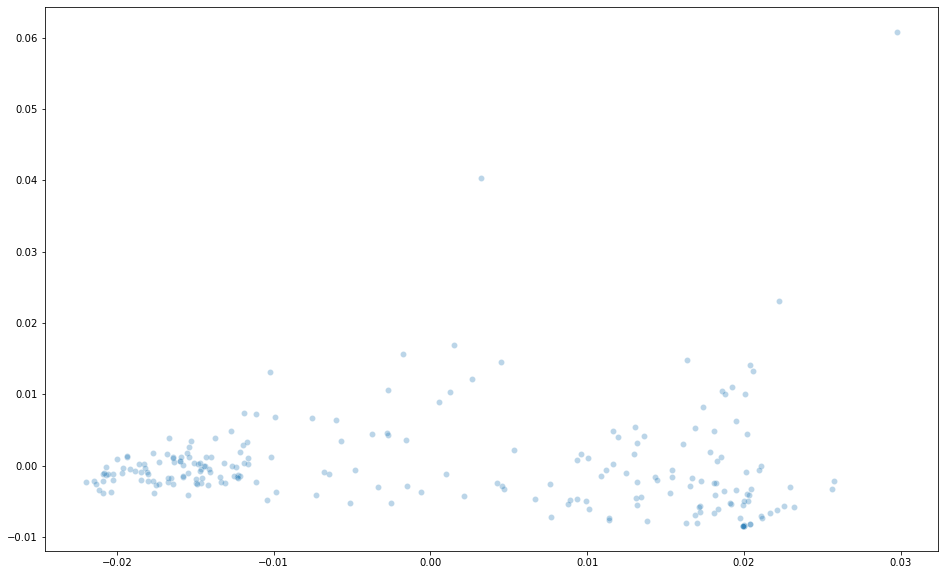

In [335]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(onlyPathwayEmbeddings.drop("pathway_id",axis=1))
firstDim = pca_result[:,0]
secondDim = pca_result[:,1] 
thirdDim = pca_result[:,2]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=firstDim, y=secondDim,
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.3
)

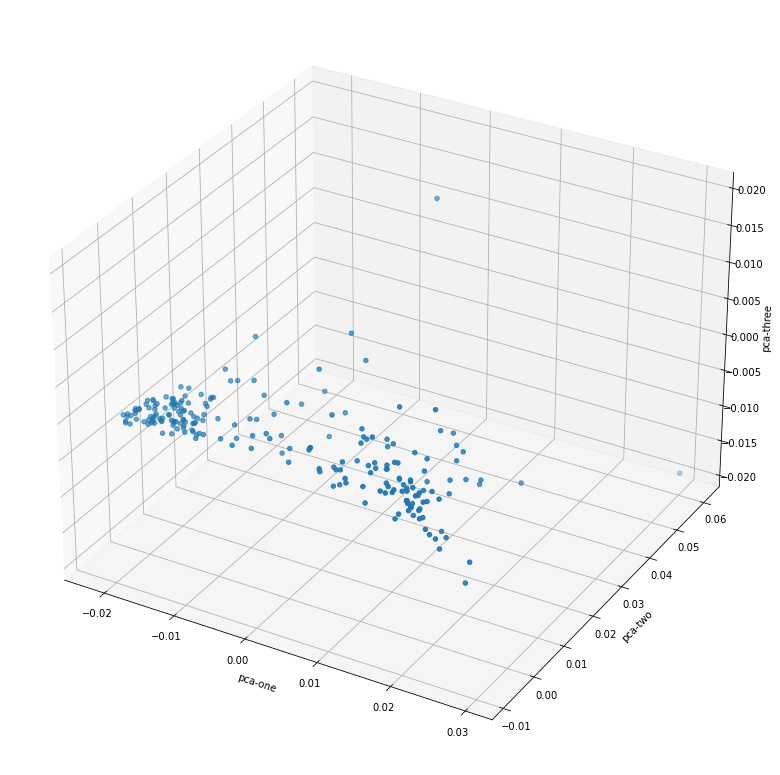

In [337]:
ax = plt.figure(figsize=(16,14)).gca(projection='3d')
ax.scatter(
    xs=firstDim, 
    ys=secondDim, 
    zs=thirdDim, 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

## Pathway embeddings for tumors(basal with 113 patients)

In [338]:
betweennessListTumors = nx.betweenness_centrality(Gtumors,normalized = True, 
                                              endpoints = False)

In [339]:
tfDatasetGenesExpressionsTumors = tf.data.Dataset.from_tensor_slices((genesEmbeddingsTumorBasal.index,genesEmbeddingsTumorBasal.values))
normalizer_constant = genesEmbeddingsTumorBasal.max().max()
normalizer_constant

0.010617491789162159

In [340]:
gene_weight(3680,betweennessListTumors)

1.0000899898388684

In [341]:
#geneWeights = tf.constant(list(map(lambda value: gene_weight(value,betweennessList),list(genesEmbeddings.index))),dtype=tf.float64)
geneWeightsTumor = list(map(lambda value: gene_weight(value,betweennessListTumors),list(genesEmbeddingsTumorBasal.index)))

In [342]:
genesEmbeddingsTumorBasal

0         1         2         3         4         5         6    \
2      0.009889  0.009964  0.009979  0.007803  0.009311  0.009556  0.008054   
3      0.009842  0.009957  0.009904  0.007829  0.009282  0.009592  0.008146   
7      0.009919  0.009968  0.009912  0.007793  0.009313  0.009579  0.008115   
8      0.009920  0.009974  0.009926  0.007781  0.009317  0.009591  0.008116   
10     0.009860  0.009968  0.009970  0.007817  0.009340  0.009532  0.008068   
...         ...       ...       ...       ...       ...       ...       ...   
20526  0.009879  0.009999  0.010037  0.007813  0.009289  0.009471  0.008228   
20527  0.009893  0.009976  0.009891  0.007812  0.009309  0.009592  0.008119   
20528  0.009845  0.009968  0.009967  0.007832  0.009334  0.009514  0.008096   
20529  0.009902  0.009962  0.009889  0.007811  0.009305  0.009595  0.008097   
20530  0.009867  0.009980  0.009856  0.007844  0.009301  0.009607  0.008100   

            7         8         9    ...       103       104       105  \
2      0.007488  0.010209  0.009345  ...  0.007833  0.009249  0.007828   
3      0.007530  0.010194  0.009336  ...  0.007875  0.009301  0.007835   
7      0.007509  0.010171  0.009366  ...  0.007818  0.009317  0.007773   
8      0.007481  0.010195  0.009360  ...  0.007851  0.009292  0.007795   
10     0.007461  0.010230  0.009372  ...  0.007911  0.009306  0.007831   
...         ...       ...       ...  ...       ...       ...       ...   
20526  0.007446  0.010254  0.009304  ...  0.007924  0.009312  0.007801   
20527  0.007519  0.010186  0.009363  ...  0.007823  0.009307  0.007808   
20528  0.007472  0.010259  0.009416  ...  0.007878  0.009264  0.007819   
20529  0.007545  0.010169  0.009369  ...  0.007822  0.009313  0.007794   
20530  0.007538  0.010182  0.009381  ...  0.007807  0.009308  0.007802   

            106       107       108       109       110       111       112  
2      0.009267  0.008085  0.010203  0.008458  0.010070  0.007591  0.010024  
3      0.009291  0.008158  0.010078  0.008508  0.010022  0.007637  0.010042  
7      0.009327  0.008133  0.010068  0.008484  0.010069  0.007659  0.010030  
8      0.009355  0.008106  0.010075  0.008488  0.010044  0.007657  0.010028  
10     0.009334  0.008086  0.010115  0.008498  0.010079  0.007615  0.010095  
...         ...       ...       ...       ...       ...       ...       ...  
20526  0.009291  0.008134  0.010057  0.008514  0.010019  0.007602  0.010057  
20527  0.009283  0.008143  0.010081  0.008497  0.010078  0.007636  0.010030  
20528  0.009255  0.008167  0.010101  0.008508  0.010111  0.007558  0.010056  
20529  0.009309  0.008142  0.010077  0.008492  0.010072  0.007658  0.010029  
20530  0.009253  0.008150  0.010090  0.008504  0.010108  0.007600  0.010041  

[19727 rows x 113 columns]

In [343]:
exprMatrixWeightedTumors = genesEmbeddingsTumorBasal.mul(geneWeightsTumor,axis=0)
exprMatrixWeightedTumors

0         1         2         3         4         5         6    \
2      0.009889  0.009964  0.009979  0.007803  0.009311  0.009556  0.008054   
3      0.009842  0.009957  0.009904  0.007829  0.009282  0.009592  0.008146   
7      0.009919  0.009968  0.009912  0.007793  0.009313  0.009579  0.008115   
8      0.009920  0.009974  0.009926  0.007781  0.009317  0.009591  0.008116   
10     0.009860  0.009968  0.009970  0.007817  0.009340  0.009532  0.008068   
...         ...       ...       ...       ...       ...       ...       ...   
20526  0.009879  0.009999  0.010037  0.007813  0.009289  0.009471  0.008228   
20527  0.009893  0.009976  0.009891  0.007812  0.009309  0.009592  0.008119   
20528  0.009845  0.009968  0.009967  0.007832  0.009334  0.009514  0.008096   
20529  0.009902  0.009962  0.009889  0.007811  0.009305  0.009595  0.008097   
20530  0.009867  0.009980  0.009856  0.007844  0.009301  0.009607  0.008100   

            7         8         9    ...       103       104       105  \
2      0.007488  0.010209  0.009345  ...  0.007833  0.009249  0.007828   
3      0.007530  0.010194  0.009336  ...  0.007875  0.009301  0.007835   
7      0.007509  0.010171  0.009366  ...  0.007818  0.009317  0.007773   
8      0.007481  0.010195  0.009360  ...  0.007851  0.009292  0.007795   
10     0.007461  0.010230  0.009372  ...  0.007911  0.009306  0.007831   
...         ...       ...       ...  ...       ...       ...       ...   
20526  0.007446  0.010254  0.009304  ...  0.007924  0.009312  0.007801   
20527  0.007519  0.010186  0.009363  ...  0.007823  0.009307  0.007808   
20528  0.007472  0.010259  0.009416  ...  0.007878  0.009264  0.007819   
20529  0.007545  0.010169  0.009369  ...  0.007822  0.009313  0.007794   
20530  0.007538  0.010182  0.009381  ...  0.007807  0.009308  0.007802   

            106       107       108       109       110       111       112  
2      0.009267  0.008085  0.010203  0.008458  0.010070  0.007591  0.010024  
3      0.009291  0.008158  0.010078  0.008508  0.010022  0.007637  0.010042  
7      0.009327  0.008133  0.010068  0.008484  0.010069  0.007659  0.010030  
8      0.009355  0.008106  0.010075  0.008488  0.010044  0.007657  0.010028  
10     0.009334  0.008086  0.010115  0.008498  0.010079  0.007615  0.010095  
...         ...       ...       ...       ...       ...       ...       ...  
20526  0.009291  0.008134  0.010057  0.008514  0.010019  0.007602  0.010057  
20527  0.009283  0.008143  0.010081  0.008497  0.010078  0.007636  0.010030  
20528  0.009255  0.008167  0.010101  0.008508  0.010111  0.007558  0.010056  
20529  0.009309  0.008142  0.010077  0.008492  0.010072  0.007658  0.010029  
20530  0.009253  0.008150  0.010090  0.008504  0.010108  0.007600  0.010041  

[19727 rows x 113 columns]

In [344]:
tfExprMatrixWeighted = tf.data.Dataset.from_tensor_slices((exprMatrixWeightedTumors.index,exprMatrixWeightedTumors.values))

In [345]:
def getPartialVec(Nodes):
    listatest =  Nodes.split(";")  
    listatest = list(map(int, listatest))  

    keys_tensor = tf.constant(listatest,dtype=tf.int64)
    vals_tensor = tf.ones_like(keys_tensor)  # Ones will be casted to True.

    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor),
        default_value=0)  # If index not in table, return 0.

    def hash_table_filter(index, value):
        table_value = table.lookup(index)  # 1 if index in arr, else 0.
        index_in_arr =  tf.cast(table_value, tf.bool) # 1 -> True, 0 -> False
        return index_in_arr

    tfFiltered = tfExprMatrixWeighted.filter(hash_table_filter)
    tfFiltered = tfFiltered.map(lambda index,value : value).reduce(np.float64(0.0),lambda x,y: x+y)/ (len(listatest) * normalizer_constant)  #additional normalization by 100 000, otherwise with normalization costant, that is the maximum of all the record genes 
    return tfFiltered.numpy()
    

pathways["partialsVectors"] = pathways["nodes"].map(getPartialVec)

In [346]:
pathways["partialsVectors"].where(pathways["partialsVectors"].map(lambda value: not not value.shape)).dropna()

0      [0.7126892779092059, 0.7179393977183589, 0.717...
1      [0.650953870660312, 0.6569001824051605, 0.6546...
2      [0.6215876466030736, 0.6257104096472648, 0.625...
3      [0.6979400312004931, 0.7020403203790008, 0.707...
4      [0.535236075299287, 0.5383842313293526, 0.5405...
                             ...                        
222    [0.5649026681611163, 0.5691281319680503, 0.566...
223    [0.6148437592886148, 0.6186267996470879, 0.623...
224    [0.41294695075499244, 0.4172389713247548, 0.41...
225    [0.23342887053970263, 0.2346571559268081, 0.23...
226    [0.45243237770554057, 0.45531770487493484, 0.4...
Name: partialsVectors, Length: 226, dtype: object

In [347]:
pathways["partialsVectors"] = pathways["partialsVectors"].where(pathways["partialsVectors"].map(lambda value: not not value.shape))
pathways = pathways.dropna()

Transposing the feature tensor because we need It to be transposed to do the matrix multiplication of the feature(rows)

In [348]:
npPartial = np.stack(pathways["partialsVectors"]).transpose()
partialsVectors_tensor = tf.constant(npPartial)
finalVectors_tensors = getPathwayEmbeddingEnhancedFinal(partialsVectors_tensor,W_tensor)
pathways["pathwayEmbeddings"]= finalVectors_tensors.numpy().transpose().tolist() #tf.make_ndarray(finalVectors_tensors)
#pathways["pathwayEmbeddings"][0]

In [349]:
finalVectors_tensors

<tf.Tensor: shape=(113, 226), dtype=float64, numpy=
array([[0.00071269, 0.00065095, 0.00062159, ..., 0.00041295, 0.00023343,
        0.00045243],
       [0.00071794, 0.0006569 , 0.00062571, ..., 0.00041724, 0.00023466,
        0.00045532],
       [0.00071755, 0.00065461, 0.00062527, ..., 0.00041637, 0.00023332,
        0.00045706],
       ...,
       [0.0007266 , 0.00066498, 0.00063099, ..., 0.00042161, 0.00023737,
        0.00046051],
       [0.00054955, 0.00050269, 0.00048081, ..., 0.0003184 , 0.00018014,
        0.00034958],
       [0.00072598, 0.00066411, 0.00063279, ..., 0.00042141, 0.00023632,
        0.00046255]])>

In [350]:
pathways["nodes_set"] = list(map(lambda nodes: nodes.split(";") ,pathways["nodes"]))

In [351]:
pathwayPairs = combine(tf.constant(list(pathways.index)),tf.constant(list(pathways.index)))
pathwayPairs.numpy()[0]

array([0, 0], dtype=int32)

In [352]:
indexOfPathways = dict()

for i in range(0,len(pathways.index)):
    indexOfPathways[pathways.index[i]] = i

tensorPathways = tf.map_fn(lambda row: tf.map_fn(lambda element:indexOfPathways[element.numpy()],tf.gather(row, [0, 1]).numpy()) ,pathwayPairs)  # take only edges with no weight

In [353]:
precomputed_weight_pathways = tf.constant(precompute_pathways_weight(pathways,pathwayPairs.numpy()),dtype=tf.float64)

In [354]:
loss = tf.Variable(0.0,dtype="float64")

#firstLoss = getLoss(tf.transpose(finalVectors_tensors),loss).numpy()
firstLoss = loss_opt(tf.transpose(finalVectors_tensors),tensorPathways,precomputed_weight_pathways).numpy()

In [355]:
firstLoss

85.9743790028037

In [356]:
W_numpy = np.diag(np.full(len(pathways["partialsVectors"][0]),0.01))
W = tf.Variable(W_numpy,dtype=tf.float64,name = "W")
npPartial = np.stack(pathways["partialsVectors"]).transpose()
partialsVectors_tensor = tf.constant(npPartial)  #tf.make_tensor_proto(npPartial)
loss = tf.Variable(0.0,dtype="float64")

In [127]:
with tf.GradientTape(persistent=True) as tape:
    loss.assign(0.0)
    tape.watch(W)
    finalVectors_tensors = getPathwayEmbeddingEnhancedFinal(partialsVectors_tensor,W)
    loss = loss_opt(tf.transpose(finalVectors_tensors),tensorPathways,precomputed_weight_pathways)
    #loss =  getLoss(tf.transpose(finalVectors_tensors),loss)
tape.gradient(loss, W)


<tf.Tensor: shape=(113, 113), dtype=float64, numpy=
array([[1806.48120318, 1814.21362223, 1850.03332657, ..., 1846.4674984 ,
        1387.13910175, 1871.91088322],
       [1814.21362223, 1822.05887412, 1857.8833092 , ..., 1854.40031003,
        1393.088551  , 1879.86057029],
       [1850.03332657, 1857.8833092 , 1895.62605824, ..., 1891.26983884,
        1420.40575754, 1917.96698459],
       ...,
       [1846.4674984 , 1854.40031003, 1891.26983884, ..., 1887.58308403,
        1417.73837784, 1913.68978445],
       [1387.13910175, 1393.088551  , 1420.40575754, ..., 1417.73837784,
        1065.29587636, 1437.24265383],
       [1871.91088322, 1879.86057029, 1917.96698459, ..., 1913.68978445,
        1437.24265383, 1940.69600252]])>

In [358]:
loss_progression = np.array([firstLoss])
loss = tf.Variable(0.0,dtype="float64")

In [361]:
learning_rate = 0.00000003
for i in range(0,10):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(W)
        finalVectors_tensors = getPathwayEmbeddingEnhancedFinal(partialsVectors_tensor,W)
        loss = loss_opt(tf.transpose(finalVectors_tensors),tensorPathways,precomputed_weight_pathways)
        #loss =  getLoss(tf.transpose(finalVectors_tensors),loss)
    dl_dw = tape.gradient(loss, W)
    W.assign_sub(learning_rate * dl_dw)
    finalVectors_tensors = getPathwayEmbeddingEnhancedFinal(partialsVectors_tensor,W)
    loss_progression = np.append(loss_progression,loss.numpy())
    #loss_progression = np.append(loss_progression,getLoss(tf.transpose(finalVectors_tensors),loss).numpy())
    print(loss)

tf.Tensor(76.58668852911916, shape=(), dtype=float64)
tf.Tensor(67.76736447713819, shape=(), dtype=float64)
tf.Tensor(58.95718712240823, shape=(), dtype=float64)
tf.Tensor(50.160439666727555, shape=(), dtype=float64)
tf.Tensor(41.38408254171388, shape=(), dtype=float64)
tf.Tensor(32.64042397868019, shape=(), dtype=float64)
tf.Tensor(23.95464753698322, shape=(), dtype=float64)
tf.Tensor(15.400619884770851, shape=(), dtype=float64)
tf.Tensor(7.592362174087776, shape=(), dtype=float64)
tf.Tensor(28.131790595737804, shape=(), dtype=float64)


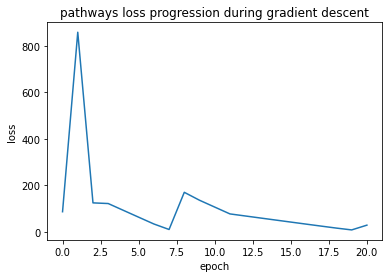

In [362]:
x = np.arange(0,21)
plt.title("pathways loss progression during gradient descent") 
plt.xlabel("epoch") 
plt.ylabel("loss") 
plt.plot(x,loss_progression) 
plt.show()

In [363]:
W

<tf.Variable 'W:0' shape=(113, 113) dtype=float64, numpy=
array([[ 9.88886345e-03, -1.11549626e-04, -1.12885020e-04, ...,
        -1.13049570e-04, -8.56379267e-05, -1.14182812e-04],
       [-1.11034232e-04,  9.88833319e-03, -1.12373151e-04, ...,
        -1.12975756e-04, -8.56374255e-05, -1.13691632e-04],
       [-1.24865044e-04, -1.25028761e-04,  9.86971075e-03, ...,
        -1.28021234e-04, -9.54276372e-05, -1.31556978e-04],
       ...,
       [-1.14083934e-04, -1.14540539e-04, -1.16968445e-04, ...,
         9.88325318e-03, -8.75247539e-05, -1.18384581e-04],
       [-8.77539843e-05, -8.81590581e-05, -8.84708094e-05, ...,
        -8.90074773e-05,  9.93193560e-03, -8.96298678e-05],
       [-1.29580001e-04, -1.29783843e-04, -1.34880725e-04, ...,
        -1.32894473e-04, -9.91815601e-05,  9.86354368e-03]])>

In [364]:
saveVariables("pathwayParameterMatrixTumorBasal.txt",[W])

In [365]:
W = retrieveVariables("pathwayParameterMatrixTumorBasal.txt")[0]
W

<tf.Variable 'W:0' shape=(113, 113) dtype=float64, numpy=
array([[ 9.88886345e-03, -1.11549626e-04, -1.12885020e-04, ...,
        -1.13049570e-04, -8.56379267e-05, -1.14182812e-04],
       [-1.11034232e-04,  9.88833319e-03, -1.12373151e-04, ...,
        -1.12975756e-04, -8.56374255e-05, -1.13691632e-04],
       [-1.24865044e-04, -1.25028761e-04,  9.86971075e-03, ...,
        -1.28021234e-04, -9.54276372e-05, -1.31556978e-04],
       ...,
       [-1.14083934e-04, -1.14540539e-04, -1.16968445e-04, ...,
         9.88325318e-03, -8.75247539e-05, -1.18384581e-04],
       [-8.77539843e-05, -8.81590581e-05, -8.84708094e-05, ...,
        -8.90074773e-05,  9.93193560e-03, -8.96298678e-05],
       [-1.29580001e-04, -1.29783843e-04, -1.34880725e-04, ...,
        -1.32894473e-04, -9.91815601e-05,  9.86354368e-03]])>

In [366]:
loss = tf.Variable(0.0,dtype="float64")
finalVectors_tensors = getPathwayEmbeddingEnhancedFinal(partialsVectors_tensor,W)
loss_opt(tf.transpose(finalVectors_tensors),tensorPathways,precomputed_weight_pathways)

<tf.Tensor: shape=(), dtype=float64, numpy=25.800878932518444>

In [367]:
finalVectors_tensors = getPathwayEmbeddingEnhancedFinal(partialsVectors_tensor,W)
pathways["pathwayEmbeddings"]= finalVectors_tensors.numpy().transpose().tolist()

In [368]:
pathways

pathway_id                                  pathway_name  \
0    path:hsa00190                     Oxidative phosphorylation   
1    path:hsa00072    Synthesis and degradation of ketone bodies   
2    path:hsa01040       Biosynthesis of unsaturated fatty acids   
3    path:hsa04672  Intestinal immune network for IgA production   
4    path:hsa03460                        Fanconi anemia pathway   
..             ...                                           ...   
222  path:hsa03013                                 RNA transport   
223  path:hsa04340                    Hedgehog signaling pathway   
224  path:hsa03018                               RNA degradation   
225  path:hsa00785                        Lipoic acid metabolism   
226  path:hsa03015                     mRNA surveillance pathway   

                                                 nodes  \
0    64077;5464;245972;245973;479;513;514;515;516;5...   
1      64064;38;39;3155;56898;54511;622;3158;3157;5019   
2    641371;79966;6319;570;9415;3992;10965;122970;1...   
3    4055;8174;959;8741;3600;23308;102723407;6370;5...   
4    3280;378708;55120;672;84126;675;2189;83990;229...   
..                                                 ...   
222  8893;8891;8892;9984;8890;1975;340529;8662;8663...   
223  64399;122011;595;1456;1455;1454;1453;1452;6469...   
224  5042;132430;340529;8761;645974;26986;80336;992...   
225                          116285;11019;387787;51601   
226  81608;23049;2107;10898;10978;53981;4686;5976;5...   

                                       partialsVectors  \
0    [0.7126892779092059, 0.7179393977183589, 0.717...   
1    [0.650953870660312, 0.6569001824051605, 0.6546...   
2    [0.6215876466030736, 0.6257104096472648, 0.625...   
3    [0.6979400312004931, 0.7020403203790008, 0.707...   
4    [0.535236075299287, 0.5383842313293526, 0.5405...   
..                                                 ...   
222  [0.5649026681611163, 0.5691281319680503, 0.566...   
223  [0.6148437592886148, 0.6186267996470879, 0.623...   
224  [0.41294695075499244, 0.4172389713247548, 0.41...   
225  [0.23342887053970263, 0.2346571559268081, 0.23...   
226  [0.45243237770554057, 0.45531770487493484, 0.4...   

                                             nodes_set  \
0    [64077, 5464, 245972, 245973, 479, 513, 514, 5...   
1    [64064, 38, 39, 3155, 56898, 54511, 622, 3158,...   
2    [641371, 79966, 6319, 570, 9415, 3992, 10965, ...   
3    [4055, 8174, 959, 8741, 3600, 23308, 102723407...   
4    [3280, 378708, 55120, 672, 84126, 675, 2189, 8...   
..                                                 ...   
222  [8893, 8891, 8892, 9984, 8890, 1975, 340529, 8...   
223  [64399, 122011, 595, 1456, 1455, 1454, 1453, 1...   
224  [5042, 132430, 340529, 8761, 645974, 26986, 80...   
225                     [116285, 11019, 387787, 51601]   
226  [81608, 23049, 2107, 10898, 10978, 53981, 4686...   

                                     pathwayEmbeddings  
0    [-2.3920149037800172e-05, -1.2278089659489417e...  
1    [-2.2602796782243172e-05, -9.662744526915902e-...  
2    [-1.8245512781242332e-05, -9.002058799655259e-...  
3    [-2.4225224080499164e-05, -1.487297611382022e-...  
4    [-1.7854766216185408e-05, -1.0687216468776507e...  
..                                                 ...  
222  [-1.741679402393344e-05, -8.062064077764206e-0...  
223  [-2.190991525850094e-05, -1.3329262465050513e-...  
224  [-1.4991890674624421e-05, -5.752319187839431e-...  
225  [-6.166045514034333e-06, -3.3376870738331923e-...  
226  [-1.4557184195645307e-05, -8.051096980288823e-...  

[226 rows x 6 columns]

In [369]:
pathways["pathway_name"].describe()

count                       226
unique                      226
top       p53 signaling pathway
freq                          1
Name: pathway_name, dtype: object

In [268]:
pathways["pathwayEmbeddings"][29]

[5.464396147767968e-10,
 5.042605384334697e-10,
 5.857122263505764e-10,
 4.779154940170758e-10,
 5.853818532099657e-10,
 6.326952983367936e-10,
 6.175852241753395e-10,
 5.056822000395525e-10,
 5.263720337790984e-10,
 6.15833223186448e-10,
 4.963930102021093e-10,
 5.050732092913508e-10,
 5.061161758745219e-10,
 5.579731317988695e-10,
 6.383094137122417e-10,
 5.400750393500231e-10,
 5.172566556303731e-10,
 5.156405973101628e-10,
 5.045405931589177e-10,
 5.019481482861801e-10,
 6.158019055912719e-10,
 5.389239561721107e-10,
 5.2416809780457e-10,
 5.343449321668797e-10,
 6.222397450934866e-10,
 6.160597910858877e-10,
 5.651125886354494e-10,
 4.4537554329806547e-10,
 4.479633271828546e-10,
 4.959037704339834e-10,
 6.391635005706418e-10,
 6.199412149351923e-10,
 6.171974097233427e-10,
 4.629512342701181e-10,
 4.5299754139034465e-10,
 6.005306861506669e-10,
 4.767190065954643e-10,
 4.830094498890313e-10,
 4.901725830011759e-10,
 4.917955423806249e-10,
 4.560289172611319e-10,
 4.93380509765186

In [370]:
onlyPathwayEmbeddings = pd.DataFrame(np.array(pathways["pathwayEmbeddings"].tolist()))

In [371]:
onlyPathwayEmbeddings["pathway_id"] = pathways["pathway_id"]
onlyPathwayEmbeddings

0         1         2         3         4         5         6  \
0   -0.000024 -0.000012 -0.000205 -0.000217 -0.000049 -0.000249 -0.000143   
1   -0.000023 -0.000010 -0.000189 -0.000193 -0.000046 -0.000223 -0.000134   
2   -0.000018 -0.000009 -0.000177 -0.000186 -0.000044 -0.000213 -0.000128   
3   -0.000024 -0.000015 -0.000191 -0.000204 -0.000049 -0.000237 -0.000154   
4   -0.000018 -0.000011 -0.000150 -0.000160 -0.000037 -0.000183 -0.000112   
..        ...       ...       ...       ...       ...       ...       ...   
221 -0.000017 -0.000008 -0.000164 -0.000171 -0.000039 -0.000195 -0.000113   
222 -0.000022 -0.000013 -0.000169 -0.000180 -0.000042 -0.000209 -0.000135   
223 -0.000015 -0.000006 -0.000119 -0.000127 -0.000029 -0.000146 -0.000082   
224 -0.000006 -0.000003 -0.000069 -0.000072 -0.000016 -0.000081 -0.000046   
225 -0.000015 -0.000008 -0.000126 -0.000135 -0.000031 -0.000156 -0.000097   

            7         8         9  ...       104       105       106  \
0   -0.000062 -0.000032 -0.000041  ... -0.000110 -0.000359 -0.000063   
1   -0.000052 -0.000032 -0.000034  ... -0.000099 -0.000330 -0.000058   
2   -0.000050 -0.000031 -0.000035  ... -0.000092 -0.000315 -0.000051   
3   -0.000059 -0.000035 -0.000039  ... -0.000105 -0.000361 -0.000059   
4   -0.000045 -0.000026 -0.000031  ... -0.000081 -0.000273 -0.000046   
..        ...       ...       ...  ...       ...       ...       ...   
221 -0.000048 -0.000027 -0.000032  ... -0.000085 -0.000285 -0.000049   
222 -0.000052 -0.000031 -0.000035  ... -0.000093 -0.000317 -0.000053   
223 -0.000038 -0.000017 -0.000023  ... -0.000064 -0.000207 -0.000037   
224 -0.000019 -0.000012 -0.000013  ... -0.000035 -0.000118 -0.000020   
225 -0.000039 -0.000022 -0.000026  ... -0.000067 -0.000231 -0.000039   

          107       108       109       110       111       112     pathway_id  
0   -0.000072 -0.000305 -0.000023 -0.000041 -0.000043 -0.000250  path:hsa00190  
1   -0.000070 -0.000280 -0.000018 -0.000036 -0.000038 -0.000227  path:hsa00072  
2   -0.000067 -0.000269 -0.000019 -0.000038 -0.000032 -0.000215  path:hsa01040  
3   -0.000084 -0.000291 -0.000022 -0.000040 -0.000045 -0.000234  path:hsa04672  
4   -0.000059 -0.000227 -0.000017 -0.000031 -0.000033 -0.000184  path:hsa03460  
..        ...       ...       ...       ...       ...       ...            ...  
221 -0.000058 -0.000244 -0.000017 -0.000033 -0.000031 -0.000198  path:hsa00780  
222 -0.000074 -0.000256 -0.000020 -0.000035 -0.000039 -0.000208  path:hsa03013  
223 -0.000038 -0.000180 -0.000013 -0.000024 -0.000026 -0.000144  path:hsa04340  
224 -0.000022 -0.000102 -0.000008 -0.000013 -0.000012 -0.000083  path:hsa03018  
225 -0.000050 -0.000192 -0.000014 -0.000027 -0.000025 -0.000154  path:hsa00785  

[226 rows x 114 columns]

In [372]:
onlyPathwayEmbeddings.to_csv("pathwayEmbeddingsTumorBasal113New.csv")

In [373]:
onlyPathwayEmbeddings.describe()

0             1           2           3           4    \
count  226.000000  2.260000e+02  226.000000  226.000000  226.000000   
mean    -0.000023 -1.262430e-05   -0.000191   -0.000203   -0.000047   
std      0.000006  4.742885e-06    0.000040    0.000043    0.000010   
min     -0.000033 -1.995966e-05   -0.000263   -0.000287   -0.000065   
25%     -0.000027 -1.699066e-05   -0.000218   -0.000234   -0.000055   
50%     -0.000024 -1.332302e-05   -0.000202   -0.000215   -0.000051   
75%     -0.000018 -8.467640e-06   -0.000172   -0.000183   -0.000042   
max     -0.000001 -4.346109e-07   -0.000020   -0.000025   -0.000005   

              5           6           7           8           9    ...  \
count  226.000000  226.000000  226.000000  226.000000  226.000000  ...   
mean    -0.000235   -0.000148   -0.000058   -0.000034   -0.000039  ...   
std      0.000051    0.000037    0.000013    0.000008    0.000009  ...   
min     -0.000336   -0.000205   -0.000094   -0.000047   -0.000058  ...   
25%     -0.000272   -0.000177   -0.000068   -0.000040   -0.000045  ...   
50%     -0.000249   -0.000158   -0.000060   -0.000037   -0.000041  ...   
75%     -0.000210   -0.000124   -0.000052   -0.000029   -0.000035  ...   
max     -0.000030   -0.000018   -0.000007   -0.000002   -0.000004  ...   

              103         104         105         106         107         108  \
count  226.000000  226.000000  226.000000  226.000000  226.000000  226.000000   
mean    -0.000012   -0.000102   -0.000353   -0.000058   -0.000079   -0.000290   
std      0.000004    0.000022    0.000080    0.000013    0.000022    0.000062   
min     -0.000019   -0.000140   -0.000480   -0.000082   -0.000116   -0.000408   
25%     -0.000015   -0.000118   -0.000412   -0.000067   -0.000097   -0.000334   
50%     -0.000013   -0.000108   -0.000376   -0.000063   -0.000083   -0.000308   
75%     -0.000009   -0.000091   -0.000312   -0.000052   -0.000064   -0.000260   
max      0.000010   -0.000012   -0.000039   -0.000007   -0.000006   -0.000034   

              109         110         111         112  
count  226.000000  226.000000  226.000000  226.000000  
mean    -0.000022   -0.000040   -0.000041   -0.000233  
std      0.000005    0.000009    0.000011    0.000049  
min     -0.000031   -0.000055   -0.000058   -0.000325  
25%     -0.000026   -0.000046   -0.000050   -0.000268  
50%     -0.000023   -0.000042   -0.000043   -0.000247  
75%     -0.000018   -0.000035   -0.000035   -0.000210  
max     -0.000003   -0.000004   -0.000005   -0.000026  

[8 rows x 113 columns]

<AxesSubplot:>

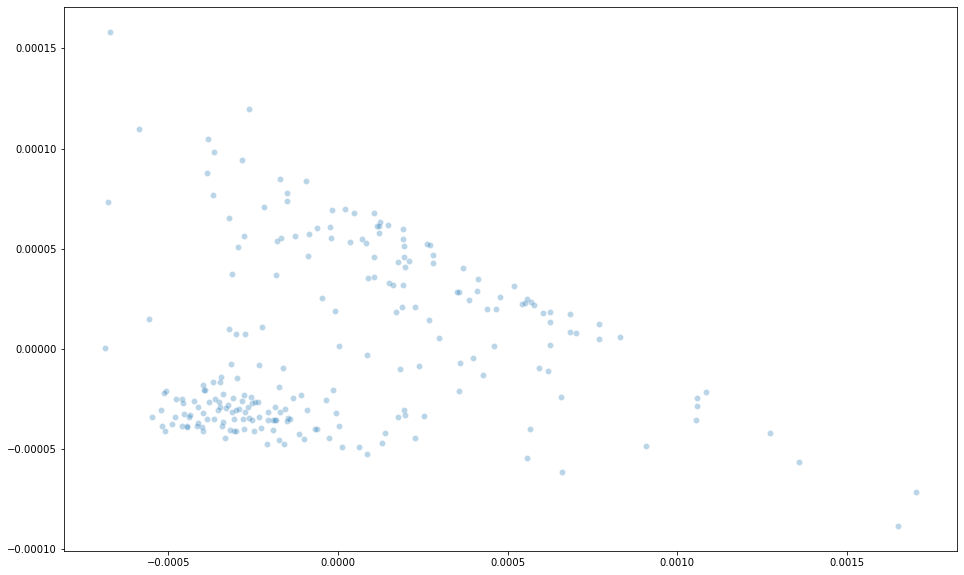

In [374]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(onlyPathwayEmbeddings.drop("pathway_id",axis=1))
firstDim = pca_result[:,0]
secondDim = pca_result[:,1] 
thirdDim = pca_result[:,2]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=firstDim, y=secondDim,
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.3
)

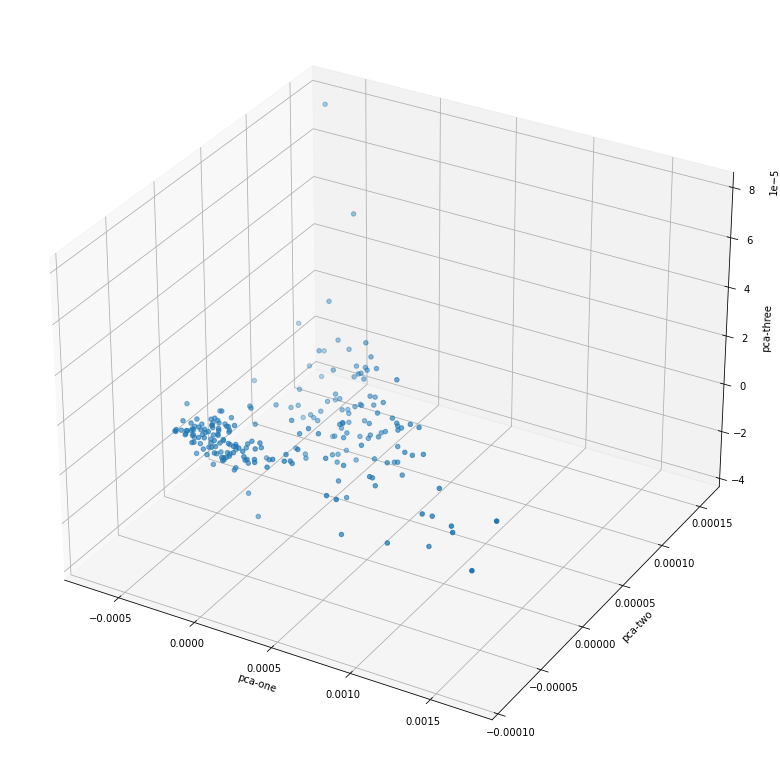

In [375]:
ax = plt.figure(figsize=(16,14)).gca(projection='3d')
ax.scatter(
    xs=firstDim, 
    ys=secondDim, 
    zs=thirdDim, 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

## Pathway embeddings for tumors(lumA with 113 patients)

In [376]:
betweennessListTumors = nx.betweenness_centrality(Gtumors,normalized = True, 
                                              endpoints = False)

In [377]:
tfDatasetGenesExpressionsTumors = tf.data.Dataset.from_tensor_slices((genesEmbeddingsTumorLumA.index,genesEmbeddingsTumorLumA.values))
normalizer_constant = genesEmbeddingsTumorLumA.max().max()
normalizer_constant

0.01082583237439394

In [378]:
#geneWeights = tf.constant(list(map(lambda value: gene_weight(value,betweennessList),list(genesEmbeddings.index))),dtype=tf.float64)

geneWeightsTumor = list(map(lambda value: gene_weight(value,betweennessListTumors),list(genesEmbeddingsTumorLumA.index)))

In [379]:
exprMatrixWeightedTumors = genesEmbeddingsTumorLumA.mul(geneWeightsTumor,axis=0)
exprMatrixWeightedTumors

0         1         2         3         4         5         6    \
2      0.007777  0.008296  0.010094  0.009946  0.009810  0.007835  0.009553   
3      0.007874  0.008274  0.010160  0.009925  0.009824  0.007807  0.009602   
7      0.007804  0.008252  0.010091  0.009956  0.009855  0.007742  0.009620   
8      0.007824  0.008215  0.010088  0.009966  0.009843  0.007775  0.009621   
10     0.007822  0.008201  0.010088  0.009961  0.009843  0.007764  0.009618   
...         ...       ...       ...       ...       ...       ...       ...   
20526  0.007838  0.008162  0.010587  0.010033  0.009856  0.007605  0.009502   
20527  0.007836  0.008210  0.010095  0.009954  0.009835  0.007783  0.009617   
20528  0.007839  0.008212  0.010074  0.009958  0.009831  0.007808  0.009609   
20529  0.007825  0.008249  0.010127  0.009961  0.009849  0.007753  0.009626   
20530  0.007823  0.008240  0.010125  0.009955  0.009855  0.007733  0.009644   

            7         8         9    ...       103       104       105  \
2      0.008431  0.008095  0.008550  ...  0.008466  0.008234  0.009878   
3      0.008594  0.008329  0.008302  ...  0.008350  0.008152  0.009959   
7      0.008464  0.008166  0.008371  ...  0.008491  0.008189  0.009796   
8      0.008511  0.008175  0.008403  ...  0.008425  0.008175  0.009820   
10     0.008508  0.008151  0.008405  ...  0.008436  0.008180  0.009809   
...         ...       ...       ...  ...       ...       ...       ...   
20526  0.008600  0.008129  0.008243  ...  0.008537  0.008085  0.009777   
20527  0.008529  0.008186  0.008393  ...  0.008408  0.008178  0.009843   
20528  0.008522  0.008203  0.008410  ...  0.008400  0.008189  0.009849   
20529  0.008523  0.008193  0.008362  ...  0.008423  0.008158  0.009847   
20530  0.008528  0.008191  0.008344  ...  0.008433  0.008138  0.009827   

            106       107       108       109       110       111       112  
2      0.009468  0.008191  0.009415  0.007572  0.008525  0.010223  0.009825  
3      0.009577  0.008199  0.009360  0.007467  0.008464  0.010236  0.009646  
7      0.009546  0.008178  0.009366  0.007491  0.008508  0.010152  0.009663  
8      0.009540  0.008202  0.009365  0.007558  0.008447  0.010207  0.009686  
10     0.009538  0.008219  0.009373  0.007578  0.008437  0.010205  0.009702  
...         ...       ...       ...       ...       ...       ...       ...  
20526  0.009570  0.008351  0.009394  0.007616  0.008649  0.010194  0.009538  
20527  0.009546  0.008215  0.009366  0.007567  0.008426  0.010220  0.009701  
20528  0.009519  0.008189  0.009365  0.007541  0.008441  0.010211  0.009692  
20529  0.009583  0.008204  0.009371  0.007535  0.008448  0.010210  0.009681  
20530  0.009599  0.008230  0.009359  0.007560  0.008446  0.010212  0.009668  

[19727 rows x 113 columns]

In [380]:
tfExprMatrixWeighted = tf.data.Dataset.from_tensor_slices((exprMatrixWeightedTumors.index,exprMatrixWeightedTumors.values))

In [381]:
def getPartialVec(Nodes):
    listatest =  Nodes.split(";")  
    listatest = list(map(int, listatest))  

    keys_tensor = tf.constant(listatest,dtype=tf.int64)
    vals_tensor = tf.ones_like(keys_tensor)  # Ones will be casted to True.

    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor),
        default_value=0)  # If index not in table, return 0.

    def hash_table_filter(index, value):
        table_value = table.lookup(index)  # 1 if index in arr, else 0.
        index_in_arr =  tf.cast(table_value, tf.bool) # 1 -> True, 0 -> False
        return index_in_arr

    tfFiltered = tfExprMatrixWeighted.filter(hash_table_filter)
    tfFiltered = tfFiltered.map(lambda index,value : value).reduce(np.float64(0.0),lambda x,y: x+y)/ (len(listatest) * normalizer_constant)  #additional normalization by 100 000, otherwise with normalization costant, that is the maximum of all the record genes 
    return tfFiltered.numpy()
    

pathways["partialsVectors"] = pathways["nodes"].map(getPartialVec)

In [383]:
pathways["partialsVectors"].where(pathways["partialsVectors"].map(lambda value: not not value.shape)).dropna()

0      [0.5531699997995552, 0.5823445125297967, 0.713...
1      [0.5058373219407287, 0.5313727826441317, 0.658...
2      [0.4818142577338111, 0.5061163712811244, 0.622...
3      [0.5365675683278505, 0.5715626003532421, 0.700...
4      [0.4120916507289326, 0.43699169124197457, 0.53...
                             ...                        
222    [0.4376070545721643, 0.46119049835968406, 0.56...
223    [0.47287168383150696, 0.5036770480960628, 0.61...
224    [0.322093679001075, 0.3382415205907403, 0.4158...
225    [0.18099499154733822, 0.1894855270695515, 0.23...
226    [0.3482373266693687, 0.36961046734150615, 0.45...
Name: partialsVectors, Length: 226, dtype: object

In [384]:
pathways["partialsVectors"] = pathways["partialsVectors"].where(pathways["partialsVectors"].map(lambda value: not not value.shape))
pathways = pathways.dropna()

Transposing the feature tensor because we need It to be transposed to do the matrix multiplication of the feature(rows)

In [385]:
npPartial = np.stack(pathways["partialsVectors"]).transpose()
partialsVectors_tensor = tf.constant(npPartial)
finalVectors_tensors = getPathwayEmbeddingEnhancedFinal(partialsVectors_tensor,W_tensor)
pathways["pathwayEmbeddings"]= finalVectors_tensors.numpy().transpose().tolist() #tf.make_ndarray(finalVectors_tensors)
#pathways["pathwayEmbeddings"][0]

In [386]:
finalVectors_tensors

<tf.Tensor: shape=(113, 226), dtype=float64, numpy=
array([[0.00055317, 0.00050584, 0.00048181, ..., 0.00032209, 0.00018099,
        0.00034824],
       [0.00058234, 0.00053137, 0.00050612, ..., 0.00033824, 0.00018949,
        0.00036961],
       [0.00071392, 0.00065815, 0.00062233, ..., 0.00041587, 0.00023264,
        0.00045547],
       ...,
       [0.0006034 , 0.00054985, 0.00052315, ..., 0.00035016, 0.00019496,
        0.00038402],
       [0.00072231, 0.00066045, 0.00062997, ..., 0.00041798, 0.00023577,
        0.00046039],
       [0.00068518, 0.00062562, 0.00059776, ..., 0.00039727, 0.00022388,
        0.00043616]])>

In [387]:
pathways["nodes_set"] = list(map(lambda nodes: nodes.split(";") ,pathways["nodes"]))

In [388]:
pathwayPairs = combine(tf.constant(list(pathways.index)),tf.constant(list(pathways.index)))
pathwayPairs.numpy()[0]

array([0, 0], dtype=int32)

In [389]:
indexOfPathways = dict()

for i in range(0,len(pathways.index)):
    indexOfPathways[pathways.index[i]] = i

tensorPathways = tf.map_fn(lambda row: tf.map_fn(lambda element:indexOfPathways[element.numpy()],tf.gather(row, [0, 1]).numpy()) ,pathwayPairs)  # take only edges with no weight

In [390]:
precomputed_weight_pathways = tf.constant(precompute_pathways_weight(pathways,pathwayPairs.numpy()),dtype=tf.float64)

In [391]:
loss = tf.Variable(0.0,dtype="float64")

#firstLoss = getLoss(tf.transpose(finalVectors_tensors),loss).numpy()
firstLoss = loss_opt(tf.transpose(finalVectors_tensors),tensorPathways,precomputed_weight_pathways).numpy()

In [392]:
firstLoss

84.26541583877602

In [164]:
W_numpy = np.diag(np.full(len(pathways["partialsVectors"][0]),0.01))
W = tf.Variable(W_numpy,dtype=tf.float64,name = "W")
npPartial = np.stack(pathways["partialsVectors"]).transpose()
partialsVectors_tensor = tf.constant(npPartial)  #tf.make_tensor_proto(npPartial)
loss = tf.Variable(0.0,dtype="float64")

In [110]:
with tf.GradientTape(persistent=True) as tape:
    loss.assign(0.0)
    tape.watch(W)
    finalVectors_tensors = getPathwayEmbeddingEnhancedFinal(partialsVectors_tensor,W)
    loss = loss_opt(tf.transpose(finalVectors_tensors),tensorPathways,precomputed_weight_pathways)
    #loss =  getLoss(tf.transpose(finalVectors_tensors),loss)
tape.gradient(loss, W)


<tf.Tensor: shape=(113, 113), dtype=float64, numpy=
array([[ 5.99528578,  6.40852064,  7.84520513, ...,  6.60222807,
         8.014497  ,  7.63115525],
       [ 6.40852064,  6.85026798,  8.38598411, ...,  7.05733401,
         8.56694712,  8.1571807 ],
       [ 7.84520513,  8.38598411, 10.26599007, ...,  8.63947101,
        10.48752138,  9.98589308],
       ...,
       [ 6.60222807,  7.05733401,  8.63947101, ...,  7.27066759,
         8.82590618,  8.40375572],
       [ 8.014497  ,  8.56694712, 10.48752138, ...,  8.82590618,
        10.71383963, 10.20138703],
       [ 7.63115525,  8.1571807 ,  9.98589308, ...,  8.40375572,
        10.20138703,  9.71345493]])>

In [166]:
learning_rate = 0.00000004
loss_progression = np.array([5000])
loss = tf.Variable(0.0,dtype="float64")

In [169]:
for i in range(0,10):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(W)
        finalVectors_tensors = getPathwayEmbeddingEnhancedFinal(partialsVectors_tensor,W)
        loss = loss_opt(tf.transpose(finalVectors_tensors),tensorPathways,precomputed_weight_pathways)
        #loss =  getLoss(tf.transpose(finalVectors_tensors),loss)
    dl_dw = tape.gradient(loss, W)
    W.assign_sub(learning_rate * dl_dw)
    finalVectors_tensors = getPathwayEmbeddingEnhancedFinal(partialsVectors_tensor,W)
    loss_progression = np.append(loss_progression,loss.numpy())
    #loss_progression = np.append(loss_progression,getLoss(tf.transpose(finalVectors_tensors),loss).numpy())
    print(loss)

tf.Tensor(494.6495383654993, shape=(), dtype=float64)
tf.Tensor(452.1125784184513, shape=(), dtype=float64)
tf.Tensor(409.5766856838575, shape=(), dtype=float64)
tf.Tensor(367.0421915600972, shape=(), dtype=float64)
tf.Tensor(324.50958372573336, shape=(), dtype=float64)
tf.Tensor(281.9796123318756, shape=(), dtype=float64)
tf.Tensor(239.45349791025097, shape=(), dtype=float64)
tf.Tensor(196.9333782737981, shape=(), dtype=float64)
tf.Tensor(154.42339839205215, shape=(), dtype=float64)
tf.Tensor(111.93290045760229, shape=(), dtype=float64)


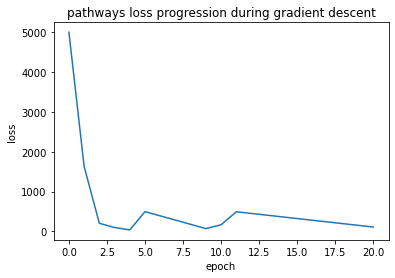

In [170]:
x = np.arange(0,21)
plt.title("pathways loss progression during gradient descent") 
plt.xlabel("epoch") 
plt.ylabel("loss") 
plt.plot(x,loss_progression) 
plt.show()

In [171]:
saveVariables("pathwayParameterMatrixTumorLumANew.txt",[W])

In [228]:
W = retrieveVariables("pathwayParameterMatrixTumorLumANew.txt")[0]

In [229]:
W

<tf.Variable 'W:0' shape=(113, 113) dtype=float64, numpy=
array([[ 9.91898810e-03, -8.54373153e-05, -1.04832893e-04, ...,
        -8.82171490e-05, -1.06056262e-04, -1.00791515e-04],
       [-8.53850113e-05,  9.90750782e-03, -1.12662672e-04, ...,
        -9.47765895e-05, -1.16177945e-04, -1.10975773e-04],
       [-1.04685057e-04, -1.12572145e-04,  9.86110190e-03, ...,
        -1.16449617e-04, -1.41263394e-04, -1.34007422e-04],
       ...,
       [-8.81283508e-05, -9.47386574e-05, -1.16496219e-04, ...,
         9.90137872e-03, -1.18220833e-04, -1.12127830e-04],
       [-1.10074474e-04, -1.19908399e-04, -1.46028084e-04, ...,
        -1.22478398e-04,  9.84793841e-03, -1.45187317e-04],
       [-1.14610083e-04, -1.23429983e-04, -1.50383547e-04, ...,
        -1.26423695e-04, -1.55074480e-04,  9.85186281e-03]])>

In [174]:
loss = tf.Variable(0.0,dtype="float64")
finalVectors_tensors = getPathwayEmbeddingEnhancedFinal(partialsVectors_tensor,W)
loss_opt(tf.transpose(finalVectors_tensors),tensorPathways,precomputed_weight_pathways)

<tf.Tensor: shape=(), dtype=float64, numpy=69.48897893518205>

In [175]:
finalVectors_tensors = getPathwayEmbeddingEnhancedFinal(partialsVectors_tensor,W)
pathways["pathwayEmbeddings"]= finalVectors_tensors.numpy().transpose().tolist()

In [176]:
pathways

pathway_id                                  pathway_name  \
0    path:hsa00190                     Oxidative phosphorylation   
1    path:hsa00072    Synthesis and degradation of ketone bodies   
2    path:hsa01040       Biosynthesis of unsaturated fatty acids   
3    path:hsa04672  Intestinal immune network for IgA production   
4    path:hsa03460                        Fanconi anemia pathway   
..             ...                                           ...   
222  path:hsa03013                                 RNA transport   
223  path:hsa04340                    Hedgehog signaling pathway   
224  path:hsa03018                               RNA degradation   
225  path:hsa00785                        Lipoic acid metabolism   
226  path:hsa03015                     mRNA surveillance pathway   

                                                 nodes  \
0    64077;5464;245972;245973;479;513;514;515;516;5...   
1      64064;38;39;3155;56898;54511;622;3158;3157;5019   
2    641371;79966;6319;570;9415;3992;10965;122970;1...   
3    4055;8174;959;8741;3600;23308;102723407;6370;5...   
4    3280;378708;55120;672;84126;675;2189;83990;229...   
..                                                 ...   
222  8893;8891;8892;9984;8890;1975;340529;8662;8663...   
223  64399;122011;595;1456;1455;1454;1453;1452;6469...   
224  5042;132430;340529;8761;645974;26986;80336;992...   
225                          116285;11019;387787;51601   
226  81608;23049;2107;10898;10978;53981;4686;5976;5...   

                                       partialsVectors  \
0    [0.5531699997995552, 0.5823445125297967, 0.713...   
1    [0.5058373219407287, 0.5313727826441317, 0.658...   
2    [0.4818142577338111, 0.5061163712811244, 0.622...   
3    [0.5578109827644221, 0.5942695465089549, 0.727...   
4    [0.41866849761708474, 0.4440636257218232, 0.54...   
..                                                 ...   
222  [0.4387612379189059, 0.4624193873025828, 0.568...   
223  [0.5640321131321339, 0.6010624928224981, 0.736...   
224  [0.322093679001075, 0.3382415205907403, 0.4158...   
225  [0.18099499154733822, 0.1894855270695515, 0.23...   
226  [0.35719866333553413, 0.3791908531615815, 0.46...   

                                     pathwayEmbeddings  \
0    [0.0005531699997995552, 0.0005823445125297966,...   
1    [0.0005058373219407287, 0.0005313727826441317,...   
2    [0.0004818142577338111, 0.0005061163712811245,...   
3    [0.0005578109827644221, 0.000594269546508955, ...   
4    [0.00041866849761708477, 0.0004440636257218231...   
..                                                 ...   
222  [0.00043876123791890595, 0.0004624193873025828...   
223  [0.0005640321131321339, 0.0006010624928224982,...   
224  [0.000322093679001075, 0.0003382415205907403, ...   
225  [0.00018099499154733824, 0.0001894855270695515...   
226  [0.00035719866333553416, 0.0003791908531615815...   

                                             nodes_set  
0    [64077, 5464, 245972, 245973, 479, 513, 514, 5...  
1    [64064, 38, 39, 3155, 56898, 54511, 622, 3158,...  
2    [641371, 79966, 6319, 570, 9415, 3992, 10965, ...  
3    [4055, 8174, 959, 8741, 3600, 23308, 102723407...  
4    [3280, 378708, 55120, 672, 84126, 675, 2189, 8...  
..                                                 ...  
222  [8893, 8891, 8892, 9984, 8890, 1975, 340529, 8...  
223  [64399, 122011, 595, 1456, 1455, 1454, 1453, 1...  
224  [5042, 132430, 340529, 8761, 645974, 26986, 80...  
225                     [116285, 11019, 387787, 51601]  
226  [81608, 23049, 2107, 10898, 10978, 53981, 4686...  

[227 rows x 6 columns]

In [121]:
pathways["pathway_name"].describe()

count                                   227
unique                                  227
top       Phospholipase D signaling pathway
freq                                      1
Name: pathway_name, dtype: object

In [197]:
pathways["pathwayEmbeddings"][29]

[4.0548049474417435e-10,
 4.275046769015091e-10,
 5.271047530017036e-10,
 5.185754458240342e-10,
 5.121995651036476e-10,
 4.018500004817557e-10,
 5.014247010684395e-10,
 4.430811128625415e-10,
 4.2447486370830246e-10,
 4.3572119236427544e-10,
 3.876763177459271e-10,
 4.2185218246944364e-10,
 4.1581812784746647e-10,
 4.383137584953531e-10,
 4.662485292471733e-10,
 4.382418284985851e-10,
 4.85262754503577e-10,
 4.3555208321056446e-10,
 4.711353332188016e-10,
 5.248288659668763e-10,
 5.285867324567158e-10,
 5.121924893168524e-10,
 4.1266851018513265e-10,
 4.586185459683974e-10,
 4.924161921444743e-10,
 5.107586262873953e-10,
 4.4891510982868507e-10,
 5.006749149980785e-10,
 5.09002099852643e-10,
 5.389810471286972e-10,
 4.181460133124583e-10,
 4.5906124504254033e-10,
 5.312115428836984e-10,
 4.393205096132199e-10,
 5.265704235639099e-10,
 5.230246693757968e-10,
 4.454191926221868e-10,
 4.5071744606852505e-10,
 5.27699565361731e-10,
 4.0895182412923305e-10,
 4.58360080811077e-10,
 4.513447

In [177]:
onlyPathwayEmbeddings = pd.DataFrame(np.array(pathways["pathwayEmbeddings"].tolist()))

In [178]:
onlyPathwayEmbeddings["pathway_id"] = pathways["pathway_id"]
onlyPathwayEmbeddings

0         1         2         3         4         5         6  \
0    0.000553  0.000582  0.000714  0.000706  0.000696  0.000549  0.000683   
1    0.000506  0.000531  0.000658  0.000646  0.000636  0.000500  0.000620   
2    0.000482  0.000506  0.000622  0.000614  0.000606  0.000477  0.000593   
3    0.000558  0.000594  0.000728  0.000721  0.000704  0.000558  0.000693   
4    0.000419  0.000444  0.000546  0.000540  0.000530  0.000419  0.000520   
..        ...       ...       ...       ...       ...       ...       ...   
222  0.000439  0.000462  0.000568  0.000560  0.000552  0.000435  0.000541   
223  0.000564  0.000601  0.000736  0.000729  0.000712  0.000564  0.000701   
224  0.000322  0.000338  0.000416  0.000408  0.000405  0.000317  0.000396   
225  0.000181  0.000189  0.000233  0.000230  0.000227  0.000180  0.000222   
226  0.000357  0.000379  0.000467  0.000461  0.000452  0.000355  0.000443   

            7         8         9  ...       104       105       106  \
0    0.000602  0.000578  0.000595  ...  0.000578  0.000696  0.000674   
1    0.000552  0.000526  0.000541  ...  0.000528  0.000636  0.000617   
2    0.000526  0.000500  0.000517  ...  0.000503  0.000607  0.000587   
3    0.000616  0.000582  0.000607  ...  0.000591  0.000715  0.000688   
4    0.000461  0.000439  0.000454  ...  0.000441  0.000532  0.000516   
..        ...       ...       ...  ...       ...       ...       ...   
222  0.000477  0.000458  0.000471  ...  0.000459  0.000552  0.000535   
223  0.000622  0.000589  0.000615  ...  0.000598  0.000722  0.000695   
224  0.000349  0.000335  0.000343  ...  0.000335  0.000404  0.000393   
225  0.000197  0.000189  0.000194  ...  0.000189  0.000227  0.000220   
226  0.000392  0.000373  0.000387  ...  0.000377  0.000454  0.000439   

          107       108       109       110       111       112     pathway_id  
0    0.000579  0.000662  0.000536  0.000603  0.000722  0.000685  path:hsa00190  
1    0.000531  0.000606  0.000489  0.000550  0.000660  0.000626  path:hsa00072  
2    0.000506  0.000577  0.000467  0.000523  0.000630  0.000598  path:hsa01040  
3    0.000587  0.000674  0.000550  0.000612  0.000743  0.000707  path:hsa04672  
4    0.000441  0.000505  0.000410  0.000460  0.000554  0.000525  path:hsa03460  
..        ...       ...       ...       ...       ...       ...            ...  
222  0.000460  0.000526  0.000423  0.000479  0.000572  0.000544  path:hsa03013  
223  0.000594  0.000682  0.000557  0.000620  0.000751  0.000714  path:hsa04340  
224  0.000337  0.000385  0.000309  0.000350  0.000418  0.000397  path:hsa03018  
225  0.000189  0.000216  0.000174  0.000195  0.000236  0.000224  path:hsa00785  
226  0.000377  0.000430  0.000350  0.000394  0.000472  0.000448  path:hsa03015  

[227 rows x 114 columns]

In [180]:
onlyPathwayEmbeddings.to_csv("pathwayEmbeddingsTumorLumA113New.csv")

In [181]:
onlyPathwayEmbeddings.describe()

0           1           2           3           4           5    \
count  227.000000  227.000000  227.000000  227.000000  227.000000  227.000000   
mean     0.000630    0.000669    0.000821    0.000812    0.000795    0.000629   
std      0.000206    0.000222    0.000271    0.000269    0.000261    0.000208   
min      0.000060    0.000064    0.000078    0.000076    0.000076    0.000060   
25%      0.000482    0.000508    0.000626    0.000615    0.000607    0.000479   
50%      0.000618    0.000656    0.000804    0.000795    0.000780    0.000616   
75%      0.000792    0.000846    0.001036    0.001027    0.001002    0.000794   
max      0.001073    0.001146    0.001403    0.001391    0.001356    0.001075   

              6           7           8           9    ...         103  \
count  227.000000  227.000000  227.000000  227.000000  ...  227.000000   
mean     0.000781    0.000693    0.000657    0.000682  ...    0.000685   
std      0.000257    0.000230    0.000215    0.000226  ...    0.000225   
min      0.000074    0.000065    0.000063    0.000064  ...    0.000065   
25%      0.000596    0.000527    0.000505    0.000518  ...    0.000525   
50%      0.000765    0.000680    0.000642    0.000667  ...    0.000671   
75%      0.000986    0.000876    0.000827    0.000863  ...    0.000864   
max      0.001335    0.001187    0.001120    0.001169  ...    0.001170   

              104         105         106         107         108         109  \
count  227.000000  227.000000  227.000000  227.000000  227.000000  227.000000   
mean     0.000665    0.000803    0.000775    0.000663    0.000760    0.000618   
std      0.000220    0.000268    0.000256    0.000218    0.000251    0.000207   
min      0.000063    0.000076    0.000074    0.000063    0.000072    0.000058   
25%      0.000504    0.000607    0.000589    0.000506    0.000577    0.000467   
50%      0.000654    0.000786    0.000759    0.000652    0.000746    0.000601   
75%      0.000841    0.001017    0.000978    0.000835    0.000959    0.000784   
max      0.001139    0.001378    0.001325    0.001132    0.001299    0.001062   

              110         111         112  
count  227.000000  227.000000  227.000000  
mean     0.000691    0.000834    0.000793  
std      0.000228    0.000279    0.000266  
min      0.000065    0.000078    0.000074  
25%      0.000530    0.000630    0.000598  
50%      0.000675    0.000813    0.000774  
75%      0.000872    0.001058    0.001007  
max      0.001180    0.001433    0.001364  

[8 rows x 113 columns]

<AxesSubplot:>

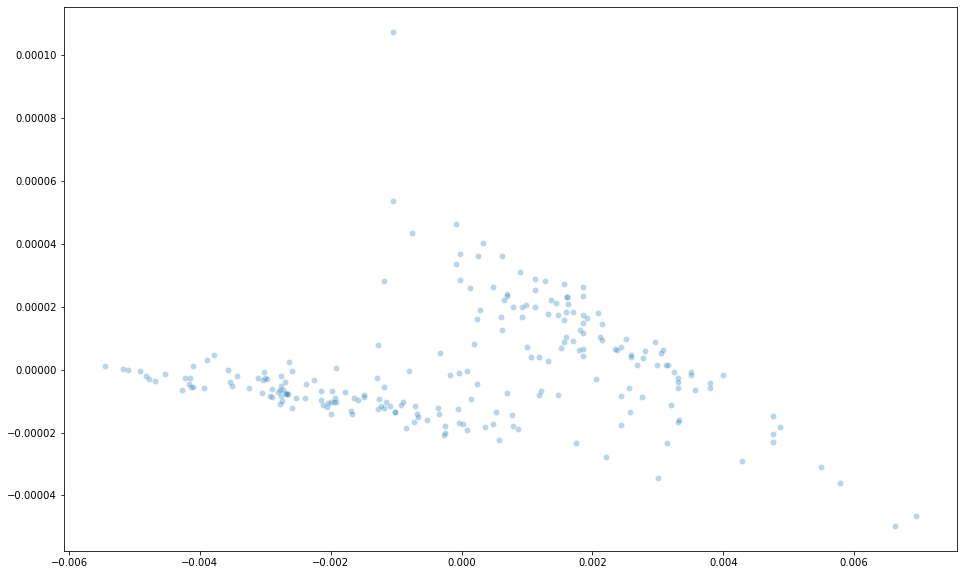

In [182]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(onlyPathwayEmbeddings.drop("pathway_id",axis=1))
firstDim = pca_result[:,0]
secondDim = pca_result[:,1] 
thirdDim = pca_result[:,2]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=firstDim, y=secondDim,
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.3
)

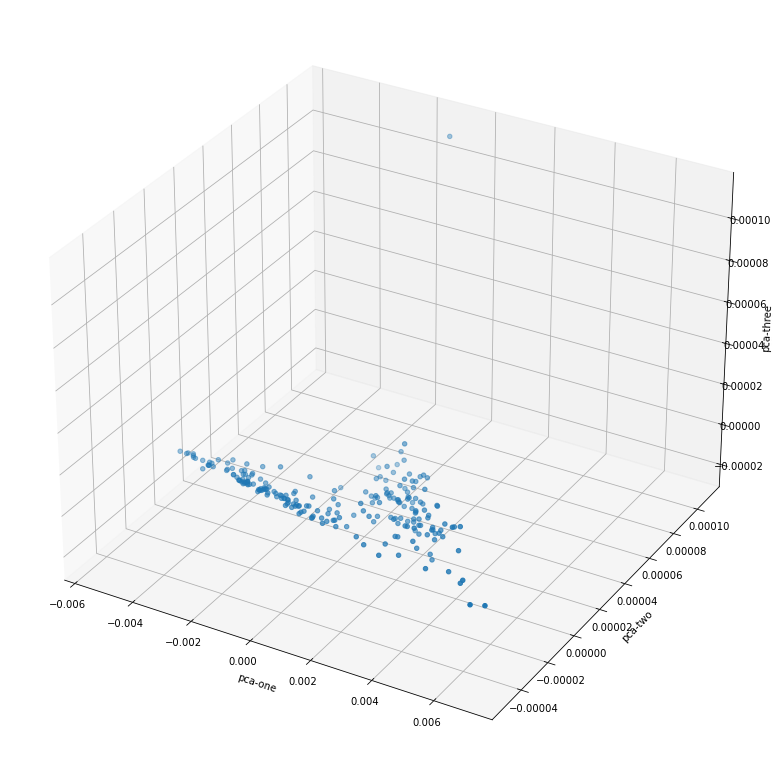

In [183]:
ax = plt.figure(figsize=(16,14)).gca(projection='3d')
ax.scatter(
    xs=firstDim, 
    ys=secondDim, 
    zs=thirdDim, 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

## LumA 4 pathway embeddings of 113 different patients each

In [225]:
genesEmbeddingsTumorLumA1

0         1         2         3         4         5         6    \
2      0.007692  0.008256  0.010092  0.009976  0.009716  0.007767  0.009646   
3      0.007839  0.008361  0.010051  0.009883  0.009848  0.007762  0.009633   
7      0.007830  0.008229  0.010027  0.009951  0.009830  0.007801  0.009620   
8      0.007830  0.008212  0.010093  0.009961  0.009840  0.007782  0.009618   
10     0.007820  0.008234  0.010080  0.009947  0.009837  0.007762  0.009610   
...         ...       ...       ...       ...       ...       ...       ...   
20526  0.007783  0.008153  0.010163  0.010051  0.009883  0.007727  0.009750   
20527  0.007837  0.008215  0.010084  0.009958  0.009843  0.007772  0.009640   
20528  0.007819  0.008216  0.010088  0.009963  0.009841  0.007780  0.009605   
20529  0.007823  0.008214  0.010140  0.009976  0.009843  0.007768  0.009601   
20530  0.007817  0.008216  0.010136  0.009982  0.009855  0.007727  0.009653   

            7         8         9    ...       103       104       105  \
2      0.008528  0.008130  0.008485  ...  0.008405  0.008206  0.009926   
3      0.008368  0.008236  0.008294  ...  0.008620  0.008250  0.009842   
7      0.008469  0.008173  0.008422  ...  0.008466  0.008221  0.009811   
8      0.008508  0.008180  0.008403  ...  0.008432  0.008184  0.009823   
10     0.008470  0.008139  0.008392  ...  0.008482  0.008219  0.009811   
...         ...       ...       ...  ...       ...       ...       ...   
20526  0.008541  0.008161  0.008495  ...  0.008485  0.008114  0.009720   
20527  0.008520  0.008181  0.008398  ...  0.008429  0.008166  0.009827   
20528  0.008491  0.008167  0.008409  ...  0.008444  0.008198  0.009817   
20529  0.008525  0.008173  0.008396  ...  0.008415  0.008174  0.009834   
20530  0.008518  0.008138  0.008406  ...  0.008471  0.008158  0.009799   

            106       107       108       109       110       111       112  
2      0.009557  0.008108  0.009348  0.007696  0.008552  0.010283  0.009819  
3      0.009482  0.008069  0.009369  0.007233  0.008758  0.009981  0.009615  
7      0.009484  0.008151  0.009353  0.007501  0.008503  0.010153  0.009684  
8      0.009528  0.008203  0.009364  0.007546  0.008465  0.010204  0.009688  
10     0.009532  0.008176  0.009370  0.007523  0.008471  0.010159  0.009709  
...         ...       ...       ...       ...       ...       ...       ...  
20526  0.009530  0.008232  0.009255  0.007632  0.008685  0.010265  0.009519  
20527  0.009533  0.008219  0.009364  0.007559  0.008472  0.010211  0.009689  
20528  0.009520  0.008191  0.009373  0.007529  0.008466  0.010186  0.009691  
20529  0.009554  0.008212  0.009376  0.007564  0.008436  0.010224  0.009691  
20530  0.009533  0.008239  0.009361  0.007573  0.008526  0.010209  0.009670  

[19727 rows x 113 columns]

In [393]:
geneWeightsTumor = list(map(lambda value: gene_weight(value,betweennessListTumors),list(genesEmbeddingsTumorLumA.index)))
exprMatrixWeightedTumors1 = genesEmbeddingsTumorLumA1.mul(geneWeightsTumor,axis=0)
exprMatrixWeightedTumors2 = genesEmbeddingsTumorLumA2.mul(geneWeightsTumor,axis=0)
exprMatrixWeightedTumors3 = genesEmbeddingsTumorLumA3.mul(geneWeightsTumor,axis=0)
exprMatrixWeightedTumors4 = genesEmbeddingsTumorLumA4.mul(geneWeightsTumor,axis=0)
tfExprMatrixWeighted1 = tf.data.Dataset.from_tensor_slices((exprMatrixWeightedTumors1.index,exprMatrixWeightedTumors1.values))
tfExprMatrixWeighted2 = tf.data.Dataset.from_tensor_slices((exprMatrixWeightedTumors2.index,exprMatrixWeightedTumors2.values))
tfExprMatrixWeighted3 = tf.data.Dataset.from_tensor_slices((exprMatrixWeightedTumors3.index,exprMatrixWeightedTumors3.values))
tfExprMatrixWeighted4 = tf.data.Dataset.from_tensor_slices((exprMatrixWeightedTumors4.index,exprMatrixWeightedTumors4.values))


### 1- 113 PATIENTS LumA

In [411]:
def getPartialVec(Nodes):
    listatest =  Nodes.split(";")  
    listatest = list(map(int, listatest))  

    keys_tensor = tf.constant(listatest,dtype=tf.int64)
    vals_tensor = tf.ones_like(keys_tensor)  # Ones will be casted to True.

    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor),
        default_value=0)  # If index not in table, return 0.

    def hash_table_filter(index, value):
        table_value = table.lookup(index)  # 1 if index in arr, else 0.
        index_in_arr =  tf.cast(table_value, tf.bool) # 1 -> True, 0 -> False
        return index_in_arr

    tfFiltered = tfExprMatrixWeighted1.filter(hash_table_filter)
    tfFiltered = tfFiltered.map(lambda index,value : value).reduce(np.float64(0.0),lambda x,y: x+y)/ (len(listatest) * normalizer_constant)  #additional normalization by 100 000, otherwise with normalization costant, that is the maximum of all the record genes 
    return tfFiltered.numpy()
    

pathways["partialsVectors"] = pathways["nodes"].map(getPartialVec)
pathways["partialsVectors"] = pathways["partialsVectors"].where(pathways["partialsVectors"].map(lambda value: not not value.shape))
pathways = pathways.dropna()
W = np.diag(np.full(len(pathways["partialsVectors"][0]),0.001))
W_tensor = tf.Variable(W,dtype=tf.float64)
pathways["pathwayEmbeddings"] = pathways["partialsVectors"].map(lambda value: getPathwayEmbedding(value,W_tensor))
pathways["pathwayEmbeddings"]

npPartial = np.stack(pathways["partialsVectors"]).transpose()
partialsVectors_tensor = tf.constant(npPartial)
finalVectors_tensors = getPathwayEmbeddingEnhancedFinal(partialsVectors_tensor,W_tensor)
pathways["pathwayEmbeddings"]= finalVectors_tensors.numpy().transpose().tolist() #tf.make_ndarray(finalVectors_tensors)
#pathways["pathwayEmbeddings"][0]
pathways["nodes_set"] = list(map(lambda nodes: nodes.split(";") ,pathways["nodes"]))
pathwayPairs = combine(tf.constant(list(pathways.index)),tf.constant(list(pathways.index)))

In [412]:
indexOfPathways = dict()

for i in range(0,len(pathways.index)):
    indexOfPathways[pathways.index[i]] = i

tensorPathways = tf.map_fn(lambda row: tf.map_fn(lambda element:indexOfPathways[element.numpy()],tf.gather(row, [0, 1]).numpy()) ,pathwayPairs)
precomputed_weight_pathways = tf.constant(precompute_pathways_weight(pathways,pathwayPairs.numpy()),dtype=tf.float64)
W_numpy = np.diag(np.full(len(pathways["partialsVectors"][0]),0.01))
W = tf.Variable(W_numpy,dtype=tf.float64,name = "W")
npPartial = np.stack(pathways["partialsVectors"]).transpose()
partialsVectors_tensor = tf.constant(npPartial)  #tf.make_tensor_proto(npPartial)
loss = tf.Variable(0.0,dtype="float64")

In [396]:
loss_progression = np.array([5000])
loss = tf.Variable(0.0,dtype="float64")

tf.Tensor(30.854727508349892, shape=(), dtype=float64)
tf.Tensor(29.739392676306696, shape=(), dtype=float64)
tf.Tensor(28.625385772783584, shape=(), dtype=float64)
tf.Tensor(27.512699027415426, shape=(), dtype=float64)
tf.Tensor(26.401466620930137, shape=(), dtype=float64)
tf.Tensor(25.291893743764884, shape=(), dtype=float64)
tf.Tensor(24.18419060865297, shape=(), dtype=float64)
tf.Tensor(23.07851630849523, shape=(), dtype=float64)
tf.Tensor(21.9751072403062, shape=(), dtype=float64)
tf.Tensor(20.874283112710287, shape=(), dtype=float64)
tf.Tensor(19.77744099532464, shape=(), dtype=float64)
tf.Tensor(18.684257124985837, shape=(), dtype=float64)
tf.Tensor(17.59536426520326, shape=(), dtype=float64)
tf.Tensor(16.5112244809068, shape=(), dtype=float64)
tf.Tensor(15.43246998784776, shape=(), dtype=float64)
tf.Tensor(14.360277511788183, shape=(), dtype=float64)
tf.Tensor(13.295695728510287, shape=(), dtype=float64)
tf.Tensor(12.240589750049029, shape=(), dtype=float64)
tf.Tensor(11.196916

ValueError: x and y must have same first dimension, but have shapes (21,) and (27,)

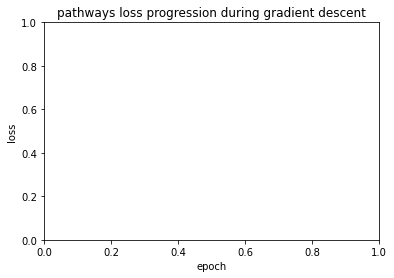

In [398]:
learning_rate = 0.000000004
for i in range(0,20):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(W)
        finalVectors_tensors = getPathwayEmbeddingEnhancedFinal(partialsVectors_tensor,W)
        loss = loss_opt(tf.transpose(finalVectors_tensors),tensorPathways,precomputed_weight_pathways)
        #loss =  getLoss(tf.transpose(finalVectors_tensors),loss)
    dl_dw = tape.gradient(loss, W)
    W.assign_sub(learning_rate * dl_dw)
    loss_progression = np.append(loss_progression,loss.numpy())
    #loss_progression = np.append(loss_progression,getLoss(tf.transpose(finalVectors_tensors),loss).numpy())
    print(loss)

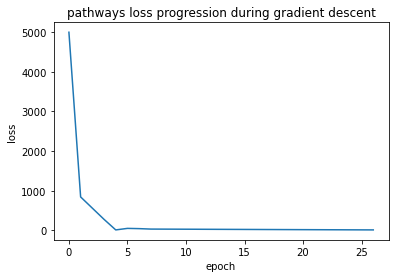

In [399]:
x = np.arange(0,27)
plt.title("pathways loss progression during gradient descent") 
plt.xlabel("epoch") 
plt.ylabel("loss") 
plt.plot(x,loss_progression) 
plt.show()

In [400]:
W = retrieveVariables("pathwayParameterMatrixTumorLumANew.txt")[0]

In [413]:
finalVectors_tensors = getPathwayEmbeddingEnhancedFinal(partialsVectors_tensor,W)
pathways["pathwayEmbeddings"]= finalVectors_tensors.numpy().transpose().tolist()
onlyPathwayEmbeddings = pd.DataFrame(np.array(pathways["pathwayEmbeddings"].tolist()))
onlyPathwayEmbeddings["pathway_id"] = pathways["pathway_id"]
onlyPathwayEmbeddings.to_csv("pathwayEmbeddingsTumorLumA113-1.csv")

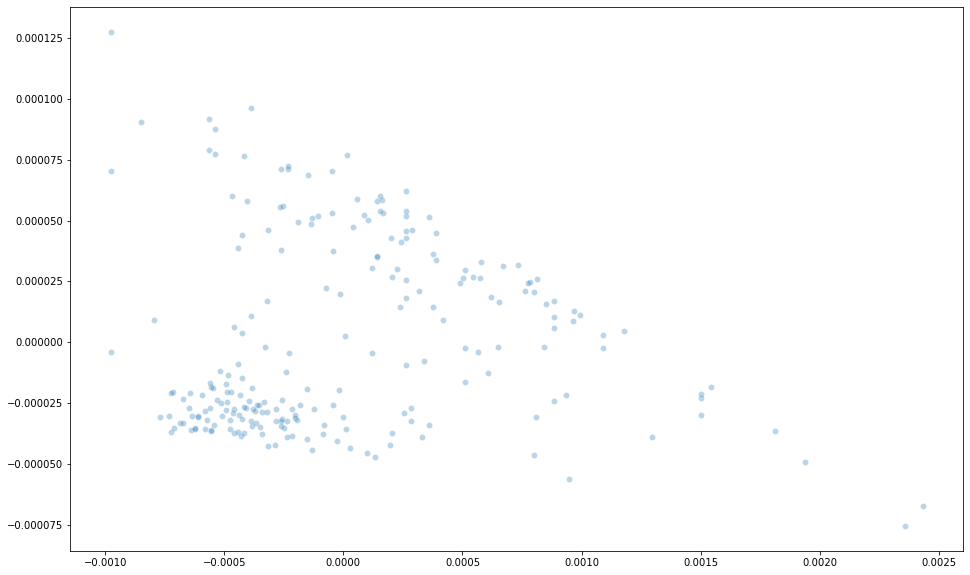

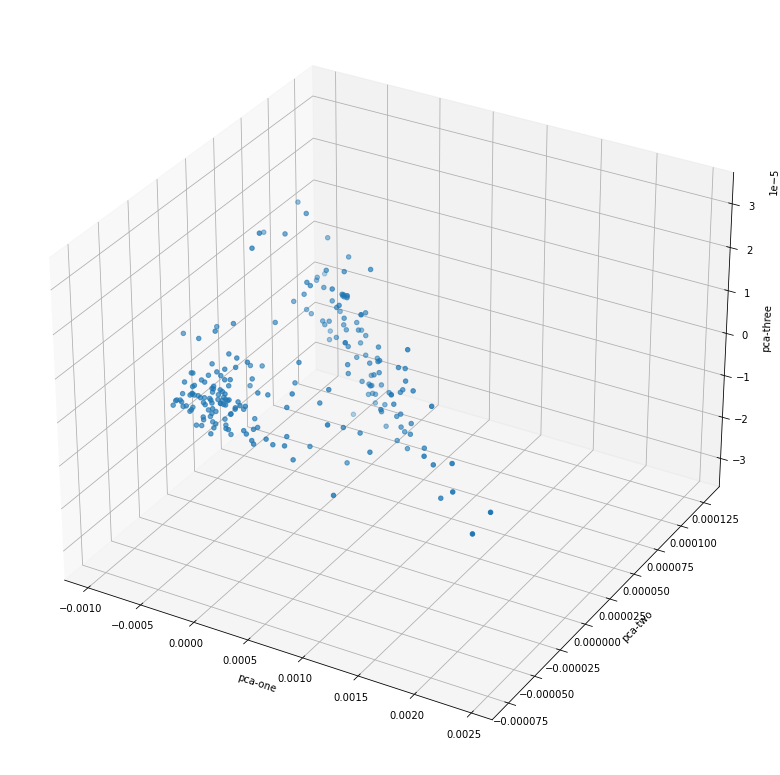

In [402]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(onlyPathwayEmbeddings.drop("pathway_id",axis=1))
firstDim = pca_result[:,0]
secondDim = pca_result[:,1] 
thirdDim = pca_result[:,2]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=firstDim, y=secondDim,
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.3
)
ax = plt.figure(figsize=(16,14)).gca(projection='3d')
ax.scatter(
    xs=firstDim, 
    ys=secondDim, 
    zs=thirdDim, 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

### 113- 226 PATIENTS LumA

In [404]:
def getPartialVec(Nodes):
    listatest =  Nodes.split(";")  
    listatest = list(map(int, listatest))  

    keys_tensor = tf.constant(listatest,dtype=tf.int64)
    vals_tensor = tf.ones_like(keys_tensor)  # Ones will be casted to True.

    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor),
        default_value=0)  # If index not in table, return 0.

    def hash_table_filter(index, value):
        table_value = table.lookup(index)  # 1 if index in arr, else 0.
        index_in_arr =  tf.cast(table_value, tf.bool) # 1 -> True, 0 -> False
        return index_in_arr

    tfFiltered = tfExprMatrixWeighted2.filter(hash_table_filter)
    tfFiltered = tfFiltered.map(lambda index,value : value).reduce(np.float64(0.0),lambda x,y: x+y)/ (len(listatest) * normalizer_constant)  #additional normalization by 100 000, otherwise with normalization costant, that is the maximum of all the record genes 
    return tfFiltered.numpy()
    

pathways["partialsVectors"] = pathways["nodes"].map(getPartialVec)
pathways["partialsVectors"] = pathways["partialsVectors"].where(pathways["partialsVectors"].map(lambda value: not not value.shape))
pathways = pathways.dropna()
W = np.diag(np.full(len(pathways["partialsVectors"][0]),0.001))
W_tensor = tf.Variable(W,dtype=tf.float64)
pathways["pathwayEmbeddings"] = pathways["partialsVectors"].map(lambda value: getPathwayEmbedding(value,W_tensor))

npPartial = np.stack(pathways["partialsVectors"]).transpose()
partialsVectors_tensor = tf.constant(npPartial)
finalVectors_tensors = getPathwayEmbeddingEnhancedFinal(partialsVectors_tensor,W_tensor)
pathways["pathwayEmbeddings"]= finalVectors_tensors.numpy().transpose().tolist() #tf.make_ndarray(finalVectors_tensors)
#pathways["pathwayEmbeddings"][0]
pathways["nodes_set"] = list(map(lambda nodes: nodes.split(";") ,pathways["nodes"]))
pathwayPairs = combine(tf.constant(list(pathways.index)),tf.constant(list(pathways.index)))

In [405]:
indexOfPathways = dict()

for i in range(0,len(pathways.index)):
    indexOfPathways[pathways.index[i]] = i

tensorPathways = tf.map_fn(lambda row: tf.map_fn(lambda element:indexOfPathways[element.numpy()],tf.gather(row, [0, 1]).numpy()) ,pathwayPairs)
precomputed_weight_pathways = tf.constant(precompute_pathways_weight(pathways,pathwayPairs.numpy()),dtype=tf.float64)
W_numpy = np.diag(np.full(len(pathways["partialsVectors"][0]),0.01))
W = tf.Variable(W_numpy,dtype=tf.float64,name = "W")
npPartial = np.stack(pathways["partialsVectors"]).transpose()
partialsVectors_tensor = tf.constant(npPartial)  #tf.make_tensor_proto(npPartial)
loss = tf.Variable(0.0,dtype="float64")

In [396]:
loss_progression = np.array([5000])
loss = tf.Variable(0.0,dtype="float64")

tf.Tensor(30.854727508349892, shape=(), dtype=float64)
tf.Tensor(29.739392676306696, shape=(), dtype=float64)
tf.Tensor(28.625385772783584, shape=(), dtype=float64)
tf.Tensor(27.512699027415426, shape=(), dtype=float64)
tf.Tensor(26.401466620930137, shape=(), dtype=float64)
tf.Tensor(25.291893743764884, shape=(), dtype=float64)
tf.Tensor(24.18419060865297, shape=(), dtype=float64)
tf.Tensor(23.07851630849523, shape=(), dtype=float64)
tf.Tensor(21.9751072403062, shape=(), dtype=float64)
tf.Tensor(20.874283112710287, shape=(), dtype=float64)
tf.Tensor(19.77744099532464, shape=(), dtype=float64)
tf.Tensor(18.684257124985837, shape=(), dtype=float64)
tf.Tensor(17.59536426520326, shape=(), dtype=float64)
tf.Tensor(16.5112244809068, shape=(), dtype=float64)
tf.Tensor(15.43246998784776, shape=(), dtype=float64)
tf.Tensor(14.360277511788183, shape=(), dtype=float64)
tf.Tensor(13.295695728510287, shape=(), dtype=float64)
tf.Tensor(12.240589750049029, shape=(), dtype=float64)
tf.Tensor(11.196916

ValueError: x and y must have same first dimension, but have shapes (21,) and (27,)

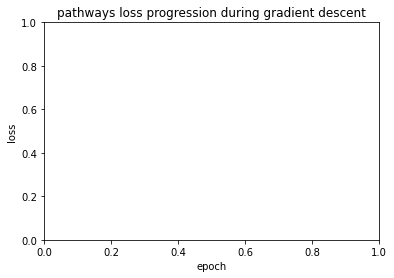

In [398]:
learning_rate = 0.000000004
for i in range(0,20):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(W)
        finalVectors_tensors = getPathwayEmbeddingEnhancedFinal(partialsVectors_tensor,W)
        loss = loss_opt(tf.transpose(finalVectors_tensors),tensorPathways,precomputed_weight_pathways)
        #loss =  getLoss(tf.transpose(finalVectors_tensors),loss)
    dl_dw = tape.gradient(loss, W)
    W.assign_sub(learning_rate * dl_dw)
    loss_progression = np.append(loss_progression,loss.numpy())
    #loss_progression = np.append(loss_progression,getLoss(tf.transpose(finalVectors_tensors),loss).numpy())
    print(loss)

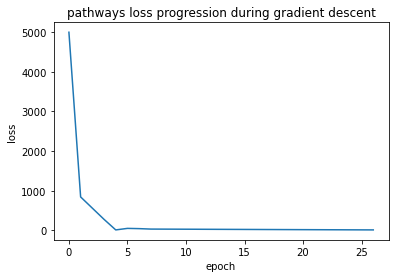

In [399]:
x = np.arange(0,27)
plt.title("pathways loss progression during gradient descent") 
plt.xlabel("epoch") 
plt.ylabel("loss") 
plt.plot(x,loss_progression) 
plt.show()

In [406]:
W = retrieveVariables("pathwayParameterMatrixTumorLumANew.txt")[0]

In [407]:
finalVectors_tensors = getPathwayEmbeddingEnhancedFinal(partialsVectors_tensor,W)
pathways["pathwayEmbeddings"]= finalVectors_tensors.numpy().transpose().tolist()
onlyPathwayEmbeddings = pd.DataFrame(np.array(pathways["pathwayEmbeddings"].tolist()))
onlyPathwayEmbeddings["pathway_id"] = pathways["pathway_id"]
onlyPathwayEmbeddings.to_csv("pathwayEmbeddingsTumorLumA113-2.csv")

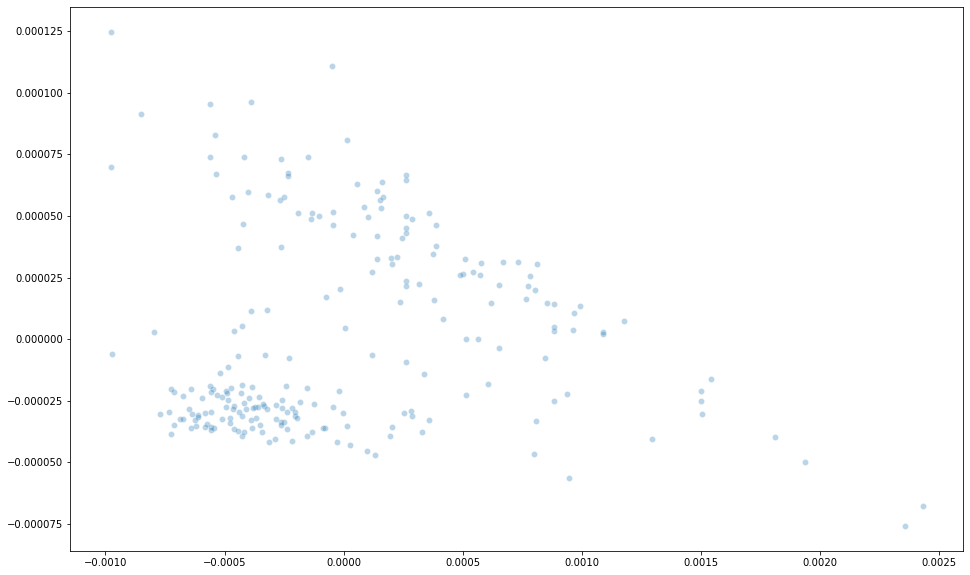

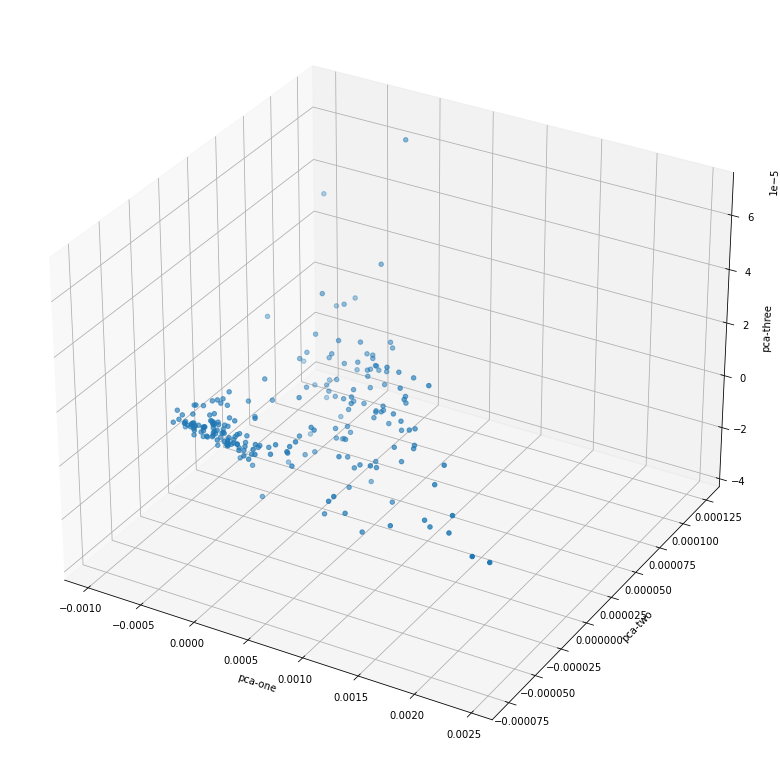

In [408]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(onlyPathwayEmbeddings.drop("pathway_id",axis=1))
firstDim = pca_result[:,0]
secondDim = pca_result[:,1] 
thirdDim = pca_result[:,2]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=firstDim, y=secondDim,
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.3
)
ax = plt.figure(figsize=(16,14)).gca(projection='3d')
ax.scatter(
    xs=firstDim, 
    ys=secondDim, 
    zs=thirdDim, 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

### 226- 339 PATIENTS LumA

In [414]:
def getPartialVec(Nodes):
    listatest =  Nodes.split(";")  
    listatest = list(map(int, listatest))  

    keys_tensor = tf.constant(listatest,dtype=tf.int64)
    vals_tensor = tf.ones_like(keys_tensor)  # Ones will be casted to True.

    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor),
        default_value=0)  # If index not in table, return 0.

    def hash_table_filter(index, value):
        table_value = table.lookup(index)  # 1 if index in arr, else 0.
        index_in_arr =  tf.cast(table_value, tf.bool) # 1 -> True, 0 -> False
        return index_in_arr

    tfFiltered = tfExprMatrixWeighted3.filter(hash_table_filter)
    tfFiltered = tfFiltered.map(lambda index,value : value).reduce(np.float64(0.0),lambda x,y: x+y)/ (len(listatest) * normalizer_constant)  #additional normalization by 100 000, otherwise with normalization costant, that is the maximum of all the record genes 
    return tfFiltered.numpy()
    

pathways["partialsVectors"] = pathways["nodes"].map(getPartialVec)
pathways["partialsVectors"] = pathways["partialsVectors"].where(pathways["partialsVectors"].map(lambda value: not not value.shape))
pathways = pathways.dropna()
W = np.diag(np.full(len(pathways["partialsVectors"][0]),0.001))
W_tensor = tf.Variable(W,dtype=tf.float64)
pathways["pathwayEmbeddings"] = pathways["partialsVectors"].map(lambda value: getPathwayEmbedding(value,W_tensor))
pathways["pathwayEmbeddings"]

npPartial = np.stack(pathways["partialsVectors"]).transpose()
partialsVectors_tensor = tf.constant(npPartial)
finalVectors_tensors = getPathwayEmbeddingEnhancedFinal(partialsVectors_tensor,W_tensor)
pathways["pathwayEmbeddings"]= finalVectors_tensors.numpy().transpose().tolist() #tf.make_ndarray(finalVectors_tensors)
#pathways["pathwayEmbeddings"][0]
pathways["nodes_set"] = list(map(lambda nodes: nodes.split(";") ,pathways["nodes"]))
pathwayPairs = combine(tf.constant(list(pathways.index)),tf.constant(list(pathways.index)))

In [415]:
indexOfPathways = dict()

for i in range(0,len(pathways.index)):
    indexOfPathways[pathways.index[i]] = i

tensorPathways = tf.map_fn(lambda row: tf.map_fn(lambda element:indexOfPathways[element.numpy()],tf.gather(row, [0, 1]).numpy()) ,pathwayPairs)
precomputed_weight_pathways = tf.constant(precompute_pathways_weight(pathways,pathwayPairs.numpy()),dtype=tf.float64)
W_numpy = np.diag(np.full(len(pathways["partialsVectors"][0]),0.01))
W = tf.Variable(W_numpy,dtype=tf.float64,name = "W")
npPartial = np.stack(pathways["partialsVectors"]).transpose()
partialsVectors_tensor = tf.constant(npPartial)  #tf.make_tensor_proto(npPartial)
loss = tf.Variable(0.0,dtype="float64")

In [ ]:
loss_progression = np.array([5000])
loss = tf.Variable(0.0,dtype="float64")

tf.Tensor(30.854727508349892, shape=(), dtype=float64)
tf.Tensor(29.739392676306696, shape=(), dtype=float64)
tf.Tensor(28.625385772783584, shape=(), dtype=float64)
tf.Tensor(27.512699027415426, shape=(), dtype=float64)
tf.Tensor(26.401466620930137, shape=(), dtype=float64)
tf.Tensor(25.291893743764884, shape=(), dtype=float64)
tf.Tensor(24.18419060865297, shape=(), dtype=float64)
tf.Tensor(23.07851630849523, shape=(), dtype=float64)
tf.Tensor(21.9751072403062, shape=(), dtype=float64)
tf.Tensor(20.874283112710287, shape=(), dtype=float64)
tf.Tensor(19.77744099532464, shape=(), dtype=float64)
tf.Tensor(18.684257124985837, shape=(), dtype=float64)
tf.Tensor(17.59536426520326, shape=(), dtype=float64)
tf.Tensor(16.5112244809068, shape=(), dtype=float64)
tf.Tensor(15.43246998784776, shape=(), dtype=float64)
tf.Tensor(14.360277511788183, shape=(), dtype=float64)
tf.Tensor(13.295695728510287, shape=(), dtype=float64)
tf.Tensor(12.240589750049029, shape=(), dtype=float64)
tf.Tensor(11.196916

ValueError: x and y must have same first dimension, but have shapes (21,) and (27,)

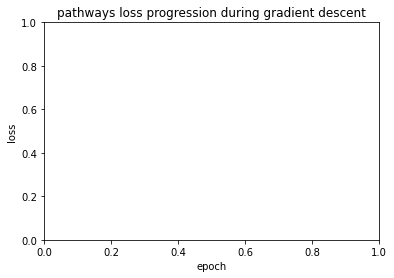

In [398]:
learning_rate = 0.000000004
for i in range(0,20):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(W)
        finalVectors_tensors = getPathwayEmbeddingEnhancedFinal(partialsVectors_tensor,W)
        loss = loss_opt(tf.transpose(finalVectors_tensors),tensorPathways,precomputed_weight_pathways)
        #loss =  getLoss(tf.transpose(finalVectors_tensors),loss)
    dl_dw = tape.gradient(loss, W)
    W.assign_sub(learning_rate * dl_dw)
    loss_progression = np.append(loss_progression,loss.numpy())
    #loss_progression = np.append(loss_progression,getLoss(tf.transpose(finalVectors_tensors),loss).numpy())
    print(loss)

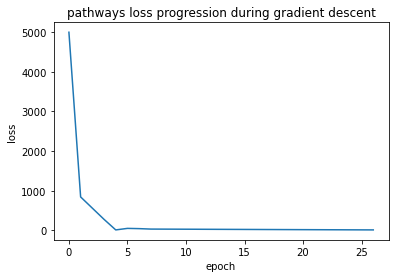

In [399]:
x = np.arange(0,27)
plt.title("pathways loss progression during gradient descent") 
plt.xlabel("epoch") 
plt.ylabel("loss") 
plt.plot(x,loss_progression) 
plt.show()

In [416]:
W = retrieveVariables("pathwayParameterMatrixTumorLumANew.txt")[0]

In [417]:
finalVectors_tensors = getPathwayEmbeddingEnhancedFinal(partialsVectors_tensor,W)
pathways["pathwayEmbeddings"]= finalVectors_tensors.numpy().transpose().tolist()
onlyPathwayEmbeddings = pd.DataFrame(np.array(pathways["pathwayEmbeddings"].tolist()))
onlyPathwayEmbeddings["pathway_id"] = pathways["pathway_id"]
onlyPathwayEmbeddings.to_csv("pathwayEmbeddingsTumorLumA113-3.csv")

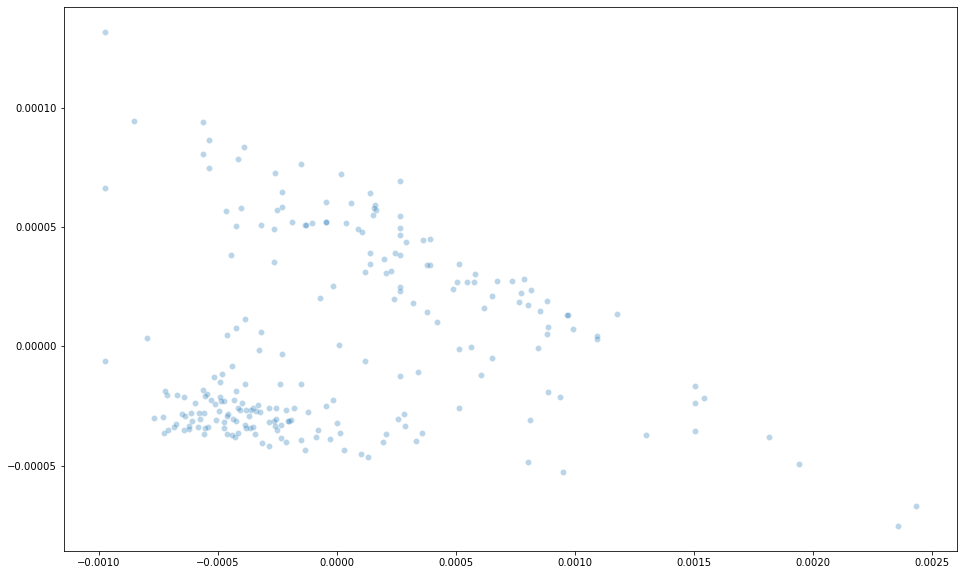

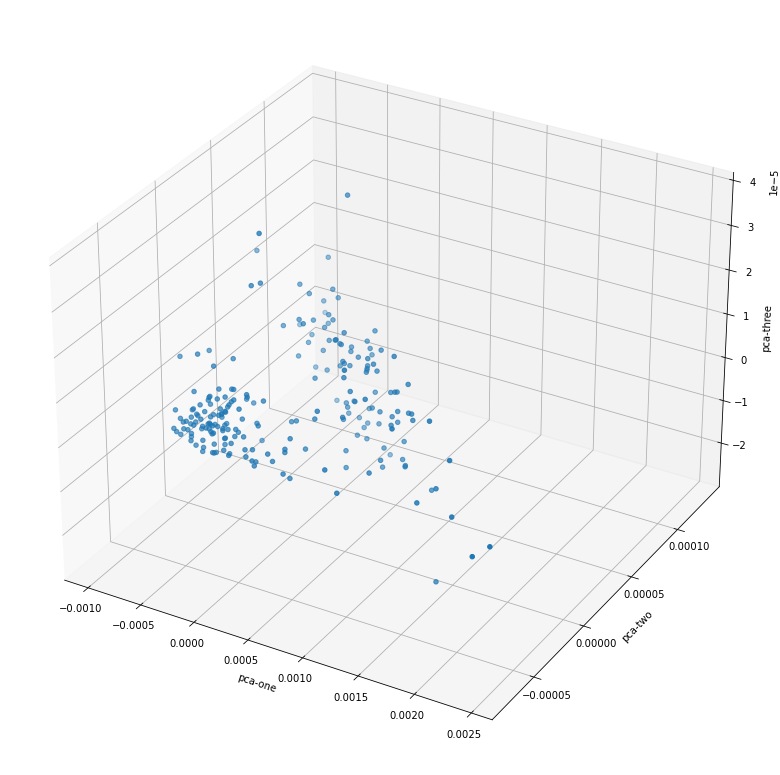

In [418]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(onlyPathwayEmbeddings.drop("pathway_id",axis=1))
firstDim = pca_result[:,0]
secondDim = pca_result[:,1] 
thirdDim = pca_result[:,2]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=firstDim, y=secondDim,
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.3
)
ax = plt.figure(figsize=(16,14)).gca(projection='3d')
ax.scatter(
    xs=firstDim, 
    ys=secondDim, 
    zs=thirdDim, 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

### 339- 452 PATIENTS LumA

In [419]:
def getPartialVec(Nodes):
    listatest =  Nodes.split(";")  
    listatest = list(map(int, listatest))  

    keys_tensor = tf.constant(listatest,dtype=tf.int64)
    vals_tensor = tf.ones_like(keys_tensor)  # Ones will be casted to True.

    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor),
        default_value=0)  # If index not in table, return 0.

    def hash_table_filter(index, value):
        table_value = table.lookup(index)  # 1 if index in arr, else 0.
        index_in_arr =  tf.cast(table_value, tf.bool) # 1 -> True, 0 -> False
        return index_in_arr

    tfFiltered = tfExprMatrixWeighted4.filter(hash_table_filter)
    tfFiltered = tfFiltered.map(lambda index,value : value).reduce(np.float64(0.0),lambda x,y: x+y)/ (len(listatest) * normalizer_constant)  #additional normalization by 100 000, otherwise with normalization costant, that is the maximum of all the record genes 
    return tfFiltered.numpy()
    

pathways["partialsVectors"] = pathways["nodes"].map(getPartialVec)
pathways["partialsVectors"] = pathways["partialsVectors"].where(pathways["partialsVectors"].map(lambda value: not not value.shape))
pathways = pathways.dropna()
W = np.diag(np.full(len(pathways["partialsVectors"][0]),0.001))
W_tensor = tf.Variable(W,dtype=tf.float64)
pathways["pathwayEmbeddings"] = pathways["partialsVectors"].map(lambda value: getPathwayEmbedding(value,W_tensor))
pathways["pathwayEmbeddings"]

npPartial = np.stack(pathways["partialsVectors"]).transpose()
partialsVectors_tensor = tf.constant(npPartial)
finalVectors_tensors = getPathwayEmbeddingEnhancedFinal(partialsVectors_tensor,W_tensor)
pathways["pathwayEmbeddings"]= finalVectors_tensors.numpy().transpose().tolist() #tf.make_ndarray(finalVectors_tensors)
#pathways["pathwayEmbeddings"][0]
pathways["nodes_set"] = list(map(lambda nodes: nodes.split(";") ,pathways["nodes"]))
pathwayPairs = combine(tf.constant(list(pathways.index)),tf.constant(list(pathways.index)))

In [420]:
indexOfPathways = dict()

for i in range(0,len(pathways.index)):
    indexOfPathways[pathways.index[i]] = i

tensorPathways = tf.map_fn(lambda row: tf.map_fn(lambda element:indexOfPathways[element.numpy()],tf.gather(row, [0, 1]).numpy()) ,pathwayPairs)
precomputed_weight_pathways = tf.constant(precompute_pathways_weight(pathways,pathwayPairs.numpy()),dtype=tf.float64)
W_numpy = np.diag(np.full(len(pathways["partialsVectors"][0]),0.01))
W = tf.Variable(W_numpy,dtype=tf.float64,name = "W")
npPartial = np.stack(pathways["partialsVectors"]).transpose()
partialsVectors_tensor = tf.constant(npPartial)  #tf.make_tensor_proto(npPartial)
loss = tf.Variable(0.0,dtype="float64")

In [396]:
loss_progression = np.array([5000])
loss = tf.Variable(0.0,dtype="float64")

tf.Tensor(30.854727508349892, shape=(), dtype=float64)
tf.Tensor(29.739392676306696, shape=(), dtype=float64)
tf.Tensor(28.625385772783584, shape=(), dtype=float64)
tf.Tensor(27.512699027415426, shape=(), dtype=float64)
tf.Tensor(26.401466620930137, shape=(), dtype=float64)
tf.Tensor(25.291893743764884, shape=(), dtype=float64)
tf.Tensor(24.18419060865297, shape=(), dtype=float64)
tf.Tensor(23.07851630849523, shape=(), dtype=float64)
tf.Tensor(21.9751072403062, shape=(), dtype=float64)
tf.Tensor(20.874283112710287, shape=(), dtype=float64)
tf.Tensor(19.77744099532464, shape=(), dtype=float64)
tf.Tensor(18.684257124985837, shape=(), dtype=float64)
tf.Tensor(17.59536426520326, shape=(), dtype=float64)
tf.Tensor(16.5112244809068, shape=(), dtype=float64)
tf.Tensor(15.43246998784776, shape=(), dtype=float64)
tf.Tensor(14.360277511788183, shape=(), dtype=float64)
tf.Tensor(13.295695728510287, shape=(), dtype=float64)
tf.Tensor(12.240589750049029, shape=(), dtype=float64)
tf.Tensor(11.196916

ValueError: x and y must have same first dimension, but have shapes (21,) and (27,)

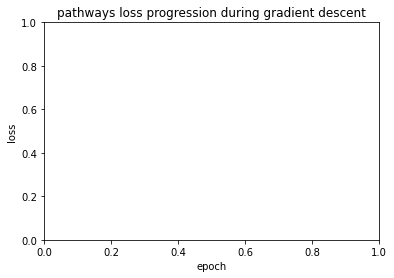

In [398]:
learning_rate = 0.000000004
for i in range(0,20):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(W)
        finalVectors_tensors = getPathwayEmbeddingEnhancedFinal(partialsVectors_tensor,W)
        loss = loss_opt(tf.transpose(finalVectors_tensors),tensorPathways,precomputed_weight_pathways)
        #loss =  getLoss(tf.transpose(finalVectors_tensors),loss)
    dl_dw = tape.gradient(loss, W)
    W.assign_sub(learning_rate * dl_dw)
    loss_progression = np.append(loss_progression,loss.numpy())
    #loss_progression = np.append(loss_progression,getLoss(tf.transpose(finalVectors_tensors),loss).numpy())
    print(loss)

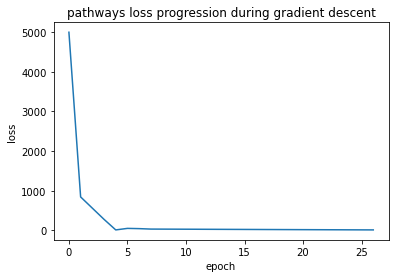

In [399]:
x = np.arange(0,27)
plt.title("pathways loss progression during gradient descent") 
plt.xlabel("epoch") 
plt.ylabel("loss") 
plt.plot(x,loss_progression) 
plt.show()

In [421]:
W = retrieveVariables("pathwayParameterMatrixTumorLumANew.txt")[0]

In [422]:
finalVectors_tensors = getPathwayEmbeddingEnhancedFinal(partialsVectors_tensor,W)
pathways["pathwayEmbeddings"]= finalVectors_tensors.numpy().transpose().tolist()
onlyPathwayEmbeddings = pd.DataFrame(np.array(pathways["pathwayEmbeddings"].tolist()))
onlyPathwayEmbeddings["pathway_id"] = pathways["pathway_id"]
onlyPathwayEmbeddings.to_csv("pathwayEmbeddingsTumorLumA113-4.csv")

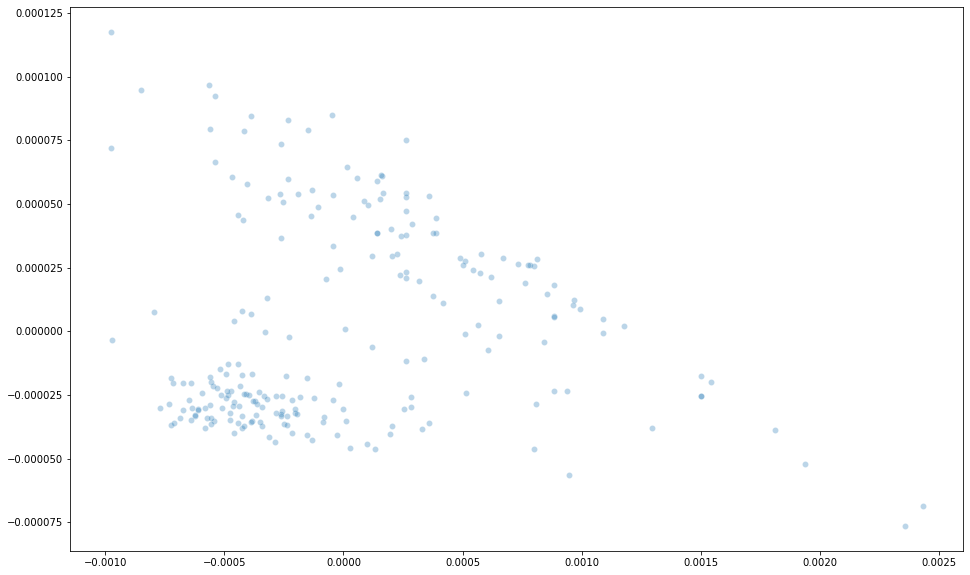

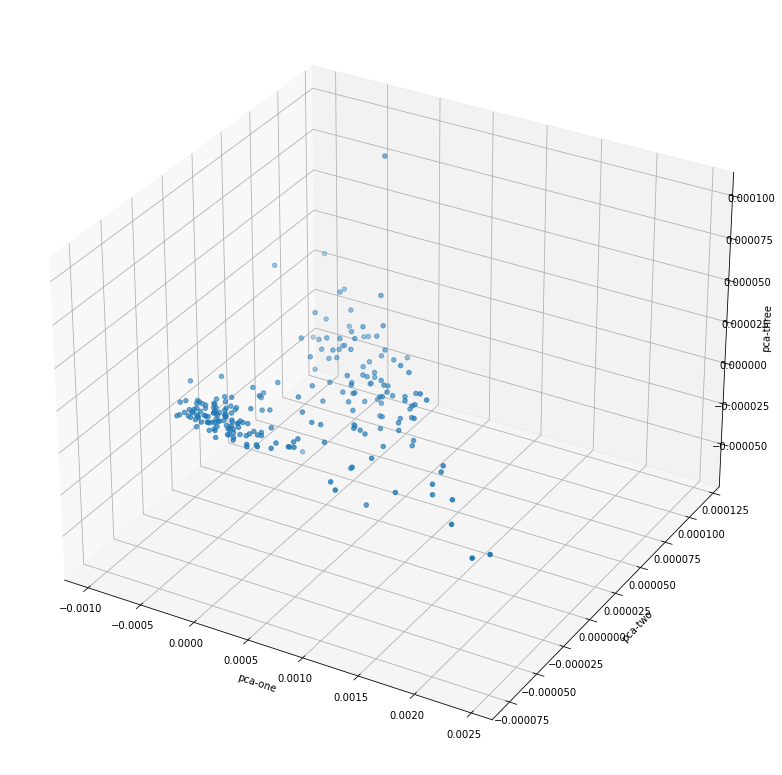

In [423]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(onlyPathwayEmbeddings.drop("pathway_id",axis=1))
firstDim = pca_result[:,0]
secondDim = pca_result[:,1] 
thirdDim = pca_result[:,2]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=firstDim, y=secondDim,
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.3
)
ax = plt.figure(figsize=(16,14)).gca(projection='3d')
ax.scatter(
    xs=firstDim, 
    ys=secondDim, 
    zs=thirdDim, 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

## Pathway embeddings for tumors(lumB with 113 patients)

In [184]:
betweennessListTumors = nx.betweenness_centrality(Gtumors,normalized = True, 
                                              endpoints = False)

In [424]:
tfDatasetGenesExpressionsTumors = tf.data.Dataset.from_tensor_slices((genesEmbeddingsTumorLumB.index,genesEmbeddingsTumorLumB.values))
normalizer_constant = genesEmbeddingsTumorLumB.max().max()
normalizer_constant

0.010687563568353653

In [425]:
#geneWeights = tf.constant(list(map(lambda value: gene_weight(value,betweennessList),list(genesEmbeddings.index))),dtype=tf.float64)
geneWeightsTumor = list(map(lambda value: gene_weight(value,betweennessListTumors),list(genesEmbeddingsTumorLumB.index)))

In [426]:
exprMatrixWeightedTumors = genesEmbeddingsTumorLumB.mul(geneWeightsTumor,axis=0)
exprMatrixWeightedTumors

0         1         2         3         4         5         6    \
2      0.008066  0.009181  0.009529  0.007736  0.008955  0.009441  0.008742   
3      0.008129  0.009336  0.009642  0.007812  0.008795  0.009024  0.008635   
7      0.008085  0.009213  0.009582  0.007538  0.009009  0.009334  0.008707   
8      0.008092  0.009209  0.009590  0.007535  0.009008  0.009336  0.008718   
10     0.008094  0.009216  0.009598  0.007536  0.008984  0.009317  0.008729   
...         ...       ...       ...       ...       ...       ...       ...   
20526  0.008050  0.009233  0.009576  0.007499  0.008864  0.009262  0.008704   
20527  0.008085  0.009205  0.009585  0.007546  0.009015  0.009336  0.008704   
20528  0.008093  0.009217  0.009601  0.007531  0.009012  0.009339  0.008725   
20529  0.008097  0.009208  0.009591  0.007536  0.009008  0.009335  0.008719   
20530  0.008087  0.009196  0.009572  0.007560  0.009013  0.009333  0.008689   

            7         8         9    ...       103       104       105  \
2      0.007348  0.007903  0.007942  ...  0.008182  0.007679  0.009976   
3      0.007236  0.008111  0.008233  ...  0.008309  0.007449  0.009873   
7      0.007254  0.008031  0.007983  ...  0.008012  0.007588  0.009979   
8      0.007247  0.008024  0.007971  ...  0.008030  0.007584  0.009975   
10     0.007232  0.008023  0.007988  ...  0.008048  0.007591  0.009966   
...         ...       ...       ...  ...       ...       ...       ...   
20526  0.007391  0.007994  0.008025  ...  0.008089  0.007747  0.009926   
20527  0.007261  0.008023  0.007972  ...  0.008028  0.007602  0.009985   
20528  0.007246  0.008032  0.007961  ...  0.008036  0.007561  0.009966   
20529  0.007250  0.008023  0.007966  ...  0.008037  0.007584  0.009974   
20530  0.007272  0.008019  0.007981  ...  0.008034  0.007623  0.009999   

            106       107       108       109       110       111       112  
2      0.009976  0.009415  0.007641  0.009358  0.007378  0.009639  0.009825  
3      0.009797  0.009396  0.007468  0.009217  0.006978  0.009808  0.010148  
7      0.009890  0.009372  0.007511  0.009290  0.007273  0.009714  0.009894  
8      0.009907  0.009388  0.007508  0.009305  0.007293  0.009698  0.009888  
10     0.009912  0.009398  0.007492  0.009299  0.007287  0.009693  0.009908  
...         ...       ...       ...       ...       ...       ...       ...  
20526  0.009859  0.009379  0.007572  0.009222  0.007299  0.009709  0.009950  
20527  0.009901  0.009391  0.007523  0.009307  0.007291  0.009709  0.009882  
20528  0.009917  0.009384  0.007503  0.009313  0.007288  0.009694  0.009888  
20529  0.009913  0.009394  0.007513  0.009311  0.007302  0.009697  0.009886  
20530  0.009890  0.009403  0.007539  0.009307  0.007301  0.009715  0.009878  

[19727 rows x 113 columns]

In [427]:
tfExprMatrixWeighted = tf.data.Dataset.from_tensor_slices((exprMatrixWeightedTumors.index,exprMatrixWeightedTumors.values))

In [428]:
def getPartialVec(Nodes):
    listatest =  Nodes.split(";")  
    listatest = list(map(int, listatest))  

    keys_tensor = tf.constant(listatest,dtype=tf.int64)
    vals_tensor = tf.ones_like(keys_tensor)  # Ones will be casted to True.

    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor),
        default_value=0)  # If index not in table, return 0.

    def hash_table_filter(index, value):
        table_value = table.lookup(index)  # 1 if index in arr, else 0.
        index_in_arr =  tf.cast(table_value, tf.bool) # 1 -> True, 0 -> False
        return index_in_arr

    tfFiltered = tfExprMatrixWeighted.filter(hash_table_filter)
    tfFiltered = tfFiltered.map(lambda index,value : value).reduce(np.float64(0.0),lambda x,y: x+y)/ (len(listatest) * normalizer_constant)  #additional normalization by 100 000, otherwise with normalization costant, that is the maximum of all the record genes 
    return tfFiltered.numpy()
    

pathways["partialsVectors"] = pathways["nodes"].map(getPartialVec)

In [429]:
pathways["partialsVectors"].where(pathways["partialsVectors"].map(lambda value: not not value.shape)).dropna()

0      [0.5797015783686249, 0.6602888722631706, 0.686...
1      [0.5301185271396459, 0.6029842839869066, 0.626...
2      [0.5034579202424884, 0.5746483898766587, 0.597...
3      [0.5660271304478094, 0.6487179395199008, 0.672...
4      [0.4342925507615145, 0.4965247254951243, 0.515...
                             ...                        
222    [0.45799247026613343, 0.5229395930747349, 0.54...
223    [0.49897001497689947, 0.571708124300541, 0.593...
224    [0.3362336445963095, 0.3836794293820646, 0.399...
225    [0.18930997925700987, 0.21550682730545734, 0.2...
226    [0.36613270359855166, 0.41931593650238974, 0.4...
Name: partialsVectors, Length: 226, dtype: object

In [430]:
pathways["partialsVectors"] = pathways["partialsVectors"].where(pathways["partialsVectors"].map(lambda value: not not value.shape))
pathways = pathways.dropna()

Transposing the feature tensor because we need It to be transposed to do the matrix multiplication of the feature(rows)

In [432]:
npPartial = np.stack(pathways["partialsVectors"]).transpose()
partialsVectors_tensor = tf.constant(npPartial)
finalVectors_tensors = getPathwayEmbeddingEnhancedFinal(partialsVectors_tensor,W_tensor)
pathways["pathwayEmbeddings"]= finalVectors_tensors.numpy().transpose().tolist() #tf.make_ndarray(finalVectors_tensors)
#pathways["pathwayEmbeddings"][0]

In [433]:
finalVectors_tensors

<tf.Tensor: shape=(113, 226), dtype=float64, numpy=
array([[0.0005797 , 0.00053012, 0.00050346, ..., 0.00033623, 0.00018931,
        0.00036613],
       [0.00066029, 0.00060298, 0.00057465, ..., 0.00038368, 0.00021551,
        0.00041932],
       [0.00068684, 0.00062694, 0.00059743, ..., 0.00039945, 0.00022435,
        0.00043545],
       ...,
       [0.00052287, 0.00047786, 0.00045517, ..., 0.00030237, 0.00017052,
        0.00033045],
       [0.00069408, 0.00063461, 0.00060479, ..., 0.00040313, 0.00022687,
        0.00044   ],
       [0.0007095 , 0.00064734, 0.00061541, ..., 0.00041194, 0.00023138,
        0.00044858]])>

In [434]:
pathways["nodes_set"] = list(map(lambda nodes: nodes.split(";") ,pathways["nodes"]))

In [435]:
pathwayPairs = combine(tf.constant(list(pathways.index)),tf.constant(list(pathways.index)))
pathwayPairs.numpy()[0]

array([0, 0], dtype=int32)

In [436]:
indexOfPathways = dict()

for i in range(0,len(pathways.index)):
    indexOfPathways[pathways.index[i]] = i

tensorPathways = tf.map_fn(lambda row: tf.map_fn(lambda element:indexOfPathways[element.numpy()],tf.gather(row, [0, 1]).numpy()) ,pathwayPairs)  # take only edges with no weight

In [437]:
precomputed_weight_pathways = tf.constant(precompute_pathways_weight(pathways,pathwayPairs.numpy()),dtype=tf.float64)

In [438]:
loss = tf.Variable(0.0,dtype="float64")
#firstLoss = getLoss(tf.transpose(finalVectors_tensors),loss).numpy()
firstLoss = loss_opt(tf.transpose(finalVectors_tensors),tensorPathways,precomputed_weight_pathways).numpy()

In [439]:
firstLoss

85.30758902316717

In [440]:
W_numpy = np.diag(np.full(len(pathways["partialsVectors"][0]),0.01))
W = tf.Variable(W_numpy,dtype=tf.float64,name = "W")
npPartial = np.stack(pathways["partialsVectors"]).transpose()
partialsVectors_tensor = tf.constant(npPartial)  #tf.make_tensor_proto(npPartial)
loss = tf.Variable(0.0,dtype="float64")

In [153]:
with tf.GradientTape(persistent=True) as tape:
    loss.assign(0.0)
    tape.watch(W)
    finalVectors_tensors = getPathwayEmbeddingEnhancedFinal(partialsVectors_tensor,W)
    loss = loss_opt(tf.transpose(finalVectors_tensors),tensorPathways,precomputed_weight_pathways)
    #loss =  getLoss(tf.transpose(finalVectors_tensors),loss)
tape.gradient(loss, W)


<tf.Tensor: shape=(113, 113), dtype=float64, numpy=
array([[6.59790111, 7.57747537, 7.84971406, ..., 5.96409493, 7.92237115,
        8.06124397],
       [7.57747537, 8.70249956, 9.01514696, ..., 6.84957219, 9.0985907 ,
        9.25809212],
       [7.84971406, 9.01514696, 9.33904395, ..., 7.09566146, 9.42548533,
        9.59070082],
       ...,
       [5.96409493, 6.84957219, 7.09566146, ..., 5.39118931, 7.16133596,
        7.28686296],
       [7.92237115, 9.0985907 , 9.42548533, ..., 7.16133596, 9.51273039,
        9.67947287],
       [8.06124397, 9.25809212, 9.59070082, ..., 7.28686296, 9.67947287,
        9.8491695 ]])>

In [441]:
learning_rate = 0.0000001
loss_progression = np.array([5000])
loss = tf.Variable(0.0,dtype="float64")

In [444]:
learning_rate = 0.00000001
for i in range(0,10):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(W)
        finalVectors_tensors = getPathwayEmbeddingEnhancedFinal(partialsVectors_tensor,W)
        loss = loss_opt(tf.transpose(finalVectors_tensors),tensorPathways,precomputed_weight_pathways)
        #loss =  getLoss(tf.transpose(finalVectors_tensors),loss)
    dl_dw = tape.gradient(loss, W)
    W.assign_sub(learning_rate * dl_dw)
    finalVectors_tensors = getPathwayEmbeddingEnhancedFinal(partialsVectors_tensor,W)
    loss_progression = np.append(loss_progression,loss.numpy())
    #loss_progression = np.append(loss_progression,getLoss(tf.transpose(finalVectors_tensors),loss).numpy())
    print(loss)

tf.Tensor(40.21325993444805, shape=(), dtype=float64)
tf.Tensor(37.328084170378645, shape=(), dtype=float64)
tf.Tensor(34.446133423887126, shape=(), dtype=float64)
tf.Tensor(31.568268077917907, shape=(), dtype=float64)
tf.Tensor(28.69514895180557, shape=(), dtype=float64)
tf.Tensor(25.8287624597954, shape=(), dtype=float64)
tf.Tensor(22.97026428795541, shape=(), dtype=float64)
tf.Tensor(20.12312401027249, shape=(), dtype=float64)
tf.Tensor(17.29179774689828, shape=(), dtype=float64)
tf.Tensor(14.485130676580178, shape=(), dtype=float64)


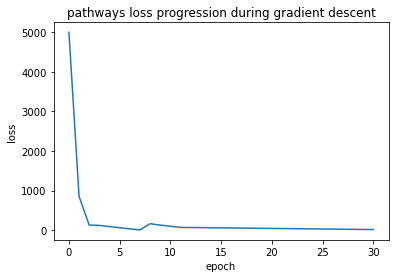

In [445]:
x = np.arange(0,31)
plt.title("pathways loss progression during gradient descent") 
plt.xlabel("epoch") 
plt.ylabel("loss") 
plt.plot(x,loss_progression) 
plt.show()

In [446]:
saveVariables("pathwayParameterMatrixTumorLumBNew.txt",[W])

In [447]:
W = retrieveVariables("pathwayParameterMatrixTumorLumBNew.txt")[0]
W

<tf.Variable 'W:0' shape=(113, 113) dtype=float64, numpy=
array([[ 9.92506910e-03, -8.58960225e-05, -8.89665625e-05, ...,
        -6.77455020e-05, -8.96652698e-05, -9.11683720e-05],
       [-8.59742064e-05,  9.90083277e-03, -1.02326109e-04, ...,
        -7.79523333e-05, -1.03088907e-04, -1.04445503e-04],
       [-8.89904619e-05, -1.02260592e-04,  9.89414509e-03, ...,
        -8.05589334e-05, -1.06674626e-04, -1.08325323e-04],
       ...,
       [-6.77835256e-05, -7.79252491e-05, -8.05825172e-05, ...,
         9.93828669e-03, -8.11111744e-05, -8.22017738e-05],
       [-8.96118990e-05, -1.02933740e-04, -1.06582469e-04, ...,
        -8.10172234e-05,  9.89215116e-03, -1.09392866e-04],
       [-9.10576707e-05, -1.04223052e-04, -1.08164557e-04, ...,
        -8.20552402e-05, -1.09325016e-04,  9.88858867e-03]])>

In [448]:
loss = tf.Variable(0.0,dtype="float64")
finalVectors_tensors = getPathwayEmbeddingEnhancedFinal(partialsVectors_tensor,W)
loss_opt(tf.transpose(finalVectors_tensors),tensorPathways,precomputed_weight_pathways)

<tf.Tensor: shape=(), dtype=float64, numpy=11.719835937811581>

In [449]:
finalVectors_tensors = getPathwayEmbeddingEnhancedFinal(partialsVectors_tensor,W)
pathways["pathwayEmbeddings"]= finalVectors_tensors.numpy().transpose().tolist()

In [450]:
pathways

pathway_id                                  pathway_name  \
0    path:hsa00190                     Oxidative phosphorylation   
1    path:hsa00072    Synthesis and degradation of ketone bodies   
2    path:hsa01040       Biosynthesis of unsaturated fatty acids   
3    path:hsa04672  Intestinal immune network for IgA production   
4    path:hsa03460                        Fanconi anemia pathway   
..             ...                                           ...   
222  path:hsa03013                                 RNA transport   
223  path:hsa04340                    Hedgehog signaling pathway   
224  path:hsa03018                               RNA degradation   
225  path:hsa00785                        Lipoic acid metabolism   
226  path:hsa03015                     mRNA surveillance pathway   

                                                 nodes  \
0    64077;5464;245972;245973;479;513;514;515;516;5...   
1      64064;38;39;3155;56898;54511;622;3158;3157;5019   
2    641371;79966;6319;570;9415;3992;10965;122970;1...   
3    4055;8174;959;8741;3600;23308;102723407;6370;5...   
4    3280;378708;55120;672;84126;675;2189;83990;229...   
..                                                 ...   
222  8893;8891;8892;9984;8890;1975;340529;8662;8663...   
223  64399;122011;595;1456;1455;1454;1453;1452;6469...   
224  5042;132430;340529;8761;645974;26986;80336;992...   
225                          116285;11019;387787;51601   
226  81608;23049;2107;10898;10978;53981;4686;5976;5...   

                                       partialsVectors  \
0    [0.5797015783686249, 0.6602888722631706, 0.686...   
1    [0.5301185271396459, 0.6029842839869066, 0.626...   
2    [0.5034579202424884, 0.5746483898766587, 0.597...   
3    [0.5660271304478094, 0.6487179395199008, 0.672...   
4    [0.4342925507615145, 0.4965247254951243, 0.515...   
..                                                 ...   
222  [0.45799247026613343, 0.5229395930747349, 0.54...   
223  [0.49897001497689947, 0.571708124300541, 0.593...   
224  [0.3362336445963095, 0.3836794293820646, 0.399...   
225  [0.18930997925700987, 0.21550682730545734, 0.2...   
226  [0.36613270359855166, 0.41931593650238974, 0.4...   

                                             nodes_set  \
0    [64077, 5464, 245972, 245973, 479, 513, 514, 5...   
1    [64064, 38, 39, 3155, 56898, 54511, 622, 3158,...   
2    [641371, 79966, 6319, 570, 9415, 3992, 10965, ...   
3    [4055, 8174, 959, 8741, 3600, 23308, 102723407...   
4    [3280, 378708, 55120, 672, 84126, 675, 2189, 8...   
..                                                 ...   
222  [8893, 8891, 8892, 9984, 8890, 1975, 340529, 8...   
223  [64399, 122011, 595, 1456, 1455, 1454, 1453, 1...   
224  [5042, 132430, 340529, 8761, 645974, 26986, 80...   
225                     [116285, 11019, 387787, 51601]   
226  [81608, 23049, 2107, 10898, 10978, 53981, 4686...   

                                     pathwayEmbeddings  
0    [-3.0255001517318058e-05, -4.88930631843435e-0...  
1    [-2.6927341531859917e-05, -4.551617905416801e-...  
2    [-2.853285364890908e-05, -4.265928374571291e-0...  
3    [-3.3435712874761033e-05, -4.4237267319904714e...  
4    [-2.4694112503573482e-05, -3.525479496784701e-...  
..                                                 ...  
222  [-2.5745985490256625e-05, -3.8190428350845e-05...  
223  [-2.9269044722880585e-05, -3.907244926882591e-...  
224  [-1.7840560119524545e-05, -2.728419554078518e-...  
225  [-9.701776362707948e-06, -1.600138456906128e-0...  
226  [-2.2372582241064727e-05, -3.007475686358495e-...  

[226 rows x 6 columns]

In [451]:
pathways["pathway_name"].describe()

count                       226
unique                      226
top       p53 signaling pathway
freq                          1
Name: pathway_name, dtype: object

In [452]:
onlyPathwayEmbeddings = pd.DataFrame(np.array(pathways["pathwayEmbeddings"].tolist()))

In [453]:
onlyPathwayEmbeddings["pathway_id"] = pathways["pathway_id"]
onlyPathwayEmbeddings

0         1         2         3         4         5         6  \
0   -0.000030 -0.000049 -0.000042 -0.000043 -0.000042 -0.000053 -0.000051   
1   -0.000027 -0.000046 -0.000040 -0.000042 -0.000038 -0.000053 -0.000050   
2   -0.000029 -0.000043 -0.000037 -0.000043 -0.000036 -0.000048 -0.000047   
3   -0.000033 -0.000044 -0.000041 -0.000042 -0.000039 -0.000048 -0.000048   
4   -0.000025 -0.000035 -0.000033 -0.000031 -0.000029 -0.000038 -0.000038   
..        ...       ...       ...       ...       ...       ...       ...   
221 -0.000026 -0.000038 -0.000033 -0.000036 -0.000032 -0.000042 -0.000042   
222 -0.000029 -0.000039 -0.000036 -0.000038 -0.000036 -0.000043 -0.000041   
223 -0.000018 -0.000027 -0.000022 -0.000027 -0.000023 -0.000031 -0.000031   
224 -0.000010 -0.000016 -0.000013 -0.000016 -0.000012 -0.000017 -0.000017   
225 -0.000022 -0.000030 -0.000027 -0.000026 -0.000026 -0.000032 -0.000032   

            7         8         9  ...       104       105       106  \
0   -0.000220 -0.000033 -0.000036  ... -0.000011 -0.000005 -0.000073   
1   -0.000196 -0.000028 -0.000033  ... -0.000011 -0.000008 -0.000065   
2   -0.000190 -0.000027 -0.000030  ... -0.000011 -0.000007 -0.000061   
3   -0.000225 -0.000032 -0.000034  ... -0.000016 -0.000014 -0.000060   
4   -0.000168 -0.000027 -0.000028  ... -0.000012 -0.000007 -0.000051   
..        ...       ...       ...  ...       ...       ...       ...   
221 -0.000174 -0.000026 -0.000027  ... -0.000012 -0.000004 -0.000059   
222 -0.000198 -0.000030 -0.000032  ... -0.000014 -0.000013 -0.000055   
223 -0.000126 -0.000016 -0.000021  ... -0.000009 -0.000003 -0.000043   
224 -0.000073 -0.000010 -0.000012  ... -0.000005 -0.000001 -0.000024   
225 -0.000142 -0.000022 -0.000022  ... -0.000010 -0.000007 -0.000044   

          107       108       109       110       111       112     pathway_id  
0   -0.000046 -0.000013 -0.000061 -0.000033 -0.000039 -0.000027  path:hsa00190  
1   -0.000040 -0.000011 -0.000057 -0.000030 -0.000035 -0.000027  path:hsa00072  
2   -0.000039 -0.000013 -0.000053 -0.000028 -0.000032 -0.000028  path:hsa01040  
3   -0.000044 -0.000019 -0.000053 -0.000034 -0.000039 -0.000035  path:hsa04672  
4   -0.000034 -0.000010 -0.000043 -0.000026 -0.000029 -0.000025  path:hsa03460  
..        ...       ...       ...       ...       ...       ...            ...  
221 -0.000038 -0.000012 -0.000049 -0.000029 -0.000030 -0.000023  path:hsa00780  
222 -0.000040 -0.000017 -0.000045 -0.000029 -0.000035 -0.000030  path:hsa03013  
223 -0.000026 -0.000008 -0.000036 -0.000021 -0.000022 -0.000015  path:hsa04340  
224 -0.000015 -0.000006 -0.000020 -0.000011 -0.000012 -0.000009  path:hsa03018  
225 -0.000029 -0.000010 -0.000036 -0.000023 -0.000025 -0.000020  path:hsa00785  

[226 rows x 114 columns]

In [454]:
onlyPathwayEmbeddings.to_csv("pathwayEmbeddingsTumorLumB113New.csv")

In [167]:
onlyPathwayEmbeddings.describe()

0             1             2             3             4    \
count  2.270000e+02  2.270000e+02  2.270000e+02  2.270000e+02  2.270000e+02   
mean   1.065006e-06  1.223007e-06  1.267040e-06  1.005194e-06  1.187224e-06   
std    1.277325e-06  1.466999e-06  1.519682e-06  1.205604e-06  1.423833e-06   
min    6.289643e-11  7.187203e-11  7.476859e-11  5.891325e-11  7.042125e-11   
25%    5.376586e-10  6.129949e-10  6.378554e-10  5.037278e-10  5.992522e-10   
50%    2.510883e-07  2.882665e-07  2.988234e-07  2.362679e-07  2.799334e-07   
75%    2.202883e-06  2.529976e-06  2.620610e-06  2.078531e-06  2.454661e-06   
max    4.902312e-06  5.634804e-06  5.834186e-06  4.627788e-06  5.464274e-06   

                5             6             7             8             9    \
count  2.270000e+02  2.270000e+02  2.270000e+02  2.270000e+02  2.270000e+02   
mean   1.239122e-06  1.159114e-06  9.492459e-07  1.059088e-06  1.055837e-06   
std    1.486216e-06  1.390251e-06  1.138805e-06  1.270425e-06  1.266415e-06   
min    7.283050e-11  6.773047e-11  5.686476e-11  6.278114e-11  6.218950e-11   
25%    6.218030e-10  5.790142e-10  4.838968e-10  5.340470e-10  5.322294e-10   
50%    2.919631e-07  2.735914e-07  2.236448e-07  2.500455e-07  2.489166e-07   
75%    2.563675e-06  2.398603e-06  1.965058e-06  2.192588e-06  2.184237e-06   
max    5.707224e-06  5.340695e-06  4.382588e-06  4.885173e-06  4.867369e-06   

       ...           103           104           105           106  \
count  ...  2.270000e+02  2.270000e+02  2.270000e+02  2.270000e+02   
mean   ...  1.067466e-06  1.003352e-06  1.305976e-06  1.323966e-06   
std    ...  1.280513e-06  1.203679e-06  1.566427e-06  1.588171e-06   
min    ...  6.241136e-11  5.917546e-11  7.785859e-11  7.698704e-11   
25%    ...  5.358151e-10  5.051212e-10  6.641402e-10  6.583943e-10   
50%    ...  2.512822e-07  2.365014e-07  3.074823e-07  3.119269e-07   
75%    ...  2.208355e-06  2.075977e-06  2.701960e-06  2.739244e-06   
max    ...  4.926804e-06  4.623565e-06  6.015630e-06  6.104690e-06   

                107           108           109           110           111  \
count  2.270000e+02  2.270000e+02  2.270000e+02  2.270000e+02  2.270000e+02   
mean   1.242729e-06  9.890468e-07  1.240495e-06  9.626598e-07  1.278843e-06   
std    1.490557e-06  1.186366e-06  1.487929e-06  1.154645e-06  1.533745e-06   
min    7.298210e-11  5.870949e-11  7.236083e-11  5.645333e-11  7.591669e-11   
25%    6.247345e-10  5.014409e-10  6.203133e-10  4.842893e-10  6.451499e-10   
50%    2.929217e-07  2.328638e-07  2.924095e-07  2.267279e-07  3.016755e-07   
75%    2.570079e-06  2.047043e-06  2.567141e-06  1.991133e-06  2.643862e-06   
max    5.729171e-06  4.560317e-06  5.718945e-06  4.433909e-06  5.887781e-06   

                112  
count  2.270000e+02  
mean   1.301160e-06  
std    1.560636e-06  
min    7.711844e-11  
25%    6.581655e-10  
50%    3.066415e-07  
75%    2.691538e-06  
max    5.991301e-06  

[8 rows x 113 columns]

<AxesSubplot:>

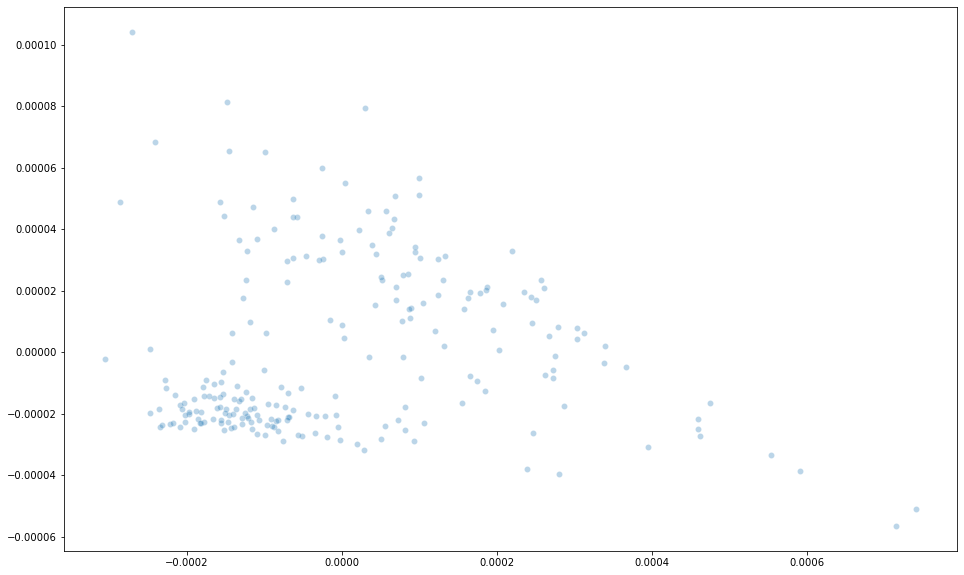

In [455]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(onlyPathwayEmbeddings.drop("pathway_id",axis=1))
firstDim = pca_result[:,0]
secondDim = pca_result[:,1] 
thirdDim = pca_result[:,2]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=firstDim, y=secondDim,
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.3
)

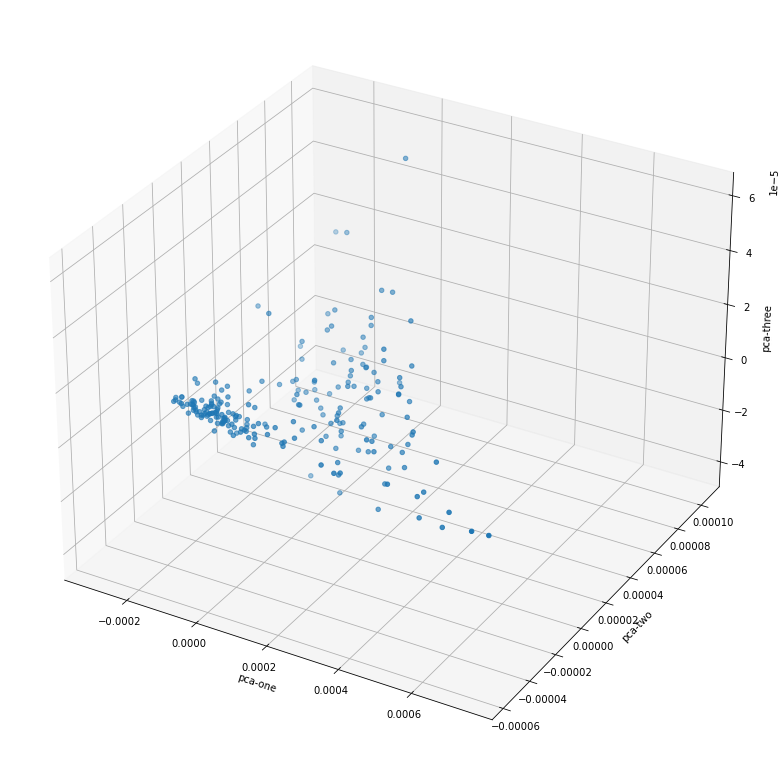

In [456]:
ax = plt.figure(figsize=(16,14)).gca(projection='3d')
ax.scatter(
    xs=firstDim, 
    ys=secondDim, 
    zs=thirdDim, 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()